

# 🧪 crop spy2



In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import struct
import os
import re
import nibabel as nib

In [2]:
#!/usr/bin/env python
# coding: utf-8

from sklearn.metrics import classification_report,auc,roc_auc_score
from PIL import Image
import time
from pathlib import Path

import os
import numpy as np
import pandas as pd
from PIL import Image

import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from glob import glob
#from skimage import io
from sklearn.utils import shuffle

#from nipype.interfaces.ants import N4BiasFieldCorrection
import sys

import warnings
warnings.filterwarnings('ignore')


def print_info(ims):

    for im in ims:
        
        print(im.shape, im.min(), im.max(), im.mean(), im.std(), \
              'n!=0:',im[im!=0].shape[0],im[im!=0].mean(),im.dtype)

def print_info_full(ims):

    for im in ims:
        
        print(im.shape, im.min(), im.max(), im.mean(), im.std(), \
              'n!=0:',im[im!=0].shape[0],'mean of!=0:',im[im!=0].mean(),im.dtype,
              'n uni:',len(np.unique(im.flatten())), 'quan 0.9:',
              np.quantile(im.flatten(), 0.9))


import os

def show_n_images_nsave(imgs, cmap='gray', titles=None, enlarge=4, mtitle=None,
                  cut=0, axis_off=True, fontsize=15, cb=0, imsave=0):
    plt.set_cmap(cmap)
    n = len(imgs)
    gs1 = gridspec.GridSpec(1, n)
    fig1 = plt.figure(figsize=(4*len(imgs), 8))
    
    for i in range(n):
        ax1 = fig1.add_subplot(gs1[i])
        if (cb):
            if len(np.unique(imgs[i])) <= 5:
                img = imgs[i]
            else:
                img = cont_br(imgs[i])
        else:
            img = imgs[i]
        if cut:
            ax1.imshow(img[50:290, 75:450], interpolation='none', origin='lower')
        else:
            ax1.imshow(img, interpolation='none')
        if (titles is not None):
            ax1.set_title(titles[i], fontsize=fontsize)
        if (axis_off):
            plt.axis('off')
    
    if mtitle:
        plt.suptitle(mtitle)
    
    plt.tight_layout()
    
    # Save images if requested
    if imsave:
        # Create directory if it doesn't exist
        save_dir = 'im_for_article'
        os.makedirs(save_dir, exist_ok=True)
        
        if titles is not None:
            # Save individual images
            for i in range(n):
                # Clean filename (remove special characters)
                filename = titles[i].replace(' ', '_').replace('/', '_').replace('\\', '_')
                filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-', '.'])
                filepath = os.path.join(save_dir, f"{filename}.png")
                
                # Create individual figure for each image
                fig_single = plt.figure(figsize=(6, 6))
                if (cb):
                    if len(np.unique(imgs[i])) <= 5:
                        img = imgs[i]
                    else:
                        img = cont_br(imgs[i])
                else:
                    img = imgs[i]
                
                if cut:
                    plt.imshow(img[50:290, 75:450], interpolation='none', origin='lower', cmap=cmap)
                else:
                    plt.imshow(img, interpolation='none', cmap=cmap)
                
                plt.title(titles[i], fontsize=fontsize)
                if axis_off:
                    plt.axis('off')
                
                plt.tight_layout()
                #plt.savefig(filepath, dpi=300, bbox_inches='tight')
                #plt.close(fig_single)
                #print(f"Saved: {filepath}")
        
        # Save the combined figure
        if mtitle:
            combined_filename = mtitle.replace(' ', '_').replace('/', '_').replace('\\', '_')
            combined_filename = ''.join(c for c in combined_filename if c.isalnum() or c in ['_', '-', '.'])
        else:
            combined_filename = 'combined_figure'+str(imsave)
        
        combined_filepath = os.path.join(save_dir, f"{combined_filename}_combined.png")
        fig1.savefig(combined_filepath, dpi=300, bbox_inches='tight')
        print(f"Saved combined figure: {combined_filepath}")
    
    plt.show()
    
def show_n_images(imgs, cmap='gray', titles = None, enlarge = 4, mtitle=None,
                  cut = 0, axis_off = True, fontsize=15, cb = 0,imsave=0):

    plt.set_cmap(cmap);

    n = len(imgs);
    gs1 = gridspec.GridSpec(1, n);

    fig1 = plt.figure(figsize=(4*len(imgs),8));
    for i in range(n):

        ax1 = fig1.add_subplot(gs1[i]);
        if (cb):
            if len(np.unique(imgs[i])<=5):
                 img = imgs[i]
            else:

                img = cont_br(imgs[i])
        else:
            img = imgs[i]
        if cut:
            ax1.imshow(img[50:290, 75:450] , interpolation='none', origin='lower');
        else:

            ax1.imshow(img, interpolation='none');
        if (titles is not None):
            ax1.set_title(titles[i], fontsize=fontsize); 
        if (axis_off):
            plt.axis('off')
    if mtitle:
        plt.title(mtitle)
    plt.tight_layout()
    plt.show();


# Path setup

In [40]:
my_computer=True
my_colab=False
use_git_samples=False

# Root Directory where the nifti data will be places
base_path = "G:\\My Drive\\breast_mri"

In [4]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')
        
    my_colab = True    
    base_path='/content/BreastDCEDL'

In [41]:
base_path='G:\\breast_mri\\'

In [42]:
# setup directories of niftii data of I-SPY1, I-SPY2 and duke
    
nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","min_dce")}

mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}
        

In [43]:
# file extension per dataset
nifti_acq_ext_all={'spy2':'_spy2_vis1_dce_aqc_',
              'spy1':'_spy1_vis1_acq',
              'duke':'_duke_aqc_'}
mask_acq_ext_all={'spy2':'_spy2_vis1_mask',
                 'spy1':'_spy1_vis1_mask',
                 'duke':'_duke_mask'}

In [44]:
def read_niftii(fname):
    # Load the NIfTI file
    nii_img = nib.load(fname)

    # Get the data (as a NumPy array)
    mnii_data = nii_img.get_fdata()

    return mnii_data

In [45]:
def save_niftii(fname, np_img):
 
    converted_array = np.array(np_img, dtype=np.float64)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    
    nib.save(nifti_file, fname)

In [46]:
data_path='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'

In [47]:
def extract_last_number(filename):
    # Match the LAST number in the filename, regardless of preceding character
    # Uses: \d+ = one or more digits, \. = literal dot, .* = any characters after
    match = re.search(r'(\d+)\.nii\.gz$', filename)
    return int(match.group(1)) if match else -1

def get_all_nifti_acquisitions(pid, fpath=data_path):
    
    
    ff = [x for x in os.listdir(fpath) if pid in x]
    sorted_filenames = sorted(ff, key=extract_last_number)
    
    img = []
    for f in sorted_filenames:
        x = read_niftii(os.path.join(fpath, f))
        img.append(x)
        
    return img


import os, sys
sys.path.append(os.path.abspath(os.path.join('../', 'utils')))

import data_utils as ds
pid='ISPY2-243836'
ds.setup_paths(base_path, nifti_path, mask_path)

In [84]:
pid='ISPY2-828199'
a=get_all_nifti_acquisitions(pid)
len(a),a[0].shape

(8, (90, 256, 256))

# spy2

In [85]:
dd=pd.read_csv('../BreastDCEDL_metadata_crop.csv')
df=dd[dd.dataset=='spy2']

# Code to crop 

In [86]:
import numpy as np

def crop_around_voi(array_3d, voi, slice_padding=2, output_size=256):
    """
    Crop a 3D array around a VOI with padding, then extract a centered region of output_size.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array with shape (slices, rows, columns)
    voi : list or tuple
        VOI coordinates [sslc:eslc, srow:erow, scol:ecol]
    slice_padding : int
        Number of slices to pad before and after the VOI slice range
    output_size : int
        Size of the final square crop (output_size x output_size)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with shape (padded_slices, output_size, output_size)
    """
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    # Perform the crop
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array, (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [88]:
def crop_around_voi_cords(array_3d_shape, voi, slice_padding=2, output_size=256):
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]

    n_slices, n_rows, n_cols = array_3d_shape

    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)

    # --- Row cropping ---
    voi_height = erow - srow + 1
    # Ensure crop covers the whole VOI and is output_size
    crop_srow = srow - (output_size - voi_height) // 2
    crop_srow = max(0, min(crop_srow, n_rows - output_size))
    crop_erow = crop_srow + output_size - 1
    if crop_erow >= n_rows:
        crop_erow = n_rows - 1
        crop_srow = n_rows - output_size

    # Adjust if VOI is near the edge
    if crop_srow > srow:
        crop_srow = srow
        crop_erow = crop_srow + output_size - 1
    if crop_erow < erow:
        crop_erow = erow
        crop_srow = crop_erow - output_size + 1

    crop_srow = max(0, crop_srow)
    crop_erow = min(n_rows - 1, crop_erow)

    # --- Column cropping ---
    voi_width = ecol - scol + 1
    crop_scol = scol - (output_size - voi_width) // 2
    crop_scol = max(0, min(crop_scol, n_cols - output_size))
    crop_ecol = crop_scol + output_size - 1
    if crop_ecol >= n_cols:
        crop_ecol = n_cols - 1
        crop_scol = n_cols - output_size

    if crop_scol > scol:
        crop_scol = scol
        crop_ecol = crop_scol + output_size - 1
    if crop_ecol < ecol:
        crop_ecol = ecol
        crop_scol = crop_ecol - output_size + 1

    crop_scol = max(0, crop_scol)
    crop_ecol = min(n_cols - 1, crop_ecol)

    # Ensure VOI is inside the crop
    assert crop_srow <= srow <= erow <= crop_erow
    assert crop_scol <= scol <= ecol <= crop_ecol

    return (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)


In [615]:
import numpy as np

def crop_around_voi_cords(array_3d_shape, voi, slice_padding=2, output_size=256):
    
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d_shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    
    
    return  (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [89]:
def crop_with_same_coordinates(array_3d, crop_coords):
    """
    Crop a 3D array using previously determined crop coordinates.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array to be cropped with shape (slices, rows, columns)
    crop_coords : tuple
        Coordinates from previous crop (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with same dimensions as the previously cropped array
    """
    # Unpack crop coordinates
    padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol = crop_coords
    
    # Check if coordinates are within bounds of the new array
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Validate slice coordinates
    if padded_eslc >= n_slices:
        raise ValueError(f"Slice end coordinate {padded_eslc} exceeds array dimension {n_slices}")
    
    # Validate row coordinates
    if crop_erow >= n_rows:
        raise ValueError(f"Row end coordinate {crop_erow} exceeds array dimension {n_rows}")
    
    # Validate column coordinates
    if crop_ecol >= n_cols:
        raise ValueError(f"Column end coordinate {crop_ecol} exceeds array dimension {n_cols}")
    
    # Perform the crop using the same coordinates
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array

In [90]:
def crop_around_voi_cords(array_3d_shape, voi, slice_padding=2, output_size=256):
    import warnings

    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    n_slices, n_rows, n_cols = array_3d_shape

    voi_height = erow - srow + 1
    voi_width = ecol - scol + 1

    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)

    # Adjust crop size if VOI is larger than output_size
    crop_height = max(output_size, voi_height)
    crop_width = max(output_size, voi_width)
    if voi_height > output_size or voi_width > output_size:
        warnings.warn(f"VOI ({voi_height}x{voi_width}) is larger than crop size ({output_size}). Crop will be expanded to fit VOI.")

    # Center crop on VOI
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    half_h = crop_height // 2
    half_w = crop_width // 2

    crop_srow = max(0, voi_center_row - half_h)
    crop_erow = crop_srow + crop_height - 1
    if crop_erow >= n_rows:
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_erow - crop_height + 1)

    crop_scol = max(0, voi_center_col - half_w)
    crop_ecol = crop_scol + crop_width - 1
    if crop_ecol >= n_cols:
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_ecol - crop_width + 1)

    # Ensure VOI is inside the crop
    if not (crop_srow <= srow <= erow <= crop_erow):
        warnings.warn("VOI rows not fully contained in crop after adjustment!")
    if not (crop_scol <= scol <= ecol <= crop_ecol):
        warnings.warn("VOI cols not fully contained in crop after adjustment!")

    return (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)


In [642]:
import numpy as np

def crop_around_voi_cords(arr_shape, voi, slice_padding=2, output_size=256):
    """
    arr_shape : (D, H, W)                    – full 3-D image size
    voi       : [(sslc, eslc), (srow, erow), (scol, ecol)]
    -------------------------------------------------------
    Returns   : (ss, es, sr, er, sc, ec)     – inclusive indices
    The row / col ranges have length EXACTLY `win` (=256).
    """
    
    win = output_size
    D, H, W = arr_shape
    (sslc, eslc), (srow, erow), (scol, ecol) = voi

    # -------------------------------------------------- axial (slice) range
    ss = max(0,  sslc - slice_padding)
    es = min(D-1, eslc + slice_padding)

    # helper --------------------------------------------------------------
    def _one_dim(start, end, full, win):
        """
        Return (a, b) of length `win` that is inside 0 … full-1
        and tries to contain start … end.
        """
        span = end - start + 1

        # (1) VOI fits in the window -------------------------------------
        if span <= win:
            # try to centre the VOI first …
            a = start - (win - span) // 2
            a = max(0, min(a, full - win))   # clamp to image
            b = a + win - 1

            # … make sure VOI is fully inside (shift if needed)
            if a > start:           # window started too low
                a = start
                b = a + win - 1
            if b < end:             # window ended too high
                b = end
                a = b - win + 1
        # (2) VOI larger than window  ------------------------------------
        else:
            # place window so that start … start+win-1 or end-win+1 … end
            if start == 0:          # VOI touches top/left border
                a = 0
            elif end == full-1:     # VOI touches bottom/right border
                a = full - win
            else:                   # otherwise hug the nearer side
                # choose the side with less over-flow
                if start < full - 1 - end:   # closer to upper/left edge
                    a = start
                else:
                    a = end - win + 1
            b = a + win - 1
        return int(a), int(b)

    # -------------------------------------------------- rows & columns
    sr, er = _one_dim(srow, erow, H, win)
    sc, ec = _one_dim(scol, ecol, W, win)

    # ------------------------------- sanity: window inside the image
    assert 0 <= sr <= er < H and (er - sr + 1) == win
    assert 0 <= sc <= ec < W and (ec - sc + 1) == win
    assert ss <= es <  D

    # ------------------------------- (ss, es) are already inclusive
    return (ss, es, sr, er, sc, ec)


# View example of cropped MRI scan

In [91]:
df=pd.read_csv('../BreastDCEDL_metadata_crop.csv')
df=df[df.dataset=='spy2']
df=df.reset_index(drop=True)

In [92]:
df[df.n_xy>256]

Empty DataFrame
Columns: [pid, pCR, n_xy, n_z, n_times, pre, post_early, post_late, slice_thick, xy_spacing, mask_start, mask_end, sraw, eraw, scol, ecol, tum_vol, age, menopause, race_white, race_black, HR, HER2, HR_HER2_STATUS, TripleNeg, HER2pos, HRposHER2neg, dataset, test]
Index: []

[0 rows x 29 columns]

In [59]:
df[df.pid=='ISPY2-796558']

pid  pCR   n_xy    n_z  n_times  pre  post_early  post_late  \
842  ISPY2-796558  0.0  256.0  160.0      7.0  0.0         2.0        6.0   

     slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
842          1.0    0.703125  ...         1.0         0.0  0.0   0.0   

     HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
842       TripleNeg        1.0      0.0           0.0     spy2   0.0  

[1 rows x 29 columns]

In [93]:
df[df.pid=='ISPY2-828199']

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
868  ISPY2-828199  0.0  256.0  90.0      8.0  0.0         2.0        5.0   

     slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
868          2.0      0.5859  ...         0.0         1.0  1.0   0.0   

     HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
868    HRposHER2neg        0.0      0.0           1.0     spy2   0.0  

[1 rows x 29 columns]

In [102]:

r=df.iloc[868]
pid=r['pid']
print(pid)
a=get_all_nifti_acquisitions(pid)
a0=a[0]
a1=a[1]
a2=a[-1]


ISPY2-828199


In [103]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(10, 71, 50, 205, 70, 190, (90, 256, 256))

In [104]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm+1,sraw:eraw,scol:ecol]=1
m.shape

(90, 256, 256)

In [105]:
# Example usage:
# Assuming array_3d has shape (120, 458, 458) and voi is defined as:
voi = [(startm,endm),(sraw,eraw),(scol,ecol)]  # [sslc:eslc, srow:erow, scol:ecol]

# Perform the crop
cropped_volume, crop_coords = crop_around_voi(a0, voi, slice_padding=2, output_size=256)

# Print results
print(f"Original shape: {a0.shape}")
print(f"Cropped shape: {cropped_volume.shape}")
print(f"Crop coordinates: {crop_coords}")
cropped_volume.shape,voi,voi[0][0],voi[0][1],crop_coords[0],crop_coords[1]

Original shape: (90, 256, 256)
Cropped shape: (66, 256, 256)
Crop coordinates: (8, 73, 0, 255, 0, 255)


((66, 256, 256), [(10, 71), (50, 205), (70, 190)], 10, 71, 8, 73)

In [98]:
ca0=cropped_volume

In [99]:
ca1 = crop_with_same_coordinates(a1, crop_coords)
ca2 = crop_with_same_coordinates(a1, crop_coords)
cm = crop_with_same_coordinates(m, crop_coords)
ca1.shape

(39, 256, 256)

In [100]:
def minmax(im):
    imm=im.copy()
    return (imm-imm.min())/(imm.max()-imm.min())

[70, 86, 102] [3, 19, 35]


<Figure size 640x480 with 0 Axes>

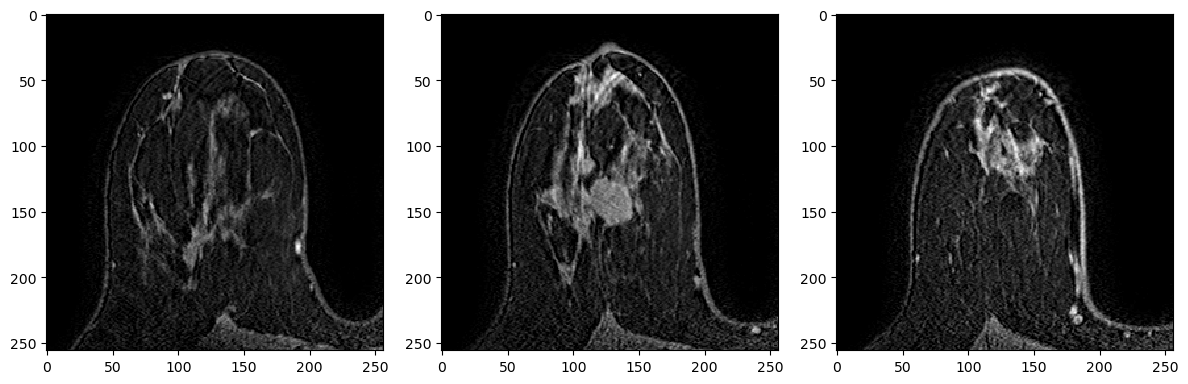

<Figure size 640x480 with 0 Axes>

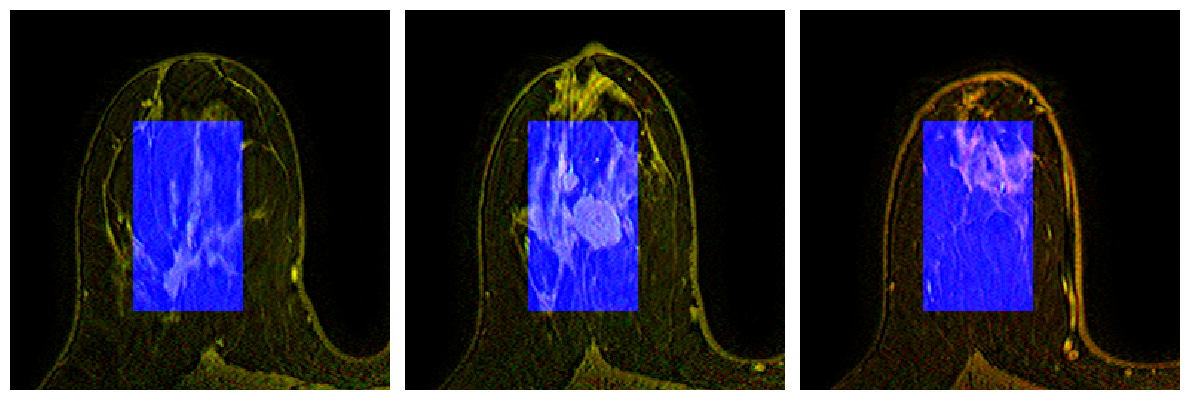

In [101]:
idx=[voi[0][0]+1,(voi[0][0]+voi[0][1])//2, voi[0][1]-1]
print(idx, [c-crop_coords[0] for c in idx])
show_n_images([ca0[k-crop_coords[0]] for k in idx], axis_off=False)
show_n_images([np.stack([minmax(ca0[k-crop_coords[0]]) ,
                            minmax(ca1[k-crop_coords[0]]) ,
                            cm[k-crop_coords[0]]],axis=2 ) for k in idx])




In [ ]:
fpath="C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\min_dce_5"

In [86]:
fpath="C:\\Users\\naomi\\Downloads\\breast_mri\\duke\\min_dce"

In [68]:
fpath="G:\\My Drive\\breast_mri\\DUKE\min_dce"

In [69]:
df=pd.read_csv('../ISPY2/BreastDCEDL_spy2_tcia_metadata.csv')

In [70]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]

In [71]:
r['pre'],r['post_early'],r['post_late'],r['n_times']

(0.0, 2.0, 6.0, 7.0)

In [ ]:
df.shape

In [ ]:
df_crop.tail()

In [ ]:
pp=['ISPY1_1212', 'ISPY1_1228','ISPY1_1184', 'ISPY1_1104']

In [ ]:
pp=['ISPY1_1212', 'ISPY1_1228','ISPY1_1184', 'ISPY1_1104']
pp

## crop to min dce

In [ ]:
df.info()

In [ ]:
df.columns

In [64]:
nfpath="../../breast_mri/SPY2/nifti_slice"

In [65]:
!mkdir ..\\..\\breast_mri\\SPY2\\nifti_slice

A subdirectory or file ..\\..\\breast_mri\\SPY2\\nifti_slice already exists.


In [52]:
!mkdir "C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\min_dce"

A subdirectory or file C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\min_dce already exists.


In [72]:
fpath="G:\\My Drive\\breast_mri\\SPY2\\vis1\\min_dce"

In [79]:
df[df.pid=='ISPY2-796558']

pid         Arm  HR  HER2  MP  pCR   age   Race  \
958  ISPY2-796558  Paclitaxel   0     0   0    0  38.0  White   

                                     menopausal_status  e_hispanic_latino  \
958  (<6 months since LMP AND no prior bilateral ov...                0.0   

     ... xy_spacing  mask_start  mask_end  mask_count  is_mask  sraw   eraw  \
958  ...   0.703125        69.0     103.0     19053.0      1.0  75.0  203.0   

     scol   ecol  test  
958  83.0  158.0   0.0  

[1 rows x 49 columns]

## create min dir

In [80]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'n_z']:
    df_crop['org_'+c]=df[c]
data_path='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'

In [81]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df_crop.iterrows():
        
        pid =  row['pid']
        if pid!='ISPY2-796558': continue
            
        a=get_all_nifti_acquisitions(pid,
                                     "C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\min_dce")
        #"G:\\My Drive\\breast_mri\\SPY2\\vis1\\min_dec")
         
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        print(startm,endm)
        newstart = startm-1
        newend=endm+2
        
        if startm<=1:
            newstart = startm
        if endm==a0.shape[0]:
            newend=endm
        if endm+1==a0.shape[0]:
            newend=endm+1
        if endm+2==a0.shape[0]:
            newend=endm+2
        
        df_crop.at[i,'mask_start'] = startm-newstart
        df_crop.at[i,'mask_end'] = endm-newend
        df_crop.at[i,'n_z'] = newend-newstart-1
        
        print('saving:', a0[newstart:newend].squeeze().shape)
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i0))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),a0[newstart:newend].squeeze())
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i1))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),a1[newstart:newend].squeeze())
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i2))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),a2[newstart:newend].squeeze())
        print('saving:',os.path.join(fpath, fn))
        

69 103
saving: (37, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\min_dce\ISPY2-796558_spy2_vis1_dce_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\SPY2\vis1\min_dce\ISPY2-796558_spy2_vis1_dce_aqc_2.nii.gz
saving: G:\My Drive\breast_mri\SPY2\vis1\min_dce\ISPY2-796558_spy2_vis1_dce_aqc_6.nii.gz


In [34]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             982 non-null    object 
 1   pCR             982 non-null    float64
 2   n_xy            982 non-null    float64
 3   n_z             982 non-null    float64
 4   n_times         982 non-null    float64
 5   pre             982 non-null    float64
 6   post_early      982 non-null    float64
 7   post_late       982 non-null    float64
 8   slice_thick     982 non-null    float64
 9   xy_spacing      982 non-null    float64
 10  mask_start      982 non-null    float64
 11  mask_end        982 non-null    float64
 12  sraw            982 non-null    float64
 13  eraw            982 non-null    float64
 14  scol            982 non-null    float64
 15  ecol            982 non-null    float64
 16  tum_vol         982 non-null    float64
 17  age             982 non-null    flo

In [35]:
dd=pd.read_csv('../BreastDCEDL_metadata_min.csv')
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2072 non-null   object 
 1   pCR             1432 non-null   float64
 2   n_xy            2072 non-null   float64
 3   n_z             2072 non-null   float64
 4   n_times         2072 non-null   float64
 5   pre             2072 non-null   float64
 6   post_early      2072 non-null   float64
 7   post_late       2072 non-null   float64
 8   slice_thick     2072 non-null   float64
 9   xy_spacing      2072 non-null   float64
 10  mask_start      2072 non-null   float64
 11  mask_end        2072 non-null   float64
 12  sraw            2072 non-null   float64
 13  eraw            2072 non-null   float64
 14  scol            2072 non-null   float64
 15  ecol            2072 non-null   float64
 16  tum_vol         2071 non-null   float64
 17  age             2072 non-null   f

In [39]:
dd=pd.concat([dd[dd.dataset!='spy2'], df_crop[dd.columns]],axis=0)
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 982 to 981
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2072 non-null   object 
 1   pCR             1432 non-null   float64
 2   n_xy            2072 non-null   float64
 3   n_z             2072 non-null   float64
 4   n_times         2072 non-null   float64
 5   pre             2072 non-null   float64
 6   post_early      2072 non-null   float64
 7   post_late       2072 non-null   float64
 8   slice_thick     2072 non-null   float64
 9   xy_spacing      2072 non-null   float64
 10  mask_start      2072 non-null   float64
 11  mask_end        2072 non-null   float64
 12  sraw            2072 non-null   float64
 13  eraw            2072 non-null   float64
 14  scol            2072 non-null   float64
 15  ecol            2072 non-null   float64
 16  tum_vol         2071 non-null   float64
 17  age             2072 non-null   

In [ ]:
dd.to_csv('../BreastDCEDL_metadata_min.csv', index = False)

In [101]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]
data_path='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'

In [ ]:
df.to_csv('df_spy2_min_metadata.csv', index = False)

## crop to 256x256 all acquisitions

In [67]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df[df.n_xy==256].iterrows():
        
        pid =  row['pid']
            
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a=get_all_nifti_acquisitions(pid, "G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce_org")
         
        print(len(a),a[0].shape,a[1].shape)
        a0=a[0]  
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1, output_size=256)
        print('====crop', crop_coords)
        print(a0.shape)
        print(startm,endm)
       
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row
        #a0=ds.get_nifti_acquisition(pid, idx=0)
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        a1=a[i1]
        a2=a[i2]

        if row['n_xy']<256:
            c=[]
            crop_coords=np.array(crop_coords)
            crop_coords[2]=0
            crop_coords[3]=256
            crop_coords[4]=0
            crop_coords[5]=256
            c0=[]
            c1=[]
            c2=[]
            for h in range(a0.shape[0]):
                img=a0[h]
                       
                c0.append(cv2.resize(a0[h], (256, 256), interpolation=cv2.INTER_AREA) )
                c1.append(cv2.resize(a1[h], (256, 256), interpolation=cv2.INTER_AREA) )
                c2.append(cv2.resize(a2[h], (256, 256), interpolation=cv2.INTER_AREA) )
                        
            ca0=np.array(c0)
            ca1=np.array(c1)
            ca2=np.array(c2)
           
        else:
            ca0 = crop_with_same_coordinates(a0, crop_coords)
            ca1 = crop_with_same_coordinates(a1, crop_coords)
            ca2 = crop_with_same_coordinates(a2, crop_coords)
        c = [ca1,ca1,ca2]
        
        print('saving:', ca0.shape)
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i0))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca0)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i1))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca1)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_spy2_vis1_dce_aqc_'+str(int(i2))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca2)
        print('saving:',os.path.join(fpath, fn))
        
        df_crop.at[i, 'maxdcm0']=c[0].max()
        df_crop.at[i, 'maxdcm1']=c[1].max()
        df_crop.at[i, 'maxdcm0']=c[2].max()
        df_crop.at[i, 'meandcm0']=c[0].mean()
        df_crop.at[i, 'meandcm1']=c[1].mean()
        df_crop.at[i, 'meandcm0']=c[2].mean()
        df_crop.at[i, 'nunq0']=len(set(c[0].flatten()))
        df_crop.at[i, 'nunq1']=len(set(c[0].flatten()))
        df_crop.at[i, 'nunq0']=len(set(c[0].flatten()))
        
        mstart= startm-crop_coords[0]
        mend= endm-crop_coords[0]
        f=max(0,mstart-1)
        l=min(mend+1, c[0].shape[0])
        for jj in range(f,l):
            dce=np.stack([c[0][jj],c[1][jj],c[2][jj]],axis=2)
            os.makedirs(os.path.join(nfpath,pid), exist_ok=True)

            fn=pid+'_spy2_slc_'+str(jj)+'.nii.gz'
            save_niftii(os.path.join(nfpath,pid,fn), dce)
            
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = ca0.shape[0]
                                   
        df_crop.to_csv('../../breast_mri/SPY2/df_crop_min_spy2.csv', index = False)
                                   

0 ISPY2-756412 3.0 46.0
7 (76, 256, 256) (76, 256, 256)
0 --- ISPY2-756412 (76, 256, 256)
====crop (2, 47, 0, 255, 0, 255)
(76, 256, 256)
3 46
saving: (46, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-756412_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-756412_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-756412_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
1 ISPY2-111881 68.0 105.0
6 (134, 256, 256) (134, 256, 256)
1 --- ISPY2-111881 (134, 256, 256)
====crop (67, 106, 0, 255, 0, 255)
(134, 256, 256)
68 105
saving: (40, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111881_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111881_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111881_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
2 ISPY2-451816 17.0 64.0
8 (80, 256, 256) (80, 256, 25

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-605713_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-605713_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-605713_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
20 ISPY2-246134 53.0 99.0
7 (160, 256, 256) (160, 256, 256)
20 --- ISPY2-246134 (160, 256, 256)
====crop (52, 100, 0, 255, 0, 255)
(160, 256, 256)
53 99
saving: (49, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-246134_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-246134_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-246134_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
21 ACRIN-6698-373346 30.0 60.0
7 (72, 256, 256) (72, 256, 256)
21 --- ACRIN-6698-373346 (72, 256, 256)
====crop (29, 61, 0, 255, 0, 255)
(72, 256, 256)
30 60
saving: (33, 256, 256)
saving: C:\Users\naomi\Downloads\breast

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-597873_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-597873_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
42 ISPY2-111646 25.0 64.0
8 (80, 256, 256) (80, 256, 256)
42 --- ISPY2-111646 (80, 256, 256)
====crop (24, 65, 0, 255, 0, 255)
(80, 256, 256)
25 64
saving: (42, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111646_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111646_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-111646_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
43 ISPY2-574091 13.0 24.0
8 (80, 256, 256) (80, 256, 256)
43 --- ISPY2-574091 (80, 256, 256)
====crop (12, 25, 0, 255, 0, 255)
(80, 256, 256)
13 24
saving: (14, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-574091_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_d

ser: 0 2 5
64 ACRIN-6698-753109 38.0 75.0
8 (80, 256, 256) (80, 256, 256)
64 --- ACRIN-6698-753109 (80, 256, 256)
====crop (37, 76, 0, 255, 0, 255)
(80, 256, 256)
38 75
saving: (40, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-753109_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-753109_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-753109_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
66 ISPY2-494946 42.0 73.0
9 (80, 256, 256) (80, 256, 256)
66 --- ISPY2-494946 (80, 256, 256)
====crop (41, 74, 0, 255, 0, 255)
(80, 256, 256)
42 73
saving: (34, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-494946_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-494946_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-494946_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
67 ISPY2-326202 62

ser: 0 2 5
88 ISPY2-672734 35.0 59.0
8 (80, 256, 256) (80, 256, 256)
88 --- ISPY2-672734 (80, 256, 256)
====crop (34, 60, 0, 255, 0, 255)
(80, 256, 256)
35 59
saving: (27, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-672734_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-672734_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-672734_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
89 ISPY2-922872 12.0 27.0
7 (66, 256, 256) (66, 256, 256)
89 --- ISPY2-922872 (66, 256, 256)
====crop (11, 28, 0, 255, 0, 255)
(66, 256, 256)
12 27
saving: (18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-922872_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-922872_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-922872_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
90 ACRIN-6698-522140 26.0 53.0
7 (72, 256, 

ser: 0 2 6
107 ISPY2-554577 19.0 58.0
8 (80, 256, 256) (80, 256, 256)
107 --- ISPY2-554577 (80, 256, 256)
====crop (18, 59, 0, 255, 0, 255)
(80, 256, 256)
19 58
saving: (42, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-554577_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-554577_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-554577_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
108 ISPY2-570685 25.0 38.0
7 (72, 256, 256) (72, 256, 256)
108 --- ISPY2-570685 (72, 256, 256)
====crop (24, 39, 0, 255, 0, 255)
(72, 256, 256)
25 38
saving: (16, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-570685_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-570685_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-570685_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
109 ISPY2-986734 26.0 126.0
7 (160, 256

6 (134, 256, 256) (134, 256, 256)
124 --- ISPY2-625854 (134, 256, 256)
====crop (11, 76, 0, 255, 0, 255)
(134, 256, 256)
12 75
saving: (66, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-625854_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-625854_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-625854_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
126 ACRIN-6698-152090 19.0 47.0
7 (80, 256, 256) (80, 256, 256)
126 --- ACRIN-6698-152090 (80, 256, 256)
====crop (18, 48, 0, 255, 0, 255)
(80, 256, 256)
19 47
saving: (31, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-152090_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-152090_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-152090_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
127 ISPY2-735673 6.0 46.0
7 (66, 256, 256) (66, 

ser: 0 2 6
147 ACRIN-6698-963604 25.0 65.0
7 (72, 256, 256) (72, 256, 256)
147 --- ACRIN-6698-963604 (72, 256, 256)
====crop (24, 66, 0, 255, 0, 255)
(72, 256, 256)
25 65
saving: (43, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-963604_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-963604_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-963604_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
148 ISPY2-571276 23.0 57.0
7 (72, 256, 256) (72, 256, 256)
148 --- ISPY2-571276 (72, 256, 256)
====crop (22, 58, 0, 255, 0, 255)
(72, 256, 256)
23 57
saving: (37, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-571276_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-571276_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-571276_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
149 ACRIN-6698

ser: 0 2 6
167 ISPY2-981664 43.0 74.0
7 (160, 256, 256) (160, 256, 256)
167 --- ISPY2-981664 (160, 256, 256)
====crop (42, 75, 0, 255, 0, 255)
(160, 256, 256)
43 74
saving: (34, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-981664_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-981664_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-981664_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
168 ISPY2-683173 17.0 39.0
8 (80, 256, 256) (80, 256, 256)
168 --- ISPY2-683173 (80, 256, 256)
====crop (16, 40, 0, 255, 0, 255)
(80, 256, 256)
17 39
saving: (25, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-683173_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-683173_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-683173_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
169 ISPY2-102011 32.0 51.0
7 (72, 2

ser: 0 2 5
186 ACRIN-6698-432114 22.0 52.0
6 (134, 256, 256) (134, 256, 256)
186 --- ACRIN-6698-432114 (134, 256, 256)
====crop (21, 53, 0, 255, 0, 255)
(134, 256, 256)
22 52
saving: (33, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-432114_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-432114_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-432114_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
187 ISPY2-804233 31.0 56.0
7 (72, 256, 256) (72, 256, 256)
187 --- ISPY2-804233 (72, 256, 256)
====crop (30, 57, 0, 255, 0, 255)
(72, 256, 256)
31 56
saving: (28, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-804233_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-804233_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-804233_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
188 ACRIN-

ser: 0 2 6
212 ACRIN-6698-786753 34.0 107.0
7 (158, 256, 256) (158, 256, 256)
212 --- ACRIN-6698-786753 (158, 256, 256)
====crop (33, 108, 0, 255, 0, 255)
(158, 256, 256)
34 107
saving: (76, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-786753_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-786753_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-786753_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
214 ISPY2-510543 9.0 44.0
6 (134, 256, 256) (134, 256, 256)
214 --- ISPY2-510543 (134, 256, 256)
====crop (8, 45, 0, 255, 0, 255)
(134, 256, 256)
9 44
saving: (38, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-510543_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-510543_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-510543_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
215 IS

ser: 0 2 6
237 ISPY2-177795 19.0 37.0
7 (66, 256, 256) (66, 256, 256)
237 --- ISPY2-177795 (66, 256, 256)
====crop (18, 38, 0, 255, 0, 255)
(66, 256, 256)
19 37
saving: (21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-177795_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-177795_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-177795_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
238 ACRIN-6698-685795 20.0 51.0
6 (134, 256, 256) (134, 256, 256)
238 --- ACRIN-6698-685795 (134, 256, 256)
====crop (19, 52, 0, 255, 0, 255)
(134, 256, 256)
20 51
saving: (34, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-685795_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-685795_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-685795_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
239 ACRIN-

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-628788_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
256 ACRIN-6698-882553 5.0 66.0
8 (80, 256, 256) (80, 256, 256)
256 --- ACRIN-6698-882553 (80, 256, 256)
====crop (4, 67, 0, 255, 0, 255)
(80, 256, 256)
5 66
saving: (64, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-882553_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-882553_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-882553_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
259 ISPY2-845147 44.0 85.0
6 (134, 256, 256) (134, 256, 256)
259 --- ISPY2-845147 (134, 256, 256)
====crop (43, 86, 0, 255, 0, 255)
(134, 256, 256)
44 85
saving: (44, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-845147_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-845147_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\na

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-748611_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
280 ACRIN-6698-689076 18.0 50.0
7 (64, 256, 256) (64, 256, 256)
280 --- ACRIN-6698-689076 (64, 256, 256)
====crop (17, 51, 0, 255, 0, 255)
(64, 256, 256)
18 50
saving: (35, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-689076_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-689076_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-689076_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
281 ACRIN-6698-587604 50.0 97.0
7 (158, 256, 256) (158, 256, 256)
281 --- ACRIN-6698-587604 (158, 256, 256)
====crop (49, 98, 0, 255, 0, 255)
(158, 256, 256)
50 97
saving: (50, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-587604_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-587604_spy2_vis1_dce_aqc_2.nii

ser: 0 2 6
306 ISPY2-783771 7.0 22.0
7 (66, 256, 256) (66, 256, 256)
306 --- ISPY2-783771 (66, 256, 256)
====crop (6, 23, 0, 255, 0, 255)
(66, 256, 256)
7 22
saving: (18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-783771_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-783771_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-783771_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
307 ACRIN-6698-293142 26.0 62.0
7 (66, 256, 256) (66, 256, 256)
307 --- ACRIN-6698-293142 (66, 256, 256)
====crop (25, 63, 0, 255, 0, 255)
(66, 256, 256)
26 62
saving: (39, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-293142_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-293142_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-293142_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
308 ACRIN-6698-70

ser: 0 2 6
324 ISPY2-714205 24.0 54.0
7 (80, 256, 256) (80, 256, 256)
324 --- ISPY2-714205 (80, 256, 256)
====crop (23, 55, 0, 255, 0, 255)
(80, 256, 256)
24 54
saving: (33, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-714205_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-714205_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-714205_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
325 ISPY2-635862 20.0 57.0
8 (80, 256, 256) (80, 256, 256)
325 --- ISPY2-635862 (80, 256, 256)
====crop (19, 58, 0, 255, 0, 255)
(80, 256, 256)
20 57
saving: (40, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-635862_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-635862_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-635862_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
327 ISPY2-519738 41.0 56.0
8 (80, 256, 

ser: 0 2 5
345 ISPY2-347516 4.0 22.0
7 (64, 256, 256) (64, 256, 256)
345 --- ISPY2-347516 (64, 256, 256)
====crop (3, 23, 0, 255, 0, 255)
(64, 256, 256)
4 22
saving: (21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-347516_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-347516_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-347516_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
346 ACRIN-6698-399478 40.0 60.0
8 (72, 256, 256) (72, 256, 256)
346 --- ACRIN-6698-399478 (72, 256, 256)
====crop (39, 61, 0, 255, 0, 255)
(72, 256, 256)
40 60
saving: (23, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-399478_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-399478_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-399478_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
348 ISPY2-395249 

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-313243_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
367 ISPY2-701790 52.0 72.0
6 (134, 256, 256) (134, 256, 256)
367 --- ISPY2-701790 (134, 256, 256)
====crop (51, 73, 0, 255, 0, 255)
(134, 256, 256)
52 72
saving: (23, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-701790_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-701790_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-701790_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
368 ISPY2-375455 39.0 62.0
8 (80, 256, 256) (80, 256, 256)
368 --- ISPY2-375455 (80, 256, 256)
====crop (38, 63, 0, 255, 0, 255)
(80, 256, 256)
39 62
saving: (26, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-375455_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-375455_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SP

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-108969_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
389 ACRIN-6698-721099 51.0 89.0
6 (134, 256, 256) (134, 256, 256)
389 --- ACRIN-6698-721099 (134, 256, 256)
====crop (50, 90, 0, 255, 0, 255)
(134, 256, 256)
51 89
saving: (41, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-721099_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-721099_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-721099_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
390 ACRIN-6698-397505 94.0 121.0
6 (134, 256, 256) (134, 256, 256)
390 --- ACRIN-6698-397505 (134, 256, 256)
====crop (93, 122, 0, 255, 0, 255)
(134, 256, 256)
94 121
saving: (30, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-397505_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-397505_spy2_vis1_dce_aq

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-691753_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
413 ISPY2-539904 38.0 57.0
8 (80, 256, 256) (80, 256, 256)
413 --- ISPY2-539904 (80, 256, 256)
====crop (37, 58, 0, 255, 0, 255)
(80, 256, 256)
38 57
saving: (22, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539904_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539904_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539904_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
414 ISPY2-453596 29.0 50.0
8 (72, 256, 256) (72, 256, 256)
414 --- ISPY2-453596 (72, 256, 256)
====crop (28, 51, 0, 255, 0, 255)
(72, 256, 256)
29 50
saving: (24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-453596_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-453596_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\S

ser: 0 2 5
435 ISPY2-282644 45.0 57.0
6 (72, 256, 256) (72, 256, 256)
435 --- ISPY2-282644 (72, 256, 256)
====crop (44, 58, 0, 255, 0, 255)
(72, 256, 256)
45 57
saving: (15, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-282644_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-282644_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-282644_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
436 ISPY2-484867 9.0 63.0
8 (80, 256, 256) (80, 256, 256)
436 --- ISPY2-484867 (80, 256, 256)
====crop (8, 64, 0, 255, 0, 255)
(80, 256, 256)
9 63
saving: (57, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-484867_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-484867_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-484867_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
437 ISPY2-564234 46.0 110.0
6 (134, 256, 2

ser: 0 2 6
457 ISPY2-872188 18.0 38.0
8 (72, 256, 256) (72, 256, 256)
457 --- ISPY2-872188 (72, 256, 256)
====crop (17, 39, 0, 255, 0, 255)
(72, 256, 256)
18 38
saving: (23, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-872188_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-872188_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-872188_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
458 ISPY2-388581 82.0 105.0
5 (116, 256, 256) (116, 256, 256)
458 --- ISPY2-388581 (116, 256, 256)
====crop (81, 106, 0, 255, 0, 255)
(116, 256, 256)
82 105
saving: (26, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-388581_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-388581_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-388581_spy2_vis1_dce_aqc_4.nii.gz
ser: 0 2 4
459 ISPY2-402384 38.0 116.0
7 (1

7 (200, 256, 256) (200, 256, 256)
480 --- ISPY2-267306 (200, 256, 256)
====crop (73, 179, 0, 255, 0, 255)
(200, 256, 256)
74 178
saving: (107, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-267306_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-267306_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-267306_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
482 ISPY2-934906 25.0 66.0
8 (80, 256, 256) (80, 256, 256)
482 --- ISPY2-934906 (80, 256, 256)
====crop (24, 67, 0, 255, 0, 255)
(80, 256, 256)
25 66
saving: (44, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-934906_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-934906_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-934906_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
483 ISPY2-129837 35.0 104.0
6 (134, 256, 256) (134, 256, 256)
483 --- 

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-151230_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-151230_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-151230_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
504 ISPY2-380972 11.0 29.0
8 (80, 256, 256) (80, 256, 256)
504 --- ISPY2-380972 (80, 256, 256)
====crop (10, 30, 0, 255, 0, 255)
(80, 256, 256)
11 29
saving: (21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-380972_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-380972_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-380972_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
505 ISPY2-666450 10.0 60.0
9 (80, 256, 256) (80, 256, 256)
505 --- ISPY2-666450 (80, 256, 256)
====crop (9, 61, 0, 255, 0, 255)
(80, 256, 256)
10 60
saving: (53, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\mi

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-765773_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-765773_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
528 ISPY2-803514 25.0 96.0
6 (134, 256, 256) (134, 256, 256)
528 --- ISPY2-803514 (134, 256, 256)
====crop (24, 97, 0, 255, 0, 255)
(134, 256, 256)
25 96
saving: (74, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-803514_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-803514_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-803514_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
529 ISPY2-202956 16.0 30.0
6 (66, 256, 256) (66, 256, 256)
529 --- ISPY2-202956 (66, 256, 256)
====crop (15, 31, 0, 255, 0, 255)
(66, 256, 256)
16 30
saving: (17, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-202956_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SP

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-496205_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
547 ACRIN-6698-688955 26.0 42.0
7 (72, 256, 256) (72, 256, 256)
547 --- ACRIN-6698-688955 (72, 256, 256)
====crop (25, 43, 0, 255, 0, 255)
(72, 256, 256)
26 42
saving: (19, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-688955_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-688955_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-688955_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
548 ACRIN-6698-700549 31.0 57.0
8 (80, 256, 256) (80, 256, 256)
548 --- ACRIN-6698-700549 (80, 256, 256)
====crop (30, 58, 0, 255, 0, 255)
(80, 256, 256)
31 57
saving: (29, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-700549_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-700549_spy2_vis1_dce_aqc_2.nii.gz
savin

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-196064_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-196064_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
566 ISPY2-335091 45.0 119.0
7 (160, 256, 256) (160, 256, 256)
566 --- ISPY2-335091 (160, 256, 256)
====crop (44, 120, 0, 255, 0, 255)
(160, 256, 256)
45 119
saving: (77, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-335091_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-335091_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-335091_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
570 ACRIN-6698-801641 17.0 80.0
7 (126, 256, 256) (126, 256, 256)
570 --- ACRIN-6698-801641 (126, 256, 256)
====crop (16, 81, 0, 255, 0, 255)
(126, 256, 256)
17 80
saving: (66, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-801641_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Use

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-472799_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-472799_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
591 ISPY2-178649 29.0 44.0
7 (64, 256, 256) (64, 256, 256)
591 --- ISPY2-178649 (64, 256, 256)
====crop (28, 45, 0, 255, 0, 255)
(64, 256, 256)
29 44
saving: (18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-178649_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-178649_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-178649_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
592 ACRIN-6698-928446 36.0 119.0
7 (158, 256, 256) (158, 256, 256)
592 --- ACRIN-6698-928446 (158, 256, 256)
====crop (35, 120, 0, 255, 0, 255)
(158, 256, 256)
36 119
saving: (86, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-928446_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downl

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-916645_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-916645_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
612 ACRIN-6698-899692 18.0 45.0
7 (72, 256, 256) (72, 256, 256)
612 --- ACRIN-6698-899692 (72, 256, 256)
====crop (17, 46, 0, 255, 0, 255)
(72, 256, 256)
18 45
saving: (30, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-899692_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-899692_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-899692_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
613 ISPY2-427321 11.0 45.0
6 (100, 256, 256) (100, 256, 256)
613 --- ISPY2-427321 (100, 256, 256)
====crop (10, 46, 0, 255, 0, 255)
(100, 256, 256)
11 45
saving: (37, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-427321_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naom

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-649198_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-649198_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
631 ISPY2-953262 72.0 118.0
7 (160, 256, 256) (160, 256, 256)
631 --- ISPY2-953262 (160, 256, 256)
====crop (71, 119, 0, 255, 0, 255)
(160, 256, 256)
72 118
saving: (49, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-953262_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-953262_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-953262_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
633 ISPY2-357017 20.0 129.0
7 (134, 256, 256) (134, 256, 256)
633 --- ISPY2-357017 (134, 256, 256)
====crop (19, 130, 0, 255, 0, 255)
(134, 256, 256)
20 129
saving: (112, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-357017_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Do

saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-963303_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-963303_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
654 ACRIN-6698-631299 41.0 54.0
7 (72, 256, 256) (72, 256, 256)
654 --- ACRIN-6698-631299 (72, 256, 256)
====crop (40, 55, 0, 255, 0, 255)
(72, 256, 256)
41 54
saving: (16, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-631299_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-631299_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-631299_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
655 ISPY2-264678 36.0 91.0
6 (134, 256, 256) (134, 256, 256)
655 --- ISPY2-264678 (134, 256, 256)
====crop (35, 92, 0, 255, 0, 255)
(134, 256, 256)
36 91
saving: (58, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-264678_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\

ser: 0 2 5
676 ISPY2-261304 45.0 61.0
8 (80, 256, 256) (80, 256, 256)
676 --- ISPY2-261304 (80, 256, 256)
====crop (44, 62, 0, 255, 0, 255)
(80, 256, 256)
45 61
saving: (19, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-261304_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-261304_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-261304_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
677 ISPY2-941926 29.0 68.0
7 (80, 256, 256) (80, 256, 256)
677 --- ISPY2-941926 (80, 256, 256)
====crop (28, 69, 0, 255, 0, 255)
(80, 256, 256)
29 68
saving: (42, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-941926_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-941926_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-941926_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
678 ISPY2-906042 22.0 108.0
8 (160, 256

ser: 0 2 5
695 ISPY2-515105 12.0 107.0
6 (134, 256, 256) (134, 256, 256)
695 --- ISPY2-515105 (134, 256, 256)
====crop (11, 108, 0, 255, 0, 255)
(134, 256, 256)
12 107
saving: (98, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-515105_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-515105_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-515105_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
696 ISPY2-273745 46.0 98.0
7 (200, 256, 256) (200, 256, 256)
696 --- ISPY2-273745 (200, 256, 256)
====crop (45, 99, 0, 255, 0, 255)
(200, 256, 256)
46 98
saving: (55, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-273745_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-273745_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-273745_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
697 ISPY2-374106 37.0 59.0
6

ser: 0 2 6
716 ISPY2-313672 17.0 32.0
7 (66, 256, 256) (66, 256, 256)
716 --- ISPY2-313672 (66, 256, 256)
====crop (16, 33, 0, 255, 0, 255)
(66, 256, 256)
17 32
saving: (18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-313672_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-313672_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-313672_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
717 ISPY2-500826 15.0 34.0
7 (72, 256, 256) (72, 256, 256)
717 --- ISPY2-500826 (72, 256, 256)
====crop (14, 35, 0, 255, 0, 255)
(72, 256, 256)
15 34
saving: (22, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-500826_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-500826_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-500826_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
720 ACRIN-6698-179369 14.0 66.0
8 (80, 

ser: 0 2 6
737 ISPY2-994987 29.0 51.0
7 (72, 256, 256) (72, 256, 256)
737 --- ISPY2-994987 (72, 256, 256)
====crop (28, 52, 0, 255, 0, 255)
(72, 256, 256)
29 51
saving: (25, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-994987_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-994987_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-994987_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
738 ISPY2-360937 7.0 68.0
8 (80, 256, 256) (80, 256, 256)
738 --- ISPY2-360937 (80, 256, 256)
====crop (6, 69, 0, 255, 0, 255)
(80, 256, 256)
7 68
saving: (64, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-360937_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-360937_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-360937_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
739 ISPY2-357034 18.0 34.0
7 (64, 256, 256

ser: 0 2 6
758 ISPY2-489504 17.0 72.0
8 (80, 256, 256) (80, 256, 256)
758 --- ISPY2-489504 (80, 256, 256)
====crop (16, 73, 0, 255, 0, 255)
(80, 256, 256)
17 72
saving: (58, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-489504_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-489504_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-489504_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
759 ISPY2-845079 48.0 60.0
7 (66, 256, 256) (66, 256, 256)
759 --- ISPY2-845079 (66, 256, 256)
====crop (47, 61, 0, 255, 0, 255)
(66, 256, 256)
48 60
saving: (15, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-845079_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-845079_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-845079_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
760 ISPY2-234272 33.0 63.0
8 (80, 256, 

6 (134, 256, 256) (134, 256, 256)
779 --- ACRIN-6698-734997 (134, 256, 256)
====crop (25, 93, 0, 255, 0, 255)
(134, 256, 256)
26 92
saving: (69, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-734997_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-734997_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-734997_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
780 ACRIN-6698-792181 61.0 77.0
8 (80, 256, 256) (80, 256, 256)
780 --- ACRIN-6698-792181 (80, 256, 256)
====crop (60, 78, 0, 255, 0, 255)
(80, 256, 256)
61 77
saving: (19, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-792181_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-792181_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-792181_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
782 ACRIN-6698-467686 51.0 7

ser: 0 2 6
801 ISPY2-539291 17.0 57.0
7 (76, 256, 256) (76, 256, 256)
801 --- ISPY2-539291 (76, 256, 256)
====crop (16, 58, 0, 255, 0, 255)
(76, 256, 256)
17 57
saving: (43, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539291_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539291_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-539291_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
802 ISPY2-341238 44.0 59.0
9 (80, 256, 256) (80, 256, 256)
802 --- ISPY2-341238 (80, 256, 256)
====crop (43, 60, 0, 255, 0, 255)
(80, 256, 256)
44 59
saving: (18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-341238_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-341238_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-341238_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
803 ISPY2-759015 13.0 28.0
8 (80, 256, 

8 (80, 256, 256) (80, 256, 256)
822 --- ISPY2-318569 (80, 256, 256)
====crop (37, 78, 0, 255, 0, 255)
(80, 256, 256)
38 77
saving: (42, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-318569_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-318569_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-318569_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
823 ISPY2-819622 21.0 58.0
9 (80, 256, 256) (80, 256, 256)
823 --- ISPY2-819622 (80, 256, 256)
====crop (20, 59, 0, 255, 0, 255)
(80, 256, 256)
21 58
saving: (40, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-819622_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-819622_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-819622_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
824 ISPY2-600536 5.0 67.0
7 (80, 256, 256) (80, 256, 256)
824 --- ISPY2-60053

8 (80, 256, 256) (80, 256, 256)
845 --- ACRIN-6698-233191 (80, 256, 256)
====crop (11, 67, 0, 255, 0, 255)
(80, 256, 256)
12 66
saving: (57, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-233191_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-233191_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-233191_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
847 ACRIN-6698-407539 14.0 59.0
7 (80, 256, 256) (80, 256, 256)
847 --- ACRIN-6698-407539 (80, 256, 256)
====crop (13, 60, 0, 255, 0, 255)
(80, 256, 256)
14 59
saving: (48, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-407539_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-407539_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-407539_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
849 ACRIN-6698-895653 38.0 56.0


7 (160, 256, 256) (160, 256, 256)
869 --- ISPY2-303947 (160, 256, 256)
====crop (92, 125, 0, 255, 0, 255)
(160, 256, 256)
93 124
saving: (34, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-303947_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-303947_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-303947_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
870 ISPY2-766967 54.0 98.0
6 (134, 256, 256) (134, 256, 256)
870 --- ISPY2-766967 (134, 256, 256)
====crop (53, 99, 0, 255, 0, 255)
(134, 256, 256)
54 98
saving: (47, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-766967_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-766967_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-766967_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
871 ISPY2-726381 38.0 85.0
6 (134, 256, 256) (134, 256, 256)
871 --

7 (80, 256, 256) (80, 256, 256)
891 --- ISPY2-238790 (80, 256, 256)
====crop (29, 55, 0, 255, 0, 255)
(80, 256, 256)
30 54
saving: (27, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-238790_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-238790_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-238790_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
892 ISPY2-327142 32.0 65.0
7 (80, 256, 256) (80, 256, 256)
892 --- ISPY2-327142 (80, 256, 256)
====crop (31, 66, 0, 255, 0, 255)
(80, 256, 256)
32 65
saving: (36, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-327142_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-327142_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-327142_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
894 ISPY2-726940 34.0 72.0
8 (80, 256, 256) (80, 256, 256)
894 --- ISPY2-7269

6 (80, 256, 256) (80, 256, 256)
919 --- ISPY2-579881 (80, 256, 256)
====crop (9, 34, 0, 255, 0, 255)
(80, 256, 256)
10 33
saving: (26, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-579881_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-579881_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-579881_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
920 ACRIN-6698-162562 37.0 55.0
8 (80, 256, 256) (80, 256, 256)
920 --- ACRIN-6698-162562 (80, 256, 256)
====crop (36, 56, 0, 255, 0, 255)
(80, 256, 256)
37 55
saving: (21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-162562_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-162562_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-162562_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
921 ACRIN-6698-687288 21.0 74.0
7 (158, 256, 256) (15

ser: 0 2 5
939 ISPY2-223526 37.0 60.0
8 (80, 256, 256) (80, 256, 256)
939 --- ISPY2-223526 (80, 256, 256)
====crop (36, 61, 0, 255, 0, 255)
(80, 256, 256)
37 60
saving: (26, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-223526_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-223526_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-223526_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
941 ISPY2-172283 25.0 57.0
9 (64, 256, 256) (64, 256, 256)
941 --- ISPY2-172283 (64, 256, 256)
====crop (24, 58, 0, 255, 0, 255)
(64, 256, 256)
25 57
saving: (35, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-172283_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-172283_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-172283_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
942 ISPY2-720065 27.0 58.0
9 (80, 256, 

8 (80, 256, 256) (80, 256, 256)
961 --- ACRIN-6698-765671 (80, 256, 256)
====crop (41, 65, 0, 255, 0, 255)
(80, 256, 256)
42 64
saving: (25, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-765671_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-765671_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ACRIN-6698-765671_spy2_vis1_dce_aqc_6.nii.gz
ser: 0 2 6
962 ISPY2-990443 34.0 70.0
7 (124, 256, 256) (124, 256, 256)
962 --- ISPY2-990443 (124, 256, 256)
====crop (33, 71, 0, 255, 0, 255)
(124, 256, 256)
34 70
saving: (39, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-990443_spy2_vis1_dce_aqc_0.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-990443_spy2_vis1_dce_aqc_2.nii.gz
saving: C:\Users\naomi\Downloads\breast_mri\SPY2\min_dce\ISPY2-990443_spy2_vis1_dce_aqc_5.nii.gz
ser: 0 2 5
963 ACRIN-6698-384830 33.0 72.0
8 (80, 256, 256) (80,

ser: 0 2 5


In [162]:
import cv2

In [181]:
df=pd.read_csv('../BreastDCEDL_metadata.csv')
df=df[df.dataset=='spy2']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 982 entries, 0 to 981
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             982 non-null    object 
 1   pCR             982 non-null    float64
 2   n_xy            982 non-null    float64
 3   n_z             982 non-null    float64
 4   n_times         982 non-null    float64
 5   pre             982 non-null    float64
 6   post_early      982 non-null    float64
 7   post_late       982 non-null    float64
 8   slice_thick     982 non-null    float64
 9   xy_spacing      982 non-null    float64
 10  mask_start      982 non-null    float64
 11  mask_end        982 non-null    float64
 12  sraw            982 non-null    float64
 13  eraw            982 non-null    float64
 14  scol            982 non-null    float64
 15  ecol            982 non-null    float64
 16  tum_vol         982 non-null    float64
 17  age             982 non-null    float64


In [182]:
fpath='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'
!mkdir = "G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce"

A subdirectory or file G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce already exists.


In [181]:
def get_vis1_nifti_mask(pid, fpath):
    
    #fpath=mask_path[dataset]
    mask_acq_ext='_spy1_vis1_mask'
    fname = os.path.join(fpath,pid + mask_acq_ext + '.nii.gz')
    if not os.path.isfile(fname):
        print('no',fname)
        return None
    m=read_niftii(fname)
    return m

In [183]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]
data_path='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'

In [190]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df.iterrows():
        
        pid =  row['pid']
            
        if row['n_xy']==256:
            continue
            
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a=get_all_nifti_acquisitions(pid,"G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce_org")
         
        print(len(a),a[0].shape,a[1].shape)
        a0=a[0]  
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1, output_size=256)
        print('====crop', crop_coords)
        print(a0.shape)
        print(startm,endm)
       
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row

        c = []
        
        if row['n_xy']<256:
            
            crop_coords=np.array(crop_coords)
            crop_coords[2]=0
            crop_coords[3]=256
            crop_coords[4]=0
            crop_coords[5]=256
            
            for ii in range(len(a)):
                cll=[]
                for h in range(a[0].shape[0]):
                    
                    img=a[ii][h]
                    cll.append(cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) )
                     
                c.append(np.array(cll))
            c=np.array(c)
           
        else:
                         
            for ii in range(len(a)):
                cll=[]
                #for h in range(a[0].shape[0]):
                    
                img=a[ii]
                cll.append(crop_with_same_coordinates(img, crop_coords) )
                     
                c.append(np.array(cll))
            c=np.array(c)
        
        print('saving:', c.shape)
        for ii in range(len(a)):
                         
            fn = pid+'_spy2_vis1_dce_aqc_'+str(int(ii))+'.nii.gz'
            save_niftii(os.path.join(fpath, fn),c[ii].squeeze())
            print('saving:',os.path.join(fpath, fn), c[ii].squeeze().shape)
        
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        
        df_crop.at[i, 'maxdcm0']=c[i0].max()
        df_crop.at[i, 'maxdcm1']=c[i1].max()
        df_crop.at[i, 'maxdcm0']=c[i2].max()
        df_crop.at[i, 'meandcm0']=c[i0].mean()
        df_crop.at[i, 'meandcm1']=c[i1].mean()
        df_crop.at[i, 'meandcm0']=c[i2].mean()
        df_crop.at[i, 'nunq0']=len(set(c[i0].flatten()))
        df_crop.at[i, 'nunq1']=len(set(c[i1].flatten()))
        df_crop.at[i, 'nunq0']=len(set(c[i2].flatten()))
        
        '''mstart= startm-crop_coords[0]
        mend= endm-crop_coords[0]
        f=max(0,mstart-1)
        l=min(mend+1, c[0].shape[0])
        for jj in range(f,l):
            dce=np.stack([c[0][jj],c[1][jj],c[2][jj]],axis=2)
            os.makedirs(os.path.join(nfpath,pid), exist_ok=True)

            fn=pid+'_spy2_slc_'+str(jj)+'.nii.gz'
            save_niftii(os.path.join(nfpath,pid,fn), dce)'''
            
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = c[0].shape[0]
                                   
        df_crop.to_csv('../../breast_mri/SPY2/df_crop_to256_spy2.csv', index = False)
                                   

22 ACRIN-6698-172366 13.0 39.0
7 (64, 320, 320) (64, 320, 320)
22 --- ACRIN-6698-172366 (64, 320, 320)
====crop (12, 40, 0, 255, 64, 319)
(64, 320, 320)
13 39
saving: (7, 1, 29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_0.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_1.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_2.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_3.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_4.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_5.nii.gz (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-172366_spy2_vis1_dce_aqc_6.nii.gz (29, 256, 256)
ser: 0 2 5
34 ACRIN-6698-220471 60.0 86.0
7 (160, 384, 384) (160, 384, 384)
3

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-378885_spy2_vis1_dce_aqc_4.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-378885_spy2_vis1_dce_aqc_5.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-378885_spy2_vis1_dce_aqc_6.nii.gz (28, 256, 256)
ser: 0 2 5
115 ACRIN-6698-511851 18.0 41.0
7 (80, 312, 312) (80, 312, 312)
115 --- ACRIN-6698-511851 (80, 312, 312)
====crop (17, 42, 0, 255, 35, 290)
(80, 312, 312)
18 41
saving: (7, 1, 26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-511851_spy2_vis1_dce_aqc_0.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-511851_spy2_vis1_dce_aqc_1.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-511851_spy2_vis1_dce_aqc_2.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-511851_spy2_vis1_dce_aqc_3.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-511851_s

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-794128_spy2_vis1_dce_aqc_2.nii.gz (37, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-794128_spy2_vis1_dce_aqc_3.nii.gz (37, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-794128_spy2_vis1_dce_aqc_4.nii.gz (37, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-794128_spy2_vis1_dce_aqc_5.nii.gz (37, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-794128_spy2_vis1_dce_aqc_6.nii.gz (37, 256, 256)
ser: 0 2 5
222 ACRIN-6698-863161 66.0 107.0
7 (160, 384, 384) (160, 384, 384)
222 --- ACRIN-6698-863161 (160, 384, 384)
====crop (65, 108, 37, 292, 0, 255)
(160, 384, 384)
66 107
saving: (7, 1, 44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-863161_spy2_vis1_dce_aqc_0.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-863161_spy2_vis1_dce_aqc_1.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ACRIN-6698-8

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_2.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_3.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_4.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_5.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_6.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-111674_spy2_vis1_dce_aqc_7.nii.gz (41, 256, 256)
ser: 0 2 6
281 ISPY2-112606 60.0 117.0
7 (160, 384, 384) (160, 384, 384)
281 --- ISPY2-112606 (160, 384, 384)
====crop (59, 118, 41, 296, 128, 383)
(160, 384, 384)
60 117
saving: (7, 1, 60, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-112606_spy2_vis1_dce_aqc_0.nii.gz (60, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-112606_spy2_vis1_dce_aqc_1.nii.gz (60, 256, 256)


saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-139771_spy2_vis1_dce_aqc_3.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-139771_spy2_vis1_dce_aqc_4.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-139771_spy2_vis1_dce_aqc_5.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-139771_spy2_vis1_dce_aqc_6.nii.gz (36, 256, 256)
ser: 0 2 6
313 ISPY2-145513 49.0 98.0
7 (160, 384, 384) (160, 384, 384)
313 --- ISPY2-145513 (160, 384, 384)
====crop (48, 99, 34, 289, 128, 383)
(160, 384, 384)
49 98
saving: (7, 1, 52, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-145513_spy2_vis1_dce_aqc_0.nii.gz (52, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-145513_spy2_vis1_dce_aqc_1.nii.gz (52, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-145513_spy2_vis1_dce_aqc_2.nii.gz (52, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-145513_spy2_vis1_dce_aqc_3.nii.gz (52, 256, 256)
sav

ser: 0 2 5
360 ISPY2-201831 22.0 45.0
6 (150, 320, 320) (150, 320, 320)
360 --- ISPY2-201831 (150, 320, 320)
====crop (21, 46, 64, 319, 24, 279)
(150, 320, 320)
22 45
saving: (6, 1, 26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_0.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_1.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_2.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_3.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_4.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-201831_spy2_vis1_dce_aqc_5.nii.gz (26, 256, 256)
ser: 0 2 5
366 ISPY2-208265 61.0 131.0
6 (160, 384, 384) (160, 384, 384)
366 --- ISPY2-208265 (160, 384, 384)
====crop (60, 132, 35, 290, 0, 255)
(160, 384, 384)
61 131
saving: (6, 1, 73, 256, 256)
saving

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_1.nii.gz (71, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_2.nii.gz (71, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_3.nii.gz (71, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_4.nii.gz (71, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_5.nii.gz (71, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-239061_spy2_vis1_dce_aqc_6.nii.gz (71, 256, 256)
ser: 0 2 5
405 ISPY2-252748 37.0 84.0
7 (160, 384, 384) (160, 384, 384)
405 --- ISPY2-252748 (160, 384, 384)
====crop (36, 85, 86, 341, 128, 383)
(160, 384, 384)
37 84
saving: (7, 1, 50, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-252748_spy2_vis1_dce_aqc_0.nii.gz (50, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-252748_spy2_vis1_dce_aqc_1.nii.gz (50, 256, 256)
sav

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-301968_spy2_vis1_dce_aqc_3.nii.gz (35, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-301968_spy2_vis1_dce_aqc_4.nii.gz (35, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-301968_spy2_vis1_dce_aqc_5.nii.gz (35, 256, 256)
ser: 0 2 5
451 ISPY2-318293 36.0 53.0
7 (72, 320, 320) (72, 320, 320)
451 --- ISPY2-318293 (72, 320, 320)
====crop (35, 54, 0, 255, 11, 266)
(72, 320, 320)
36 53
saving: (7, 1, 20, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-318293_spy2_vis1_dce_aqc_0.nii.gz (20, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-318293_spy2_vis1_dce_aqc_1.nii.gz (20, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-318293_spy2_vis1_dce_aqc_2.nii.gz (20, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-318293_spy2_vis1_dce_aqc_3.nii.gz (20, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-318293_spy2_vis1_dce_aqc_4.nii.gz (20, 256, 256)
saving: G

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-350331_spy2_vis1_dce_aqc_5.nii.gz (53, 256, 256)
ser: 0 2 5
482 ISPY2-356399 1.0 51.0
6 (134, 312, 312) (134, 312, 312)
482 --- ISPY2-356399 (134, 312, 312)
====crop (0, 52, 56, 311, 49, 304)
(134, 312, 312)
1 51
saving: (6, 1, 53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_0.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_1.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_2.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_3.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_4.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-356399_spy2_vis1_dce_aqc_5.nii.gz (53, 256, 256)
ser: 0 2 5
483 ISPY2-356684 55.0 84.0
6 (150, 320, 320) (150, 320, 320)
483 --- ISPY2-356684 (150, 320, 320

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_0.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_1.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_2.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_3.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_4.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_5.nii.gz (19, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-410083_spy2_vis1_dce_aqc_6.nii.gz (19, 256, 256)
ser: 0 2 6
515 ISPY2-411008 55.0 119.0
7 (160, 384, 384) (160, 384, 384)
515 --- ISPY2-411008 (160, 384, 384)
====crop (54, 120, 40, 295, 128, 383)
(160, 384, 384)
55 119
saving: (7, 1, 67, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-411008_spy2_vis1_dce_aqc_0.nii.gz (67, 256, 256)


saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-422454_spy2_vis1_dce_aqc_6.nii.gz (58, 256, 256)
ser: 0 2 5
540 ISPY2-435313 29.0 52.0
8 (72, 384, 384) (72, 384, 384)
540 --- ISPY2-435313 (72, 384, 384)
====crop (28, 53, 64, 319, 0, 255)
(72, 384, 384)
29 52
saving: (8, 1, 26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_0.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_1.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_2.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_3.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_4.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_5.nii.gz (26, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-435313_spy2_vis1_dce_aqc_6.nii.gz (26, 256, 256)
saving: G

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-477816_spy2_vis1_dce_aqc_3.nii.gz (56, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-477816_spy2_vis1_dce_aqc_4.nii.gz (56, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-477816_spy2_vis1_dce_aqc_5.nii.gz (56, 256, 256)
ser: 0 2 5
588 ISPY2-491779 17.0 122.0
7 (160, 384, 384) (160, 384, 384)
588 --- ISPY2-491779 (160, 384, 384)
====crop (16, 123, 31, 286, 0, 255)
(160, 384, 384)
17 122
saving: (7, 1, 108, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-491779_spy2_vis1_dce_aqc_0.nii.gz (108, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-491779_spy2_vis1_dce_aqc_1.nii.gz (108, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-491779_spy2_vis1_dce_aqc_2.nii.gz (108, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-491779_spy2_vis1_dce_aqc_3.nii.gz (108, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-491779_spy2_vis1_dce_aqc_4.nii.gz (108, 256, 2

saving: (6, 1, 40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_0.nii.gz (40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_1.nii.gz (40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_2.nii.gz (40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_3.nii.gz (40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_4.nii.gz (40, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515141_spy2_vis1_dce_aqc_5.nii.gz (40, 256, 256)
ser: 0 2 5
613 ISPY2-515284 36.0 78.0
7 (160, 384, 384) (160, 384, 384)
613 --- ISPY2-515284 (160, 384, 384)
====crop (35, 79, 70, 325, 0, 255)
(160, 384, 384)
36 78
saving: (7, 1, 45, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515284_spy2_vis1_dce_aqc_0.nii.gz (45, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-515284_spy2_vis1_dce_aqc_

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-543795_spy2_vis1_dce_aqc_4.nii.gz (49, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-543795_spy2_vis1_dce_aqc_5.nii.gz (49, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-543795_spy2_vis1_dce_aqc_6.nii.gz (49, 256, 256)
ser: 0 2 5
640 ISPY2-549172 33.0 53.0
8 (80, 384, 384) (80, 384, 384)
640 --- ISPY2-549172 (80, 384, 384)
====crop (32, 54, 51, 306, 128, 383)
(80, 384, 384)
33 53
saving: (8, 1, 23, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-549172_spy2_vis1_dce_aqc_0.nii.gz (23, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-549172_spy2_vis1_dce_aqc_1.nii.gz (23, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-549172_spy2_vis1_dce_aqc_2.nii.gz (23, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-549172_spy2_vis1_dce_aqc_3.nii.gz (23, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-549172_spy2_vis1_dce_aqc_4.nii.gz (23, 256, 256)
saving:

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_1.nii.gz (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_2.nii.gz (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_3.nii.gz (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_4.nii.gz (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_5.nii.gz (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-578975_spy2_vis1_dce_aqc_6.nii.gz (15, 256, 256)
ser: 0 2 6
682 ISPY2-590299 37.0 103.0
6 (144, 384, 384) (144, 384, 384)
682 --- ISPY2-590299 (144, 384, 384)
====crop (36, 104, 53, 308, 128, 383)
(144, 384, 384)
37 103
saving: (6, 1, 69, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-590299_spy2_vis1_dce_aqc_0.nii.gz (69, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-590299_spy2_vis1_dce_aqc_1.nii.gz (69, 256, 256)


saving: (7, 1, 24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_0.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_1.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_2.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_3.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_4.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_5.nii.gz (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-609642_spy2_vis1_dce_aqc_6.nii.gz (24, 256, 256)
ser: 0 2 5
706 ISPY2-614434 19.0 30.0
7 (76, 320, 320) (76, 320, 320)
706 --- ISPY2-614434 (76, 320, 320)
====crop (18, 31, 0, 255, 32, 287)
(76, 320, 320)
19 30
saving: (7, 1, 14, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-614434_spy2_vis1_dce_aqc_0.ni

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-639663_spy2_vis1_dce_aqc_4.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-639663_spy2_vis1_dce_aqc_5.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-639663_spy2_vis1_dce_aqc_6.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-639663_spy2_vis1_dce_aqc_7.nii.gz (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-639663_spy2_vis1_dce_aqc_8.nii.gz (28, 256, 256)
ser: 0 2 6
739 ISPY2-650589 8.0 91.0
7 (160, 384, 384) (160, 384, 384)
739 --- ISPY2-650589 (160, 384, 384)
====crop (7, 92, 0, 255, 0, 255)
(160, 384, 384)
8 91
saving: (7, 1, 86, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-650589_spy2_vis1_dce_aqc_0.nii.gz (86, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-650589_spy2_vis1_dce_aqc_1.nii.gz (86, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-650589_spy2_vis1_dce_aqc_2.nii.gz (86, 256, 256)
saving: G

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-706169_spy2_vis1_dce_aqc_6.nii.gz (32, 256, 256)
ser: 0 2 6
782 ISPY2-712276 39.0 52.0
7 (76, 320, 320) (76, 320, 320)
782 --- ISPY2-712276 (76, 320, 320)
====crop (38, 53, 64, 319, 64, 319)
(76, 320, 320)
39 52
saving: (7, 1, 16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_0.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_1.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_2.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_3.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_4.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_5.nii.gz (16, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-712276_spy2_vis1_dce_aqc_6.nii.gz (16, 256, 256)
ser: 0 2

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-759418_spy2_vis1_dce_aqc_3.nii.gz (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-759418_spy2_vis1_dce_aqc_4.nii.gz (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-759418_spy2_vis1_dce_aqc_5.nii.gz (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-759418_spy2_vis1_dce_aqc_6.nii.gz (21, 256, 256)
ser: 0 2 5
816 ISPY2-767934 21.0 62.0
7 (80, 312, 312) (80, 312, 312)
816 --- ISPY2-767934 (80, 312, 312)
====crop (20, 63, 56, 311, 56, 311)
(80, 312, 312)
21 62
saving: (7, 1, 44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-767934_spy2_vis1_dce_aqc_0.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-767934_spy2_vis1_dce_aqc_1.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-767934_spy2_vis1_dce_aqc_2.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-767934_spy2_vis1_dce_aqc_3.nii.gz (44, 256, 256)
saving: 

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-786480_spy2_vis1_dce_aqc_5.nii.gz (52, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-786480_spy2_vis1_dce_aqc_6.nii.gz (52, 256, 256)
ser: 0 2 6
831 ISPY2-787415 70.0 103.0
7 (160, 384, 384) (160, 384, 384)
831 --- ISPY2-787415 (160, 384, 384)
====crop (69, 104, 70, 325, 0, 255)
(160, 384, 384)
70 103
saving: (7, 1, 36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_0.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_1.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_2.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_3.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_4.nii.gz (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-787415_spy2_vis1_dce_aqc_5.nii.gz (36, 256, 256)
sa

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_0.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_1.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_2.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_3.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_4.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_5.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_6.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_7.nii.gz (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-823618_spy2_vis1_dce_aqc_8.nii.gz (18, 256, 256)
ser: 0 2 6
866 ISPY2-824512 42.0 95.0
7 (160, 384, 384) (160, 384, 384)
866 --- ISPY2-824512 (160, 3

7 (66, 384, 384) (66, 384, 384)
894 --- ISPY2-862244 (66, 384, 384)
====crop (19, 59, 102, 357, 128, 383)
(66, 384, 384)
20 58
saving: (7, 1, 41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_0.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_1.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_2.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_3.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_4.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_5.nii.gz (41, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-862244_spy2_vis1_dce_aqc_6.nii.gz (41, 256, 256)
ser: 0 2 6
895 ISPY2-865416 51.0 98.0
7 (160, 384, 384) (160, 384, 384)
895 --- ISPY2-865416 (160, 384, 384)
====crop (50, 99, 67, 322, 128, 383

saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-916586_spy2_vis1_dce_aqc_1.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-916586_spy2_vis1_dce_aqc_2.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-916586_spy2_vis1_dce_aqc_3.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-916586_spy2_vis1_dce_aqc_4.nii.gz (53, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-916586_spy2_vis1_dce_aqc_5.nii.gz (53, 256, 256)
ser: 0 2 5
935 ISPY2-923968 51.0 136.0
7 (176, 384, 384) (176, 384, 384)
935 --- ISPY2-923968 (176, 384, 384)
====crop (50, 137, 0, 255, 0, 255)
(176, 384, 384)
51 136
saving: (7, 1, 88, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-923968_spy2_vis1_dce_aqc_0.nii.gz (88, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-923968_spy2_vis1_dce_aqc_1.nii.gz (88, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-923968_spy2_vis1_dce_aqc_2.nii.gz (88, 256, 256)
sav

7 (180, 320, 320) (180, 320, 320)
974 --- ISPY2-987995 (180, 320, 320)
====crop (80, 123, 0, 255, 29, 284)
(180, 320, 320)
81 122
saving: (7, 1, 44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_0.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_1.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_2.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_3.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_4.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_5.nii.gz (44, 256, 256)
saving: G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-987995_spy2_vis1_dce_aqc_6.nii.gz (44, 256, 256)
ser: 0 2 6
975 ISPY2-988443 21.0 66.0
8 (90, 312, 312) (90, 312, 312)
975 --- ISPY2-988443 (90, 312, 312)
====crop (20, 67, 35, 290, 56, 311)

In [191]:
df_crop.to_csv('../../breast_mri/SPY2/df_crop_to256_spy2.csv', index = False)

df_crop=df_crop[['pid',  'HR', 'HER2', 'pCR', 'age', 
        'race_white', 'race_black',  'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg', 'dataset', 'HR_HER2_STATUS',
       'n_xy', 'n_z', 'n_times', 'pre', 'post_early', 'post_late',
       'slice_thick', 'xy_spacing', 'mask_start', 'mask_end', 
        'sraw', 'eraw', 'scol', 'ecol', 'test', 'crop_mask_start',
       'crop_mask_end', 'crop_sraw', 'crop_eraw', 'crop_scol', 'crop_ecol']]

In [168]:
df_crop.to_csv('../../breast_mri/SPY2/df_crop_to256_spy2.csv', index = False)

In [124]:
dd = pd.read_csv('../BreastDCEDL_metadata_min.csv')
dd[dd.pid.isin(pp)][['mask_start','mask_end','sraw','eraw','scol','ecol']]

mask_start  mask_end   sraw   eraw   scol   ecol
990         18.0      25.0   93.0  126.0   91.0  121.0
994          3.0      23.0  119.0  283.0  218.0  339.0
1004        29.0      46.0   45.0   91.0   92.0  155.0
1013        33.0      45.0   56.0  103.0   91.0  138.0
1014        25.0      47.0  107.0  181.0   74.0  172.0

In [129]:
dd[dd.dataset=='spy1'][['mask_start','mask_end','n_xy','n_z','sraw','eraw','scol','ecol']].describe()

mask_start    mask_end        n_xy         n_z        sraw        eraw  \
count  172.000000  172.000000  172.000000  172.000000  172.000000  172.000000   
mean    16.203488   41.226744  278.325581   59.494186  101.168605  185.284884   
std      9.274841   10.578627   72.439116    6.677620   40.569060   51.484344   
min      0.000000   19.000000  256.000000   44.000000   17.000000   91.000000   
25%      9.000000   34.000000  256.000000   60.000000   74.000000  158.750000   
50%     15.000000   42.000000  256.000000   60.000000   96.500000  180.500000   
75%     21.000000   48.000000  256.000000   60.500000  124.500000  204.000000   
max     55.000000   83.000000  512.000000  104.000000  248.000000  418.000000   

             scol        ecol  
count  172.000000  172.000000  
mean    76.348837  164.889535  
std     40.632792   54.624872  
min     10.000000   49.000000  
25%     45.500000  133.250000  
50%     71.000000  156.000000  
75%     97.250000  176.250000  
max    254.000000  358.000000

In [125]:
df[df.pid.isin(pp)][['mask_start','mask_end','sraw','eraw','scol','ecol']]

mask_start  mask_end   sraw   eraw   scol   ecol
990         18.0      25.0   93.0  126.0   91.0  121.0
994          3.0      23.0  119.0  283.0  218.0  339.0
1004        29.0      46.0   45.0   91.0   92.0  155.0
1013        33.0      45.0   56.0  103.0   91.0  138.0
1014        25.0      47.0  107.0  181.0   74.0  172.0

# crop spy1

In [132]:
dfm=pd.read_csv('../BreastDCEDL_metadata.csv')
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2070 non-null   object 
 1   pCR             1452 non-null   float64
 2   n_xy            2070 non-null   float64
 3   n_z             2070 non-null   float64
 4   n_times         2070 non-null   float64
 5   pre             2070 non-null   float64
 6   post_early      2070 non-null   float64
 7   post_late       2070 non-null   float64
 8   slice_thick     2070 non-null   float64
 9   xy_spacing      2070 non-null   float64
 10  mask_start      2070 non-null   float64
 11  mask_end        2070 non-null   float64
 12  sraw            2070 non-null   float64
 13  eraw            2070 non-null   float64
 14  scol            2070 non-null   float64
 15  ecol            2070 non-null   float64
 16  tum_vol         1456 non-null   float64
 17  age             2070 non-null   f

In [ ]:
dfm[df.n_xy]

In [135]:
df[df.n_xy>256][['xy_spacing','n_xy','dataset']]

xy_spacing   n_xy dataset
22      0.625000  320.0    spy2
34      0.833333  384.0    spy2
45      0.729167  384.0    spy2
46      0.781250  384.0    spy2
51      0.312500  320.0    spy2
...          ...    ...     ...
2065    0.683600  512.0    duke
2066    0.664100  512.0    duke
2067    0.758929  448.0    duke
2068    0.781300  512.0    duke
2069    0.703100  512.0    duke

[1144 rows x 3 columns]

In [137]:
df.n_xy.value_counts()

256.0    924
512.0    642
448.0    257
384.0    140
320.0     86
312.0     19
128.0      2
Name: n_xy, dtype: int64

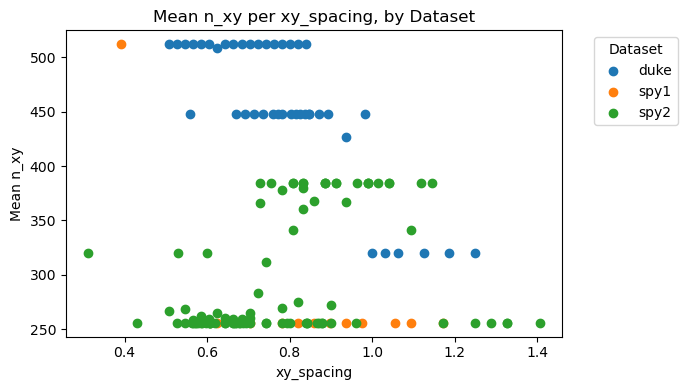

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data
filtered = df[df['n_xy'] >= 256]

# Group by dataset and xy_spacing, compute mean n_xy
grouped = (
    filtered
    .groupby(['dataset', 'xy_spacing'])['n_xy']
    .mean()
    .reset_index()
)

# Plot as scatter points (no lines)
plt.figure(figsize=(7, 4))  # Smaller figure
for dataset in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == dataset]
    plt.scatter(subset['xy_spacing'], subset['n_xy'], label=dataset)

plt.title("Mean n_xy per xy_spacing, by Dataset")
plt.xlabel("xy_spacing")
plt.ylabel("Mean n_xy")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

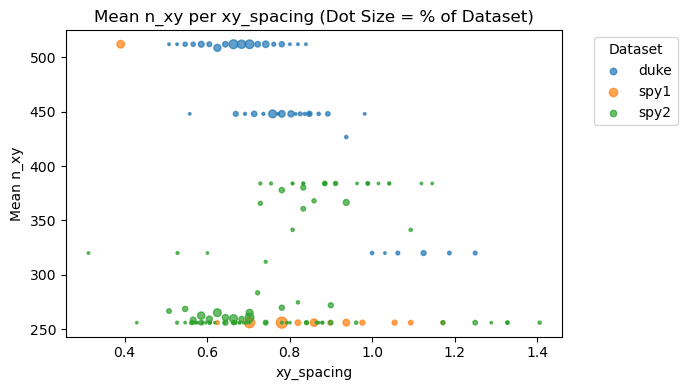

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data
filtered = df[df['n_xy'] >= 256]

# Count total cases per dataset
dataset_sizes = filtered.groupby('dataset').size().rename('total_cases')

# Group by dataset and xy_spacing: get mean and count
grouped = (
    filtered
    .groupby(['dataset', 'xy_spacing'])['n_xy']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'n_xy_mean', 'count': 'n_cases'})
)

# Merge total dataset sizes
grouped = grouped.merge(dataset_sizes, on='dataset')

# Normalize case count by total cases in dataset
grouped['normalized_size'] = grouped['n_cases'] / grouped['total_cases']

# Scale gently: use square root to reduce size contrast
grouped['dot_size'] = grouped['normalized_size'].apply(lambda x: (x**0.5) * 100)

# Plot
plt.figure(figsize=(7, 4))
for dataset in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == dataset]
    plt.scatter(
        subset['xy_spacing'],
        subset['n_xy_mean'],
        s=subset['dot_size'],
        label=dataset,
        alpha=0.7
    )

plt.title("Mean n_xy per xy_spacing (Dot Size = % of Dataset)")
plt.xlabel("xy_spacing")
plt.ylabel("Mean n_xy")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

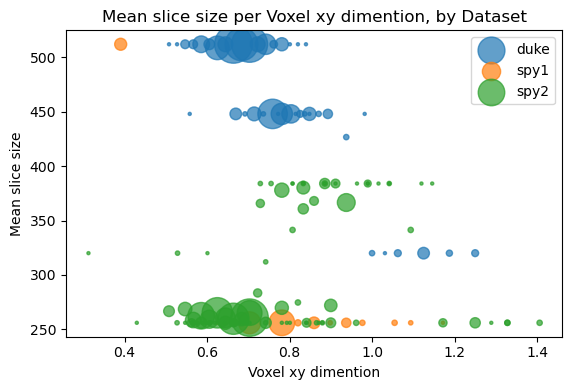

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data
filtered = df[df['n_xy'] >=256]

# Group by dataset and xy_spacing: get mean and count
grouped = (
    filtered
    .groupby(['dataset', 'xy_spacing'])['n_xy']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'n_xy_mean', 'count': 'n_cases'})
)

# Plot
plt.figure(figsize=(7, 4))
for dataset in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == dataset]
    plt.scatter(
        subset['xy_spacing'],
        subset['n_xy_mean'],
        s=subset['n_cases'] * 5,  # Scale dot size (adjust multiplier as needed)
        label=dataset,
        alpha=0.7
    )

plt.title("Mean slice size per Voxel xy dimention, by Dataset")
plt.xlabel("Voxel xy dimention")
plt.ylabel("Mean slice size")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.legend()
plt.show()

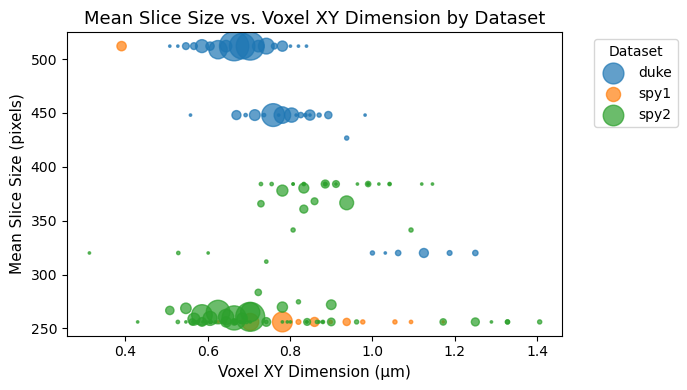

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data
filtered = df[df['n_xy'] >= 256]

# Group by dataset and xy_spacing: get mean and count
grouped = (
    filtered
    .groupby(['dataset', 'xy_spacing'])['n_xy']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'n_xy_mean', 'count': 'n_cases'})
)

# Plot
plt.figure(figsize=(7, 4))
for dataset in grouped['dataset'].unique():
    subset = grouped[grouped['dataset'] == dataset]
    plt.scatter(
        subset['xy_spacing'],
        subset['n_xy_mean'],
        s=subset['n_cases'] * 3,  # Gentle scaling
        label=dataset,
        alpha=0.7
    )

# ✨ Improved title and labels
plt.title("Mean Slice Size vs. Voxel XY Dimension by Dataset", fontsize=13)
plt.xlabel("Voxel XY Dimension (μm)", fontsize=11)
plt.ylabel("Mean Slice Size (pixels)", fontsize=11)

# Legend and layout
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 💾 Save to high-quality PNG
plt.savefig("mean_slice_vs_voxel_xy.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [224]:
df=pd.read_csv('../BreastDCEDL_metadata.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2070 non-null   object 
 1   pCR             1452 non-null   float64
 2   n_xy            2070 non-null   float64
 3   n_z             2070 non-null   float64
 4   n_times         2070 non-null   float64
 5   pre             2070 non-null   float64
 6   post_early      2070 non-null   float64
 7   post_late       2070 non-null   float64
 8   slice_thick     2070 non-null   float64
 9   xy_spacing      2070 non-null   float64
 10  mask_start      2070 non-null   float64
 11  mask_end        2070 non-null   float64
 12  sraw            2070 non-null   float64
 13  eraw            2070 non-null   float64
 14  scol            2070 non-null   float64
 15  ecol            2070 non-null   float64
 16  tum_vol         1456 non-null   float64
 17  age             2070 non-null   f

In [223]:
df = pd.read_csv('../BreastDCEDL_metadata_min.csv')
df[df.n_xy>256]

Empty DataFrame
Columns: [pid, pCR, n_xy, n_z, n_times, pre, post_early, post_late, slice_thick, xy_spacing, mask_start, mask_end, sraw, eraw, scol, ecol, tum_vol, age, menopause, race_white, race_black, HR, HER2, HR_HER2_STATUS, TripleNeg, HER2pos, HRposHER2neg, dataset, test]
Index: []

[0 rows x 29 columns]

In [663]:
df = pd.read_csv('../BreastDCEDL_metadata.csv')
df[df.n_xy>256]

pid  pCR   n_xy    n_z  n_times  pre  post_early  \
22    ACRIN-6698-172366  1.0  320.0   64.0      7.0  0.0         2.0   
34    ACRIN-6698-220471  0.0  384.0  160.0      7.0  0.0         2.0   
45    ACRIN-6698-253531  1.0  384.0  160.0      7.0  0.0         2.0   
46    ACRIN-6698-255388  1.0  384.0  160.0      7.0  0.0         2.0   
51    ACRIN-6698-275034  1.0  320.0  160.0      7.0  0.0         2.0   
...                 ...  ...    ...    ...      ...  ...         ...   
2065     Breast_MRI_918  NaN  512.0  192.0      5.0  0.0         1.0   
2066     Breast_MRI_919  NaN  512.0  192.0      5.0  0.0         1.0   
2067     Breast_MRI_920  NaN  448.0  160.0      4.0  0.0         1.0   
2068     Breast_MRI_921  NaN  512.0  174.0      4.0  0.0         1.0   
2069     Breast_MRI_922  NaN  512.0  174.0      4.0  0.0         1.0   

      post_late  slice_thick  xy_spacing  ...  race_white  race_black   HR  \
22          5.0          2.5    0.625000  ...         1.0         0.0  0.0   
34          5.0          1.0    0.833333  ...         1.0         0.0  0.0   
45          5.0          1.0    0.729167  ...         1.0         0.0  1.0   
46          5.0          1.0    0.781250  ...         1.0         0.0  0.0   
51          5.0          1.1    0.312500  ...         1.0         0.0  1.0   
...         ...          ...         ...  ...         ...         ...  ...   
2065        4.0          2.2    0.683600  ...         0.0         1.0  1.0   
2066        4.0          2.2    0.664100  ...         1.0         0.0  1.0   
2067        3.0          2.0    0.758929  ...         1.0         0.0  1.0   
2068        3.0          1.2    0.781300  ...         0.0         1.0  1.0   
2069        3.0          2.0    0.703100  ...         1.0         0.0  1.0   

      HER2  HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
22     0.0       TripleNeg        1.0      0.0           0.0     spy2   0.0  
34     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
45     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
46     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
51     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
...    ...             ...        ...      ...           ...      ...   ...  
2065   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2066   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2067   0.0    HRposHER2neg        0.0      0.0           1.0     duke   2.0  
2068   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2069   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  

[1144 rows x 29 columns]

In [664]:
pp=['ISPY1_1193',
'ISPY1_1053' ,
'ISPY1_1164',
'ISPY1_1112',
'ISPY1_1114']

In [666]:
import shutil
import os

ll = ['xmin_dce', 'xmin_mask', 'xcrop_dce', 'xcrop_mask', 'xcrop_dce']
base_path = r"G:\My Drive\breast_mri\SPY1\vis1"
ff = [os.path.join(base_path, x) for x in ll]

for f in ff:
    try:
        if os.path.exists(f):
            shutil.rmtree(f)
            print(f"Deleted: {f}")
    except PermissionError as e:
        print(f"❌ Permission denied when deleting {f}: {e}")
        continue  # Skip to next folder

    try:
        os.makedirs(f, exist_ok=True)
        print(f"Created: {f}")
    except Exception as e:
        print(f"❌ Failed to create {f}: {e}")

Created: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce
Created: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask
Created: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce
Created: G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask
Deleted: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce
Created: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce


In [629]:
import shutil
import os

ll = ['jpg_spy1', 'jpg_spy1b', 'jpg_spy1c', 'jpg_spy1oc', 'jpg_spy1d']
base_path = r"C:\\Downloads\\breast_mri\\SPY1\\vis1"
ff = [os.path.join(base_path, x) for x in ll]

for f in ff:
    try:
        if os.path.exists(f):
            shutil.rmtree(f)
            print(f"Deleted: {f}")
    except PermissionError as e:
        print(f"❌ Permission denied when deleting {f}: {e}")
        continue  # Skip to next folder

    try:
        os.makedirs(f, exist_ok=True)
        print(f"Created: {f}")
    except Exception as e:
        print(f"❌ Failed to create {f}: {e}")

Deleted: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1
Created: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1
Deleted: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1b
Created: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1b
Deleted: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1c
Created: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1c
Deleted: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1oc
Created: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1oc
Deleted: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1d
Created: C:\\Downloads\\breast_mri\\SPY1\\vis1\jpg_spy1d


In [667]:
fpath= r"G:\My Drive\breast_mri\SPY1\vis1\xmin_dce"
cpath= r"G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce"
mpath= r"G:\My Drive\breast_mri\SPY1\vis1\xmin_mask"
mcpath= r"G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask"


In [668]:
os.listdir("G:\\My Drive\\breast_mri\\SPY1\\vis1\\xmin_dce\\")[:2]

['desktop.ini']

In [669]:
df_crop = df[df.dataset=='spy1'].copy()
#df_crop = df_crop.reset_index(drop=True)
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]
data_path='G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce'

In [670]:
import cv2

In [671]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df_crop[df_crop.dataset=='spy1'].iterrows():
        
        pid =  row['pid']
        #if pid != 'ISPY1_1103': continue
                    
        print(i,pid,row['pid'],row['mask_start'],row['mask_end']) 
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])
        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a=get_all_nifti_acquisitions(pid, 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce\\')
        
        m = get_vis1_nifti_mask(pid, 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask\\') 
        
        
        print(i,pid,len(a),a[0].shape, m.shape,' voi',
              row['mask_start'],
              row['mask_end'],
             row['sraw'],row['eraw'],row['scol'],row['ecol'])
        
        a0=a[0]  
        w=int(row['n_xy'])
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
               
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        print('-- voi',a0.shape, voi)
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1,
                                            output_size=256)
        print('====crop cords', crop_coords)
        print(a0.shape)
        print(startm,endm)
       
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row

        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        
        c = []
        if row['n_xy']!=256:
            
            #resize and crop
            
            cres=[]
            for ii in range(len(a)):
                cll=[]
                for h in range(a[0].shape[0]):
                    
                    img=a[ii][h]
                    cll.append(cv2.resize(img.copy(), (256, 256),
                                          interpolation=cv2.INTER_AREA) )
                cll=np.array(cll).squeeze() 
                cres.append(cll[crop_coords[0]:crop_coords[1]+1])
                print('dce resized ', cll.shape)
            cres=np.array(cres).squeeze()
            print('dce resized croped', cres.shape)
                
            if m is not None:  
                x=[]
                for h in range(a[0].shape[0]):
                    x.append(cv2.resize(m[h].copy(), (256, 256),
                                        interpolation=cv2.INTER_NEAREST))
                mres = np.array(x).squeeze() 
                mres=mres[crop_coords[0]:crop_coords[1]+1]
                print('mask resized',mres.shape)
        cll=[]                            
        for ii in range(len(a)):
                    
            img=a[ii]
            cll.append(crop_with_same_coordinates(img.copy(), crop_coords) )
                     
        c=np.array(cll).squeeze() 
        print('dce croped', c.shape)
        
        if m is not None:  
            m = crop_with_same_coordinates(m.copy(), crop_coords)
            print('mask croped',m.shape)
        
         
        print('saving:', c.shape)
        for ii in [i1,i2,i0]:
                         
            fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
            save_niftii(os.path.join(fpath, fn),c[ii].squeeze())
            print('saving:',os.path.join(fpath, fn),'\n',c[ii].shape)
        
        if m is not None:  
            fn = pid+'_spy1_vis1_mask.nii.gz'
            save_niftii(os.path.join(mpath, fn),m.squeeze())
            print('saving:',os.path.join(mpath, fn),'\n', m.shape)
            
        if row['n_xy']!=256:
            for ii in [i1,i2,i0]:
                         
                fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
                save_niftii(os.path.join(cpath, fn),cres[ii].squeeze())
                print('saving:',os.path.join(cpath, fn),'\n',cres[ii].shape)
                
            if m is not None:      
                fn = pid+'_spy1_vis1_mask.nii.gz'
                save_niftii(os.path.join(mcpath, fn),mres)
                print('saving:',os.path.join(mcpath, fn),'\n',mres.shape)
            
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = c[0].shape[0]
                                   
        #df_crop.to_csv('../../breast_mri/SPY1/df_crop_to256_spy1.csv', index = False)
                                   

982 ISPY1_1219 ISPY1_1219 17.0 41.0
982 ISPY1_1219 3 (64, 256, 256) (64, 256, 256)  voi 17.0 41.0 54.0 125.0 74.0 158.0
-- voi (64, 256, 256) [(17, 41), (54, 125), (74, 158)]
====crop cords (16, 42, 0, 255, 0, 255)
(64, 256, 256)
17 41
dce croped (3, 27, 256, 256)
mask croped (27, 256, 256)
saving: (3, 27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1219_spy1_vis1_dce_aqc1.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1219_spy1_vis1_dce_aqc2.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1219_spy1_vis1_dce_aqc0.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1219_spy1_vis1_mask.nii.gz 
 (27, 256, 256)
983 ISPY1_1177 ISPY1_1177 4.0 22.0
983 ISPY1_1177 3 (60, 256, 256) (60, 256, 256)  voi 4.0 22.0 97.0 131.0 105.0 135.0
-- voi (60, 256, 256) [(4, 22), (97, 131), (105, 135)]
====crop cords (3, 23, 0, 255, 0, 255)
(60, 256, 256)
4 22
dce croped (3, 21, 256, 256)
mask cr

dce croped (3, 38, 256, 256)
mask croped (38, 256, 256)
saving: (3, 38, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1199_spy1_vis1_dce_aqc1.nii.gz 
 (38, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1199_spy1_vis1_dce_aqc2.nii.gz 
 (38, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1199_spy1_vis1_dce_aqc0.nii.gz 
 (38, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1199_spy1_vis1_mask.nii.gz 
 (38, 256, 256)
994 ISPY1_1114 ISPY1_1114 3.0 23.0
994 ISPY1_1114 3 (44, 512, 512) (44, 512, 512)  voi 3.0 23.0 119.0 283.0 218.0 339.0
-- voi (44, 512, 512) [(3, 23), (119, 283), (218, 339)]
====crop cords (2, 24, 74, 329, 151, 406)
(44, 512, 512)
3 23
dce resized  (44, 256, 256)
dce resized  (44, 256, 256)
dce resized  (44, 256, 256)
dce resized croped (3, 23, 256, 256)
mask resized (23, 256, 256)
dce croped (3, 23, 256, 256)
mask croped (23, 256, 256)
saving: (3, 23, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\

1003 ISPY1_1070 3 (60, 256, 256) (60, 256, 256)  voi 13.0 37.0 115.0 183.0 72.0 122.0
-- voi (60, 256, 256) [(13, 37), (115, 183), (72, 122)]
====crop cords (12, 38, 0, 255, 0, 255)
(60, 256, 256)
13 37
dce croped (3, 27, 256, 256)
mask croped (27, 256, 256)
saving: (3, 27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1070_spy1_vis1_dce_aqc1.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1070_spy1_vis1_dce_aqc2.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1070_spy1_vis1_dce_aqc0.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1070_spy1_vis1_mask.nii.gz 
 (27, 256, 256)
1004 ISPY1_1193 ISPY1_1193 29.0 46.0
1004 ISPY1_1193 5 (64, 256, 256) (64, 256, 256)  voi 29.0 46.0 45.0 91.0 92.0 155.0
-- voi (64, 256, 256) [(29, 46), (45, 91), (92, 155)]
====crop cords (28, 47, 0, 255, 0, 255)
(64, 256, 256)
29 46
dce croped (5, 20, 256, 256)
mask croped (20, 256, 256)
saving: (5

saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1164_spy1_vis1_dce_aqc2.nii.gz 
 (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1164_spy1_vis1_dce_aqc0.nii.gz 
 (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1164_spy1_vis1_mask.nii.gz 
 (15, 256, 256)
1014 ISPY1_1112 ISPY1_1112 25.0 47.0
1014 ISPY1_1112 3 (56, 256, 256) (56, 256, 256)  voi 25.0 47.0 107.0 181.0 74.0 172.0
-- voi (56, 256, 256) [(25, 47), (107, 181), (74, 172)]
====crop cords (24, 48, 0, 255, 0, 255)
(56, 256, 256)
25 47
dce croped (3, 25, 256, 256)
mask croped (25, 256, 256)
saving: (3, 25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1112_spy1_vis1_dce_aqc1.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1112_spy1_vis1_dce_aqc2.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1112_spy1_vis1_dce_aqc0.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_

dce resized  (44, 256, 256)
dce resized  (44, 256, 256)
dce resized  (44, 256, 256)
dce resized croped (3, 24, 256, 256)
mask resized (24, 256, 256)
dce croped (3, 24, 256, 256)
mask croped (24, 256, 256)
saving: (3, 24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1169_spy1_vis1_dce_aqc1.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1169_spy1_vis1_dce_aqc2.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1169_spy1_vis1_dce_aqc0.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1169_spy1_vis1_mask.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1169_spy1_vis1_dce_aqc1.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1169_spy1_vis1_dce_aqc2.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1169_spy1_vis1_dce_aqc0.nii.gz 
 (24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\

1034 ISPY1_1107 3 (58, 256, 256) (58, 256, 256)  voi 17.0 24.0 118.0 144.0 56.0 85.0
-- voi (58, 256, 256) [(17, 24), (118, 144), (56, 85)]
====crop cords (16, 25, 0, 255, 0, 255)
(58, 256, 256)
17 24
dce croped (3, 10, 256, 256)
mask croped (10, 256, 256)
saving: (3, 10, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1107_spy1_vis1_dce_aqc1.nii.gz 
 (10, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1107_spy1_vis1_dce_aqc2.nii.gz 
 (10, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1107_spy1_vis1_dce_aqc0.nii.gz 
 (10, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1107_spy1_vis1_mask.nii.gz 
 (10, 256, 256)
1035 ISPY1_1179 ISPY1_1179 9.0 23.0
1035 ISPY1_1179 3 (44, 512, 512) (44, 512, 512)  voi 9.0 23.0 112.0 206.0 254.0 346.0
-- voi (44, 512, 512) [(9, 23), (112, 206), (254, 346)]
====crop cords (8, 24, 32, 287, 173, 428)
(44, 512, 512)
9 23
dce resized  (44, 256, 256)
dce resized  (44, 256, 256)
dce resi

saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1235_spy1_vis1_dce_aqc0.nii.gz 
 (18, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask\ISPY1_1235_spy1_vis1_mask.nii.gz 
 (18, 256, 256)
1044 ISPY1_1167 ISPY1_1167 3.0 70.0
1044 ISPY1_1167 4 (80, 256, 256) (80, 256, 256)  voi 3.0 70.0 88.0 199.0 43.0 160.0
-- voi (80, 256, 256) [(3, 70), (88, 199), (43, 160)]
====crop cords (2, 71, 0, 255, 0, 255)
(80, 256, 256)
3 70
dce croped (4, 70, 256, 256)
mask croped (70, 256, 256)
saving: (4, 70, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1167_spy1_vis1_dce_aqc2.nii.gz 
 (70, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1167_spy1_vis1_dce_aqc3.nii.gz 
 (70, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1167_spy1_vis1_dce_aqc0.nii.gz 
 (70, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1167_spy1_vis1_mask.nii.gz 
 (70, 256, 256)
1045 ISPY1_1176 ISPY1_1176 27.0 46.0
1045 ISPY1_1176 3 (58, 256, 

saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1236_spy1_vis1_dce_aqc1.nii.gz 
 (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1236_spy1_vis1_dce_aqc2.nii.gz 
 (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1236_spy1_vis1_dce_aqc0.nii.gz 
 (15, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask\ISPY1_1236_spy1_vis1_mask.nii.gz 
 (15, 256, 256)
1055 ISPY1_1060 ISPY1_1060 7.0 61.0
1055 ISPY1_1060 6 (70, 256, 256) (70, 256, 256)  voi 7.0 61.0 128.0 201.0 71.0 158.0
-- voi (70, 256, 256) [(7, 61), (128, 201), (71, 158)]
====crop cords (6, 62, 0, 255, 0, 255)
(70, 256, 256)
7 61
dce croped (6, 57, 256, 256)
mask croped (57, 256, 256)
saving: (6, 57, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1060_spy1_vis1_dce_aqc2.nii.gz 
 (57, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1060_spy1_vis1_dce_aqc5.nii.gz 
 (57, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_10

1065 ISPY1_1161 4 (60, 256, 256) (60, 256, 256)  voi 6.0 30.0 89.0 170.0 91.0 186.0
-- voi (60, 256, 256) [(6, 30), (89, 170), (91, 186)]
====crop cords (5, 31, 0, 255, 0, 255)
(60, 256, 256)
6 30
dce croped (4, 27, 256, 256)
mask croped (27, 256, 256)
saving: (4, 27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1161_spy1_vis1_dce_aqc2.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1161_spy1_vis1_dce_aqc3.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1161_spy1_vis1_dce_aqc0.nii.gz 
 (27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1161_spy1_vis1_mask.nii.gz 
 (27, 256, 256)
1066 ISPY1_1097 ISPY1_1097 26.0 46.0
1066 ISPY1_1097 3 (64, 256, 256) (64, 256, 256)  voi 26.0 46.0 106.0 160.0 88.0 150.0
-- voi (64, 256, 256) [(26, 46), (106, 160), (88, 150)]
====crop cords (25, 47, 0, 255, 0, 255)
(64, 256, 256)
26 46
dce croped (3, 23, 256, 256)
mask croped (23, 256, 256)
saving: (3, 

mask resized (21, 256, 256)
dce croped (3, 21, 256, 256)
mask croped (21, 256, 256)
saving: (3, 21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1233_spy1_vis1_dce_aqc1.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1233_spy1_vis1_dce_aqc2.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1233_spy1_vis1_dce_aqc0.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1233_spy1_vis1_mask.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1233_spy1_vis1_dce_aqc1.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1233_spy1_vis1_dce_aqc2.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1233_spy1_vis1_dce_aqc0.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask\ISPY1_1233_spy1_vis1_mask.nii.gz 
 (21, 256, 256)
1076 ISPY1_1005 ISPY1_1005 5.0 43.0
1076 ISPY1_1005 3 (60, 2

1086 ISPY1_1041 3 (60, 256, 256) (60, 256, 256)  voi 20.0 50.0 86.0 170.0 48.0 163.0
-- voi (60, 256, 256) [(20, 50), (86, 170), (48, 163)]
====crop cords (19, 51, 0, 255, 0, 255)
(60, 256, 256)
20 50
dce croped (3, 33, 256, 256)
mask croped (33, 256, 256)
saving: (3, 33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1041_spy1_vis1_dce_aqc1.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1041_spy1_vis1_dce_aqc2.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1041_spy1_vis1_dce_aqc0.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1041_spy1_vis1_mask.nii.gz 
 (33, 256, 256)
1087 ISPY1_1015 ISPY1_1015 17.0 55.0
1087 ISPY1_1015 3 (60, 256, 256) (60, 256, 256)  voi 17.0 55.0 112.0 205.0 32.0 149.0
-- voi (60, 256, 256) [(17, 55), (112, 205), (32, 149)]
====crop cords (16, 56, 0, 255, 0, 255)
(60, 256, 256)
17 55
dce croped (3, 41, 256, 256)
mask croped (41, 256, 256)
saving: 

dce croped (3, 33, 256, 256)
mask croped (33, 256, 256)
saving: (3, 33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1221_spy1_vis1_dce_aqc1.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1221_spy1_vis1_dce_aqc2.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1221_spy1_vis1_dce_aqc0.nii.gz 
 (33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1221_spy1_vis1_mask.nii.gz 
 (33, 256, 256)
1098 ISPY1_1082 ISPY1_1082 16.0 49.0
1098 ISPY1_1082 3 (64, 256, 256) (64, 256, 256)  voi 16.0 49.0 72.0 176.0 43.0 172.0
-- voi (64, 256, 256) [(16, 49), (72, 176), (43, 172)]
====crop cords (15, 50, 0, 255, 0, 255)
(64, 256, 256)
16 49
dce croped (3, 36, 256, 256)
mask croped (36, 256, 256)
saving: (3, 36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1082_spy1_vis1_dce_aqc1.nii.gz 
 (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1082_spy1_vis1_dce_aqc2.n

saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1106_spy1_vis1_dce_aqc5.nii.gz 
 (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1106_spy1_vis1_dce_aqc0.nii.gz 
 (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1106_spy1_vis1_mask.nii.gz 
 (29, 256, 256)
1109 ISPY1_1234 ISPY1_1234 10.0 20.0
1109 ISPY1_1234 3 (52, 256, 256) (52, 256, 256)  voi 10.0 20.0 87.0 150.0 148.0 199.0
-- voi (52, 256, 256) [(10, 20), (87, 150), (148, 199)]
====crop cords (9, 21, 0, 255, 0, 255)
(52, 256, 256)
10 20
dce croped (3, 13, 256, 256)
mask croped (13, 256, 256)
saving: (3, 13, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1234_spy1_vis1_dce_aqc1.nii.gz 
 (13, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1234_spy1_vis1_dce_aqc2.nii.gz 
 (13, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1234_spy1_vis1_dce_aqc0.nii.gz 
 (13, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1

saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1201_spy1_vis1_mask.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1201_spy1_vis1_dce_aqc1.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1201_spy1_vis1_dce_aqc2.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce\ISPY1_1201_spy1_vis1_dce_aqc0.nii.gz 
 (21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask\ISPY1_1201_spy1_vis1_mask.nii.gz 
 (21, 256, 256)
1119 ISPY1_1013 ISPY1_1013 21.0 47.0
1119 ISPY1_1013 3 (60, 256, 256) (60, 256, 256)  voi 21.0 47.0 91.0 171.0 28.0 128.0
-- voi (60, 256, 256) [(21, 47), (91, 171), (28, 128)]
====crop cords (20, 48, 0, 255, 0, 255)
(60, 256, 256)
21 47
dce croped (3, 29, 256, 256)
mask croped (29, 256, 256)
saving: (3, 29, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1013_spy1_vis1_dce_aqc1.nii.gz 
 (29, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_10

saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1094_spy1_vis1_dce_aqc2.nii.gz 
 (51, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1094_spy1_vis1_dce_aqc0.nii.gz 
 (51, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1094_spy1_vis1_mask.nii.gz 
 (51, 256, 256)
1130 ISPY1_1096 ISPY1_1096 13.0 35.0
1130 ISPY1_1096 4 (60, 256, 256) (60, 256, 256)  voi 13.0 35.0 81.0 145.0 122.0 186.0
-- voi (60, 256, 256) [(13, 35), (81, 145), (122, 186)]
====crop cords (12, 36, 0, 255, 0, 255)
(60, 256, 256)
13 35
dce croped (4, 25, 256, 256)
mask croped (25, 256, 256)
saving: (4, 25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1096_spy1_vis1_dce_aqc1.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1096_spy1_vis1_dce_aqc2.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1096_spy1_vis1_dce_aqc0.nii.gz 
 (25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_

1141 ISPY1_1004 3 (60, 256, 256) (60, 256, 256)  voi 8.0 48.0 25.0 198.0 81.0 181.0
-- voi (60, 256, 256) [(8, 48), (25, 198), (81, 181)]
====crop cords (7, 49, 0, 255, 0, 255)
(60, 256, 256)
8 48
dce croped (3, 43, 256, 256)
mask croped (43, 256, 256)
saving: (3, 43, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1004_spy1_vis1_dce_aqc1.nii.gz 
 (43, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1004_spy1_vis1_dce_aqc2.nii.gz 
 (43, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1004_spy1_vis1_dce_aqc0.nii.gz 
 (43, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1004_spy1_vis1_mask.nii.gz 
 (43, 256, 256)
1142 ISPY1_1151 ISPY1_1151 14.0 43.0
1142 ISPY1_1151 3 (64, 256, 256) (64, 256, 256)  voi 14.0 43.0 64.0 217.0 53.0 203.0
-- voi (64, 256, 256) [(14, 43), (64, 217), (53, 203)]
====crop cords (13, 44, 0, 255, 0, 255)
(64, 256, 256)
14 43
dce croped (3, 32, 256, 256)
mask croped (32, 256, 256)
saving: (3, 32

saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1064_spy1_vis1_dce_aqc2.nii.gz 
 (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1064_spy1_vis1_dce_aqc0.nii.gz 
 (28, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_1064_spy1_vis1_mask.nii.gz 
 (28, 256, 256)
1152 ISPY1_1035 ISPY1_1035 12.0 45.0
1152 ISPY1_1035 4 (60, 256, 256) (60, 256, 256)  voi 12.0 45.0 55.0 205.0 66.0 184.0
-- voi (60, 256, 256) [(12, 45), (55, 205), (66, 184)]
====crop cords (11, 46, 0, 255, 0, 255)
(60, 256, 256)
12 45
dce croped (4, 36, 256, 256)
mask croped (36, 256, 256)
saving: (4, 36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1035_spy1_vis1_dce_aqc2.nii.gz 
 (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1035_spy1_vis1_dce_aqc3.nii.gz 
 (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1035_spy1_vis1_dce_aqc0.nii.gz 
 (36, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_mask\ISPY1_10

In [624]:
df.at[i,'sraw'],crop_coords[2]

(116.0, 124)

In [495]:
df[df.dataset!='duke'].shape

(1154, 29)

In [310]:
df.at[i,'sraw'],crop_coords[2]

(72.0, 133)

In [672]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 982 to 1153
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pid              172 non-null    object 
 1   pCR              172 non-null    float64
 2   n_xy             172 non-null    float64
 3   n_z              172 non-null    float64
 4   n_times          172 non-null    float64
 5   pre              172 non-null    float64
 6   post_early       172 non-null    float64
 7   post_late        172 non-null    float64
 8   slice_thick      172 non-null    float64
 9   xy_spacing       172 non-null    float64
 10  mask_start       172 non-null    float64
 11  mask_end         172 non-null    float64
 12  sraw             172 non-null    float64
 13  eraw             172 non-null    float64
 14  scol             172 non-null    float64
 15  ecol             172 non-null    float64
 16  tum_vol          172 non-null    float64
 17  age          

In [673]:
df[df.n_xy>256]

pid  pCR   n_xy    n_z  n_times  pre  post_early  \
22    ACRIN-6698-172366  1.0  320.0   64.0      7.0  0.0         2.0   
34    ACRIN-6698-220471  0.0  384.0  160.0      7.0  0.0         2.0   
45    ACRIN-6698-253531  1.0  384.0  160.0      7.0  0.0         2.0   
46    ACRIN-6698-255388  1.0  384.0  160.0      7.0  0.0         2.0   
51    ACRIN-6698-275034  1.0  320.0  160.0      7.0  0.0         2.0   
...                 ...  ...    ...    ...      ...  ...         ...   
2065     Breast_MRI_918  NaN  512.0  192.0      5.0  0.0         1.0   
2066     Breast_MRI_919  NaN  512.0  192.0      5.0  0.0         1.0   
2067     Breast_MRI_920  NaN  448.0  160.0      4.0  0.0         1.0   
2068     Breast_MRI_921  NaN  512.0  174.0      4.0  0.0         1.0   
2069     Breast_MRI_922  NaN  512.0  174.0      4.0  0.0         1.0   

      post_late  slice_thick  xy_spacing  ...  race_white  race_black   HR  \
22          5.0          2.5    0.625000  ...         1.0         0.0  0.0   
34          5.0          1.0    0.833333  ...         1.0         0.0  0.0   
45          5.0          1.0    0.729167  ...         1.0         0.0  1.0   
46          5.0          1.0    0.781250  ...         1.0         0.0  0.0   
51          5.0          1.1    0.312500  ...         1.0         0.0  1.0   
...         ...          ...         ...  ...         ...         ...  ...   
2065        4.0          2.2    0.683600  ...         0.0         1.0  1.0   
2066        4.0          2.2    0.664100  ...         1.0         0.0  1.0   
2067        3.0          2.0    0.758929  ...         1.0         0.0  1.0   
2068        3.0          1.2    0.781300  ...         0.0         1.0  1.0   
2069        3.0          2.0    0.703100  ...         1.0         0.0  1.0   

      HER2  HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
22     0.0       TripleNeg        1.0      0.0           0.0     spy2   0.0  
34     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
45     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
46     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
51     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
...    ...             ...        ...      ...           ...      ...   ...  
2065   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2066   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2067   0.0    HRposHER2neg        0.0      0.0           1.0     duke   2.0  
2068   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2069   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  

[1144 rows x 29 columns]

In [674]:
df_crop[df_crop.pid.isin(df[df.n_xy>267].pid.values)]

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
994   ISPY1_1114  0.0  256.0  23.0      3.0  0.0         1.0        2.0   
996   ISPY1_1237  0.0  256.0  14.0      3.0  0.0         1.0        2.0   
1010  ISPY1_1103  1.0  256.0  34.0      3.0  0.0         1.0        2.0   
1018  ISPY1_1218  0.0  256.0  20.0      3.0  0.0         1.0        2.0   
1022  ISPY1_1156  1.0  256.0  30.0      4.0  0.0         1.0        2.0   
1023  ISPY1_1169  0.0  256.0  24.0      3.0  0.0         1.0        2.0   
1035  ISPY1_1179  0.0  256.0  17.0      3.0  0.0         1.0        2.0   
1043  ISPY1_1235  1.0  256.0  18.0      3.0  0.0         1.0        2.0   
1054  ISPY1_1236  0.0  256.0  15.0      3.0  0.0         1.0        2.0   
1062  ISPY1_1230  0.0  256.0  23.0      3.0  0.0         1.0        2.0   
1074  ISPY1_1183  0.0  256.0  23.0      3.0  0.0         1.0        2.0   
1075  ISPY1_1233  0.0  256.0  21.0      3.0  0.0         1.0        2.0   
1113  ISPY1_1224  0.0  256.0  13.0      3.0  0.0         1.0        2.0   
1118  ISPY1_1201  0.0  256.0  21.0      3.0  0.0         1.0        2.0   
1143  ISPY1_1202  1.0  256.0  15.0      3.0  0.0         1.0        2.0   

      slice_thick  xy_spacing  ...  org_scol  org_ecol  org_n_z  org_n_xy  \
994      3.000000    0.390625  ...     218.0     339.0     44.0     512.0   
996      3.000000    0.390625  ...     150.0     283.0     44.0     512.0   
1010     3.000000    0.390625  ...     115.0     336.0     44.0     512.0   
1018     3.409091    0.390625  ...     114.0     358.0     44.0     512.0   
1022     3.000000    0.390625  ...     182.0     352.0     44.0     512.0   
1023     3.000000    0.390625  ...     142.0     348.0     44.0     512.0   
1035     3.000000    0.390625  ...     254.0     346.0     44.0     512.0   
1043     3.000000    0.390625  ...     202.0     332.0     44.0     512.0   
1054     3.000000    0.390625  ...     167.0     252.0     44.0     512.0   
1062     2.592592    0.390625  ...     102.0     302.0     54.0     512.0   
1074     3.000000    0.390625  ...      95.0     310.0     44.0     512.0   
1075     3.000000    0.390625  ...      40.0     162.0     44.0     512.0   
1113     3.000000    0.390625  ...     238.0     327.0     48.0     512.0   
1118     3.000000    0.390625  ...     131.0     326.0     44.0     512.0   
1143     3.000000    0.390625  ...     176.0     256.0     44.0     512.0   

      crop_mask_start  crop_mask_end  crop_sraw  crop_eraw  crop_scol  \
994               2.0           24.0       74.0      329.0      151.0   
996               8.0           21.0       70.0      325.0       89.0   
1010              6.0           39.0      116.0      371.0       98.0   
1018              9.0           28.0      179.0      434.0      109.0   
1022              7.0           36.0      147.0      402.0      140.0   
1023             12.0           35.0      152.0      407.0      118.0   
1035              8.0           24.0       32.0      287.0      173.0   
1043              8.0           25.0      108.0      363.0      140.0   
1054              7.0           21.0      163.0      418.0       82.0   
1062             31.0           53.0      134.0      389.0       75.0   
1074              8.0           30.0      177.0      432.0       75.0   
1075             14.0           34.0       89.0      344.0        0.0   
1113             12.0           24.0       65.0      320.0      155.0   
1118             14.0           34.0       90.0      345.0      101.0   
1143             15.0           29.0       75.0      330.0       89.0   

      crop_ecol  
994       406.0  
996       344.0  
1010      353.0  
1018      364.0  
1022      395.0  
1023      373.0  
1035      428.0  
1043      395.0  
1054      337.0  
1062      330.0  
1074      330.0  
1075      255.0  
1113      410.0  
1118      356.0  
1143      344.0  

[15 rows x 43 columns]

In [131]:
df_spy1_crop = pd.read_csv('../../breast_mri/SPY1/df_crop_to256_spy1.csv')
df_spy1_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pid              172 non-null    object 
 1   pCR              172 non-null    float64
 2   n_xy             172 non-null    float64
 3   n_z              172 non-null    float64
 4   n_times          172 non-null    float64
 5   pre              172 non-null    float64
 6   post_early       172 non-null    float64
 7   post_late        172 non-null    float64
 8   slice_thick      172 non-null    float64
 9   xy_spacing       172 non-null    float64
 10  mask_start       172 non-null    float64
 11  mask_end         172 non-null    float64
 12  sraw             172 non-null    float64
 13  eraw             172 non-null    float64
 14  scol             172 non-null    float64
 15  ecol             172 non-null    float64
 16  tum_vol          172 non-null    float64
 17  age             

In [675]:
df_crop.to_csv('../../breast_mri/SPY1/df_crop_to256_spy1.csv', index = False)

In [676]:
dd=pd.read_csv('../BreastDCEDL_metadata_min.csv')
dd=pd.concat([dd[dd.dataset!='spy1'], df_crop[df_crop.dataset=='spy1'][dd.columns]],
             axis=0)
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 1153
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2072 non-null   object 
 1   pCR             1432 non-null   float64
 2   n_xy            2072 non-null   float64
 3   n_z             2072 non-null   float64
 4   n_times         2072 non-null   float64
 5   pre             2072 non-null   float64
 6   post_early      2072 non-null   float64
 7   post_late       2072 non-null   float64
 8   slice_thick     2072 non-null   float64
 9   xy_spacing      2072 non-null   float64
 10  mask_start      2072 non-null   float64
 11  mask_end        2072 non-null   float64
 12  sraw            2072 non-null   float64
 13  eraw            2072 non-null   float64
 14  scol            2072 non-null   float64
 15  ecol            2072 non-null   float64
 16  tum_vol         2071 non-null   float64
 17  age             2072 non-null   f

In [677]:
dd.to_csv('../BreastDCEDL_metadata_min.csv', index = False)

In [678]:
dd[dd.dataset=='spy1']

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
982   ISPY1_1219  0.0  256.0  27.0      3.0  0.0         1.0        2.0   
983   ISPY1_1177  1.0  256.0  21.0      3.0  0.0         1.0        2.0   
984   ISPY1_1196  0.0  256.0  24.0      4.0  0.0         2.0        3.0   
985   ISPY1_1227  1.0  256.0  15.0      3.0  0.0         1.0        2.0   
986   ISPY1_1036  0.0  256.0  43.0      3.0  0.0         1.0        2.0   
...          ...  ...    ...   ...      ...  ...         ...        ...   
1149  ISPY1_1120  0.0  256.0   9.0      3.0  0.0         1.0        2.0   
1150  ISPY1_1025  0.0  256.0  11.0      3.0  0.0         1.0        2.0   
1151  ISPY1_1064  0.0  256.0  28.0      3.0  0.0         1.0        2.0   
1152  ISPY1_1035  0.0  256.0  36.0      4.0  0.0         2.0        3.0   
1153  ISPY1_1205  0.0  256.0  28.0      6.0  0.0         2.0        5.0   

      slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
982           2.0    0.781250  ...         1.0         0.0  1.0   0.0   
983           2.0    0.859375  ...         1.0         0.0  0.0   1.0   
984           2.5    0.781250  ...         1.0         0.0  1.0   1.0   
985           2.3    0.937500  ...         1.0         0.0  0.0   0.0   
986           2.5    0.781250  ...         1.0         0.0  0.0   1.0   
...           ...         ...  ...         ...         ...  ...   ...   
1149          2.0    0.703125  ...         NaN         NaN  1.0   0.0   
1150          2.3    0.781250  ...         NaN         NaN  1.0   0.0   
1151          2.2    0.781250  ...         NaN         NaN  0.0   0.0   
1152          2.0    0.781250  ...         NaN         NaN  1.0   1.0   
1153          4.0    0.781250  ...         NaN         NaN  1.0   0.0   

      HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
982     HRposHER2neg        0.0      0.0           1.0     spy1   0.0  
983          HER2pos        0.0      1.0           0.0     spy1   0.0  
984          HER2pos        0.0      1.0           0.0     spy1   0.0  
985        TripleNeg        1.0      0.0           0.0     spy1   0.0  
986          HER2pos        0.0      1.0           0.0     spy1   0.0  
...              ...        ...      ...           ...      ...   ...  
1149    HRposHER2neg        NaN      NaN           NaN     spy1   0.0  
1150    HRposHER2neg        NaN      NaN           NaN     spy1   0.0  
1151       TripleNeg        NaN      NaN           NaN     spy1   0.0  
1152         HER2pos        NaN      NaN           NaN     spy1   0.0  
1153    HRposHER2neg        NaN      NaN           NaN     spy1   0.0  

[172 rows x 29 columns]

# check

In [681]:
fpath= r"G:\My Drive\breast_mri\SPY1\vis1\xmin_dce"
cpath= r"G:\My Drive\breast_mri\SPY1\vis1\xcrop_dce"
mpath= r"G:\My Drive\breast_mri\SPY1\vis1\xmin_mask"
mcpath= r"G:\My Drive\breast_mri\SPY1\vis1\xcrop_mask"


In [683]:
data_path

'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce'

In [ ]:
pid='ISPY1_1230'

In [ ]:
pid='ISPY1_1001'

In [690]:
pid='ISPY1_1224'

In [679]:
pid='ISPY1_1177'

In [691]:
a=get_all_nifti_acquisitions(pid,  data_path)
ma = get_vis1_nifti_mask(pid,  'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask')
len(a),a[0].shape,ma.shape

(3, (48, 512, 512), (48, 512, 512))

In [692]:
b=get_all_nifti_acquisitions(pid,  fpath)
mb = get_vis1_nifti_mask(pid, mpath)
len(b),b[0].shape,mb.shape

(3, (13, 256, 256), (13, 256, 256))

In [693]:
c=get_all_nifti_acquisitions(pid, cpath)
mc = get_vis1_nifti_mask(pid, mcpath)
if mc is not None: print(len(c),c[0].shape,mc.shape)

3 (13, 256, 256) (13, 256, 256)


In [694]:
for i in range(ma.shape[0]): print(i,ma[i].sum())
#    if ma[i].sum()>0:print(i,ma[i].sum())

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 10.0
14 22.0
15 28.0
16 38.0
17 824.0
18 1704.0
19 2025.0
20 2344.0
21 2400.0
22 1761.0
23 379.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0


In [695]:
m[20].sum()

3351.0

<Figure size 640x480 with 0 Axes>

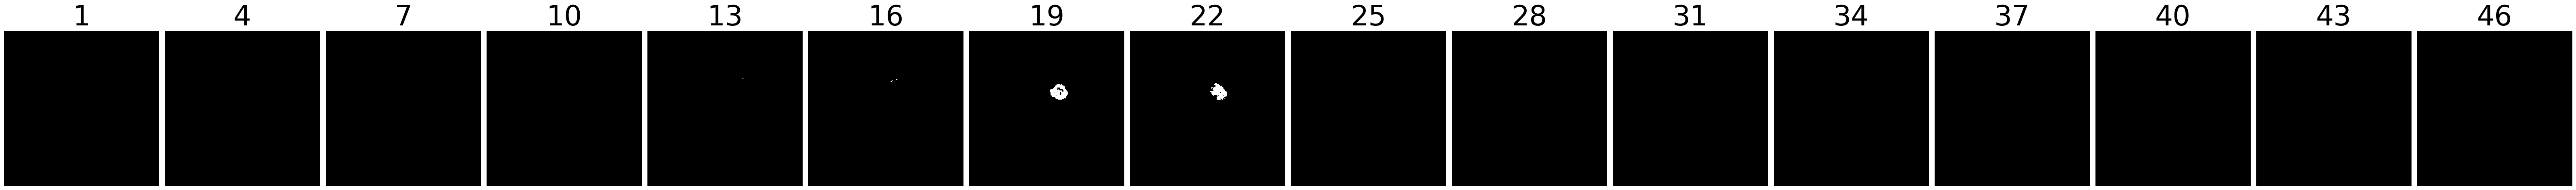

<Figure size 640x480 with 0 Axes>

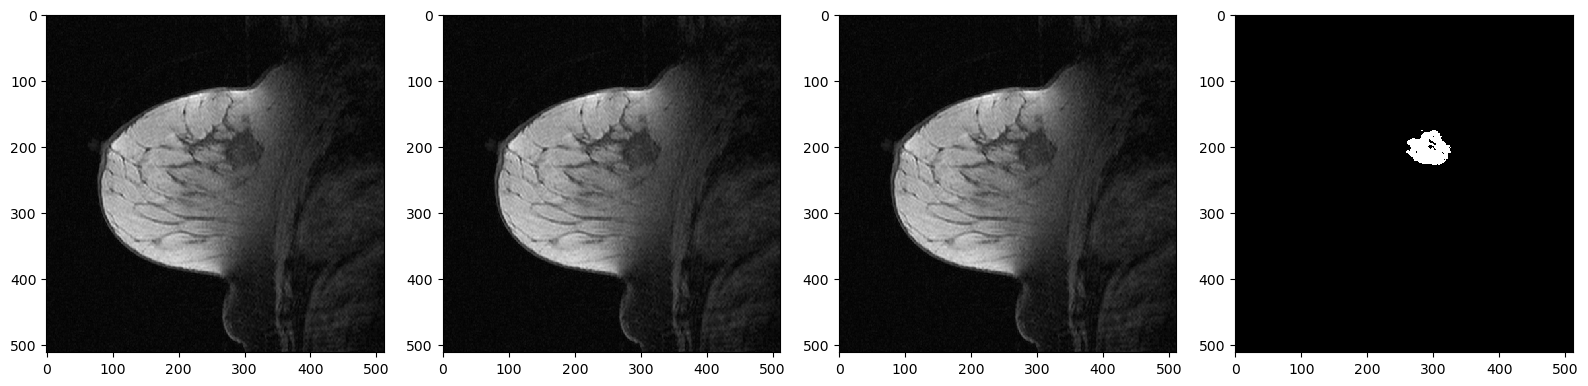

<Figure size 640x480 with 0 Axes>

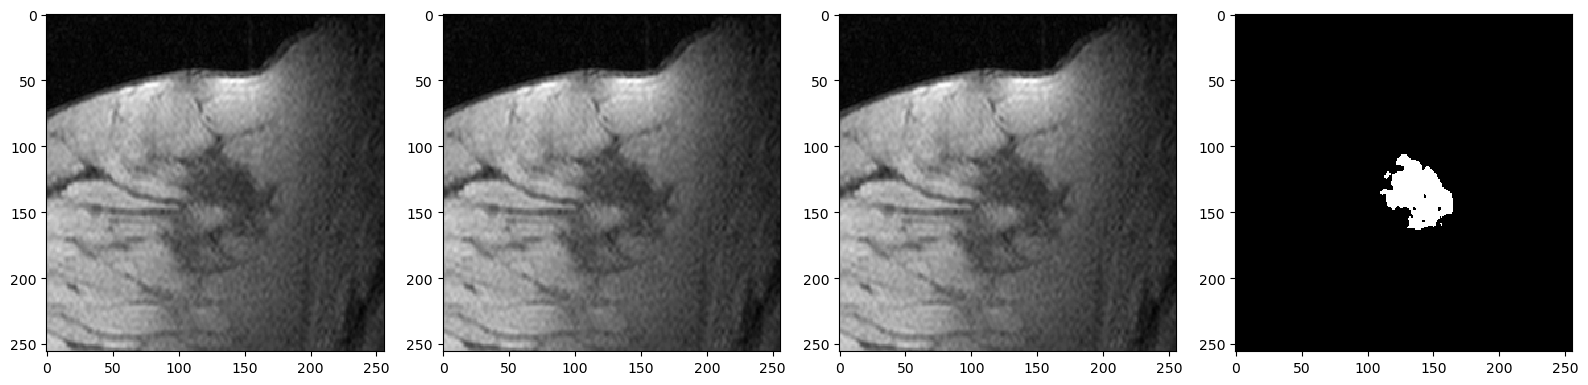

<Figure size 640x480 with 0 Axes>

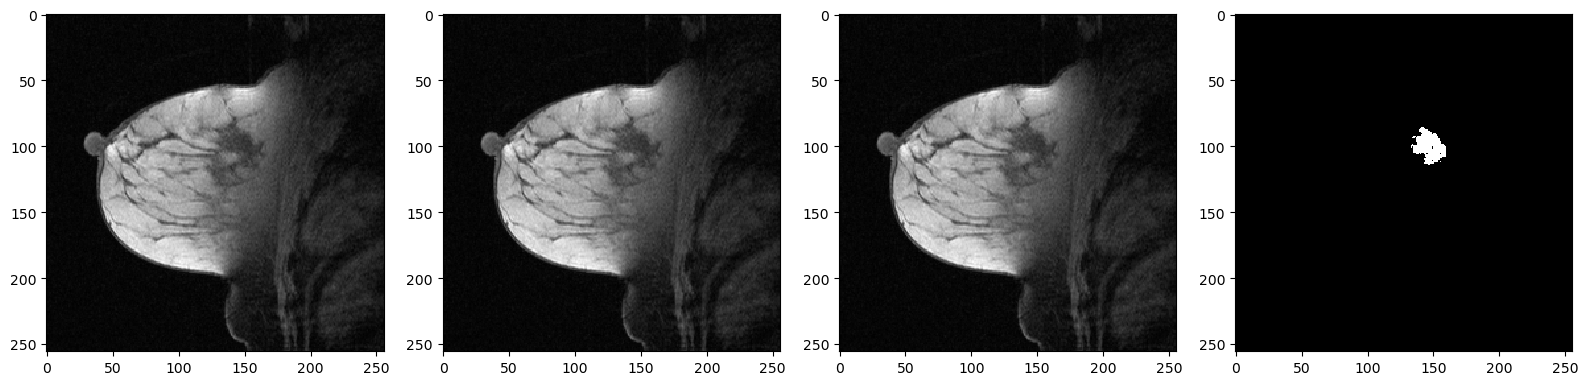

In [697]:
ks=10
km=20
show_n_images([ma[l] for l in range(1,48,3)],titles=[l for l in range(1,48,3)],fontsize=50)
show_n_images([a[0][km],a[0][km],a[0][km],ma[km]], axis_off=False)
show_n_images([b[0][km-ks],b[0][km-ks],b[0][km-ks],mb[km-ks]], axis_off=False)
if mc is not None: 
    show_n_images([c[0][km-ks],c[0][km-ks],c[0][km-ks],mc[km-ks]], axis_off=False)

# crop bias correction

In [725]:
df = pd.read_csv('../BreastDCEDL_metadata.csv')
df[df.n_xy>256]

pid  pCR   n_xy    n_z  n_times  pre  post_early  \
22    ACRIN-6698-172366  1.0  320.0   64.0      7.0  0.0         2.0   
34    ACRIN-6698-220471  0.0  384.0  160.0      7.0  0.0         2.0   
45    ACRIN-6698-253531  1.0  384.0  160.0      7.0  0.0         2.0   
46    ACRIN-6698-255388  1.0  384.0  160.0      7.0  0.0         2.0   
51    ACRIN-6698-275034  1.0  320.0  160.0      7.0  0.0         2.0   
...                 ...  ...    ...    ...      ...  ...         ...   
2065     Breast_MRI_918  NaN  512.0  192.0      5.0  0.0         1.0   
2066     Breast_MRI_919  NaN  512.0  192.0      5.0  0.0         1.0   
2067     Breast_MRI_920  NaN  448.0  160.0      4.0  0.0         1.0   
2068     Breast_MRI_921  NaN  512.0  174.0      4.0  0.0         1.0   
2069     Breast_MRI_922  NaN  512.0  174.0      4.0  0.0         1.0   

      post_late  slice_thick  xy_spacing  ...  race_white  race_black   HR  \
22          5.0          2.5    0.625000  ...         1.0         0.0  0.0   
34          5.0          1.0    0.833333  ...         1.0         0.0  0.0   
45          5.0          1.0    0.729167  ...         1.0         0.0  1.0   
46          5.0          1.0    0.781250  ...         1.0         0.0  0.0   
51          5.0          1.1    0.312500  ...         1.0         0.0  1.0   
...         ...          ...         ...  ...         ...         ...  ...   
2065        4.0          2.2    0.683600  ...         0.0         1.0  1.0   
2066        4.0          2.2    0.664100  ...         1.0         0.0  1.0   
2067        3.0          2.0    0.758929  ...         1.0         0.0  1.0   
2068        3.0          1.2    0.781300  ...         0.0         1.0  1.0   
2069        3.0          2.0    0.703100  ...         1.0         0.0  1.0   

      HER2  HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
22     0.0       TripleNeg        1.0      0.0           0.0     spy2   0.0  
34     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
45     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
46     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
51     1.0         HER2pos        0.0      1.0           0.0     spy2   0.0  
...    ...             ...        ...      ...           ...      ...   ...  
2065   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2066   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2067   0.0    HRposHER2neg        0.0      0.0           1.0     duke   2.0  
2068   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
2069   0.0    HRposHER2neg        0.0      0.0           1.0     duke   0.0  

[1144 rows x 29 columns]

In [723]:
import shutil
import os

ll = ['xn4min_dce', 'xn4crop_dce']
base_path = r"G:\My Drive\breast_mri\SPY1\vis1"
ff = [os.path.join(base_path, x) for x in ll]

for f in ff:
    try:
        if os.path.exists(f):
            shutil.rmtree(f)
            print(f"Deleted: {f}")
    except PermissionError as e:
        print(f"❌ Permission denied when deleting {f}: {e}")
        continue  # Skip to next folder

    try:
        os.makedirs(f, exist_ok=True)
        print(f"Created: {f}")
    except Exception as e:
        print(f"❌ Failed to create {f}: {e}")

Created: G:\My Drive\breast_mri\SPY1\vis1\xn4min_dce
Created: G:\My Drive\breast_mri\SPY1\vis1\xn4crop_dce


In [724]:
fpath= r"G:\My Drive\breast_mri\SPY1\vis1\xn4min_dce"
cpath= r"G:\My Drive\breast_mri\SPY1\vis1\xn4crop_dce"

data_path = r"G:\My Drive\breast_mri\SPY1\vis1\n4dce"

In [718]:
!mkdir r"G:\My Drive\breast_mri\SPY1\vis1\xn4min_dce\"

The filename, directory name, or volume label syntax is incorrect.


In [719]:
os.listdir("G:\\My Drive\\breast_mri\\SPY1\\vis1\\n4dce\\")[0:10]

['ISPY1_1219_spy1_vis1_acq0.nii.gz',
 'ISPY1_1219_spy1_vis1_acq1.nii.gz',
 'ISPY1_1219_spy1_vis1_acq2.nii.gz',
 'ISPY1_1016_spy1_vis1_acq0.nii.gz',
 'ISPY1_1016_spy1_vis1_acq1.nii.gz',
 'ISPY1_1016_spy1_vis1_acq2.nii.gz',
 'ISPY1_1016_spy1_vis1_acq3.nii.gz',
 'ISPY1_1196_spy1_vis1_acq0.nii.gz',
 'ISPY1_1196_spy1_vis1_acq2.nii.gz',
 'ISPY1_1196_spy1_vis1_acq1.nii.gz']

In [731]:
df_crop = df[df.dataset=='spy1'].copy()
#df_crop = df_crop.reset_index(drop=True)
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]
data_path='G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce'

In [735]:
fpath='G:\\My Drive\\breast_mri\\SPY1\\vis1\\xmin_dce'

In [736]:
import cv2

In [737]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df_crop[df_crop.dataset=='spy1'].iterrows():
        
        pid =  row['pid']
        if pid not in ['ISPY1_1139']: continue
                    
        print(i,pid,row['pid'],row['mask_start'],row['mask_end']) 
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])
        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a=get_all_nifti_acquisitions(pid, data_path)
                
        print(i,pid,len(a),a[0].shape, m.shape,' voi',
              row['mask_start'],
              row['mask_end'],
             row['sraw'],row['eraw'],row['scol'],row['ecol'])
        
        a0=a[0]  
        w=int(row['n_xy'])
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
               
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        print('-- voi',a0.shape, voi)
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1,
                                            output_size=256)
        print('====crop cords', crop_coords)
        print(a0.shape)
        print(startm,endm)
       
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row

        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        
        c = []
        if row['n_xy']!=256:
            
            #resize and crop
            
            cres=[]
            for ii in range(len(a)):
                cll=[]
                for h in range(a[0].shape[0]):
                    
                    img=a[ii][h]
                    cll.append(cv2.resize(img.copy(), (256, 256),
                                          interpolation=cv2.INTER_AREA) )
                cll=np.array(cll).squeeze() 
                cres.append(cll[crop_coords[0]:crop_coords[1]+1])
                print('dce resized ', cll.shape)
            cres=np.array(cres).squeeze()
            print('dce resized croped', cres.shape)
                
        cll=[]                            
        for ii in range(len(a)):
                    
            img=a[ii]
            cll.append(crop_with_same_coordinates(img.copy(), crop_coords) )
                     
        c=np.array(cll).squeeze() 
        print('dce croped', c.shape)
         
        print('saving:', c.shape)
        for ii in [i1,i2,i0]:
                         
            fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
            save_niftii(os.path.join(fpath, fn),c[ii].squeeze())
            print('saving:',os.path.join(fpath, fn),'\n',c[ii].shape)
            
        if row['n_xy']!=256:
            for ii in [i1,i2,i0]:
                         
                fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
                save_niftii(os.path.join(cpath, fn),cres[ii].squeeze())
                print('saving:',os.path.join(cpath, fn),'\n',cres[ii].shape)
                
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = c[0].shape[0]
                                   
        #df_crop.to_csv('../../breast_mri/SPY1/df_crop_to256_spy1.csv', index = False)
                                   

1011 ISPY1_1139 ISPY1_1139 1.0 33.0
1011 ISPY1_1139 3 (64, 256, 256) (28, 256, 256)  voi 1.0 33.0 73.0 211.0 36.0 182.0
-- voi (64, 256, 256) [(1, 33), (73, 211), (36, 182)]
====crop cords (0, 34, 0, 255, 0, 255)
(64, 256, 256)
1 33
dce croped (3, 35, 256, 256)
saving: (3, 35, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1139_spy1_vis1_dce_aqc2.nii.gz 
 (35, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1139_spy1_vis1_dce_aqc2.nii.gz 
 (35, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\xmin_dce\ISPY1_1139_spy1_vis1_dce_aqc0.nii.gz 
 (35, 256, 256)


In [223]:
df = pd.read_csv('../BreastDCEDL_metadata_min.csv')
df[df.n_xy>256]

Empty DataFrame
Columns: [pid, pCR, n_xy, n_z, n_times, pre, post_early, post_late, slice_thick, xy_spacing, mask_start, mask_end, sraw, eraw, scol, ecol, tum_vol, age, menopause, race_white, race_black, HR, HER2, HR_HER2_STATUS, TripleNeg, HER2pos, HRposHER2neg, dataset, test]
Index: []

[0 rows x 29 columns]

In [209]:
m = get_vis1_nifti_mask(pid, 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\min_mask\\')

no G:\My Drive\breast_mri\SPY1\vis1\min_mask\ISPY1_1237_spy1_vis1_mask.nii.gz


# crop nb4

In [200]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df_crop[df_crop.dataset=='spy1'].iterrows():
        
        pid =  row['pid']
            
        
            
        print(i,pid,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a=get_all_nifti_acquisitions(pid, 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\n4dce')
        #m = get_vis1_nifti_mask(pid, 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask\\') 
        
        
        print(i,pid,'nacq:',len(a),a[0].shape, row['mask_start'],
              row['mask_end'],
             row['sraw'],row['eraw'],row['scol'],row['ecol'])
        a0=a[0]  
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        print('-- voi',a0.shape, voi)
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1,
                                            output_size=256)
        print('====crop cords', crop_coords)
        print(a0.shape)
        print(startm,endm)
       
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row

        c = []
        
        if row['n_xy']!=256:
            
            crop_coords=np.array(crop_coords)
            crop_coords[2]=0
            crop_coords[3]=256
            crop_coords[4]=0
            crop_coords[5]=256
            
            for ii in range(len(a)):
                cll=[]
                for h in range(a[0].shape[0]):
                    
                    img=a[ii][h]
                    cll.append(cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) )
                     
            if m is not None:     
                mres=cv2.resize(m, (256, 256), interpolation=cv2.INTER_NEAREST)
            cres=np.array(cll)
           
        
                         
        for ii in range(len(a)):
                cll=[]
                #for h in range(a[0].shape[0]):
                    
                img=a[ii]
                cll.append(crop_with_same_coordinates(img, crop_coords) )
                     
                c.append(np.array(cll))
        if m is not None:  
            m = crop_with_same_coordinates(m, crop_coords)
        c=np.array(c)
        
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        print('saving:', c.shape)
        for ii in [i1,i2,i0]:
                         
            fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
            save_niftii(os.path.join(fpath, fn),c[ii])
            print('saving:',os.path.join(fpath, fn))
        
        if m is not None:  
            fn = pid+'_spy1_vis1_mask.nii.gz'
            save_niftii(os.path.join(cpath, fn),m)
            print('saving:',os.path.join(cpath, fn))
            
        if row['n_xy']!=256:
            for ii in [i1,i2,i0]:
                         
                fn = pid+'_spy1_vis1_dce_aqc'+str(int(ii))+'.nii.gz'
                save_niftii(os.path.join(cpath, fn),c[ii])
                print('saving:',os.path.join(cpath, fn))
                
            if m is not None:      
                fn = pid+'_spy1_vis1_mask.nii.gz'
                save_niftii(os.path.join(mcpath, fn),mres)
                print('saving:',os.path.join(mcpath, fn))
            
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0 = int(row['pre'])
        
        '''df_crop.at[i, 'maxdcm0']=c[i0].max()
        df_crop.at[i, 'maxdcm1']=c[i1].max()
        df_crop.at[i, 'maxdcm0']=c[i2].max()
        df_crop.at[i, 'meandcm0']=c[i0].mean()
        df_crop.at[i, 'meandcm1']=c[i1].mean()
        df_crop.at[i, 'meandcm0']=c[i2].mean()
        df_crop.at[i, 'nunq0']=len(set(c[i0].flatten()))
        df_crop.at[i, 'nunq1']=len(set(c[i1].flatten()))
        df_crop.at[i, 'nunq0']=len(set(c[i2].flatten()))'''
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = c[0].shape[0]
                                   
        #df_crop.to_csv('../../breast_mri/SPY1/df_crop_to256_spy1.csv', index = False)
                                   

982 ISPY1_1219 ISPY1_1219 17.0 41.0
982 ISPY1_1219 nacq: 3 (64, 256, 256) 17.0 41.0 54.0 125.0 74.0 158.0
982 --- ISPY1_1219 (64, 256, 256)
-- voi (64, 256, 256) [(17, 41), (54, 125), (74, 158)]
====crop cords (16, 42, 0, 255, 0, 255)
(64, 256, 256)
17 41
saving: (3, 1, 27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1219_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1219_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1219_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1219_spy1_vis1_mask.nii.gz
ser: 0 1 2
983 ISPY1_1177 ISPY1_1177 4.0 22.0
983 ISPY1_1177 nacq: 3 (60, 256, 256) 4.0 22.0 97.0 131.0 105.0 135.0
983 --- ISPY1_1177 (60, 256, 256)
-- voi (60, 256, 256) [(4, 22), (97, 131), (105, 135)]
====crop cords (3, 23, 0, 255, 0, 255)
(60, 256, 256)
4 22
saving: (3, 1, 21, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1177_spy1_vis1_dce_aqc1.ni

saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1114_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1114_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1114_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_mask\ISPY1_1114_spy1_vis1_mask.nii.gz
ser: 0 1 2
995 ISPY1_1066 ISPY1_1066 41.0 52.0
995 ISPY1_1066 nacq: 3 (60, 256, 256) 41.0 52.0 100.0 144.0 105.0 149.0
995 --- ISPY1_1066 (60, 256, 256)
-- voi (60, 256, 256) [(41, 52), (100, 144), (105, 149)]
====crop cords (40, 53, 0, 255, 0, 255)
(60, 256, 256)
41 52
saving: (3, 1, 14, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1066_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1066_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1066_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1066_spy1_vis1_mask.nii.gz
ser: 0 1 2
996

saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1069_spy1_vis1_mask.nii.gz
ser: 0 1 2
1007 ISPY1_1001 ISPY1_1001 12.0 37.0
1007 ISPY1_1001 nacq: 3 (60, 256, 256) 12.0 37.0 110.0 192.0 59.0 144.0
1007 --- ISPY1_1001 (60, 256, 256)
-- voi (60, 256, 256) [(12, 37), (110, 192), (59, 144)]
====crop cords (11, 38, 0, 255, 0, 255)
(60, 256, 256)
12 37
saving: (3, 1, 28, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1001_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1001_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1001_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1001_spy1_vis1_mask.nii.gz
ser: 0 1 2
1008 ISPY1_1215 ISPY1_1215 2.0 31.0
1008 ISPY1_1215 nacq: 6 (60, 256, 256) 2.0 31.0 136.0 194.0 98.0 156.0
1008 --- ISPY1_1215 (60, 256, 256)
-- voi (60, 256, 256) [(2, 31), (136, 194), (98, 156)]
====crop cords (1, 32, 0, 255, 0, 255)
(60, 256, 256)
2 31
saving: 

saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1218_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1218_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_mask\ISPY1_1218_spy1_vis1_mask.nii.gz
ser: 0 1 2
1019 ISPY1_1188 ISPY1_1188 30.0 35.0
1019 ISPY1_1188 nacq: 4 (56, 256, 256) 30.0 35.0 75.0 96.0 94.0 113.0
1019 --- ISPY1_1188 (56, 256, 256)
-- voi (56, 256, 256) [(30, 35), (75, 96), (94, 113)]
====crop cords (29, 36, 0, 255, 0, 255)
(56, 256, 256)
30 35
saving: (4, 1, 8, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1188_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1188_spy1_vis1_dce_aqc3.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1188_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1188_spy1_vis1_mask.nii.gz
ser: 0 2 3
1020 ISPY1_1197 ISPY1_1197 30.0 71.0
1020 ISPY1_1197 nacq: 3 (78, 256, 256) 30.0 71.0 65.0 168

saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1141_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1141_spy1_vis1_dce_aqc3.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1141_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1141_spy1_vis1_mask.nii.gz
ser: 0 2 3
1031 ISPY1_1194 ISPY1_1194 7.0 48.0
1031 ISPY1_1194 nacq: 4 (60, 256, 256) 7.0 48.0 32.0 206.0 44.0 201.0
1031 --- ISPY1_1194 (60, 256, 256)
-- voi (60, 256, 256) [(7, 48), (32, 206), (44, 201)]
====crop cords (6, 49, 0, 255, 0, 255)
(60, 256, 256)
7 48
saving: (4, 1, 44, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1194_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1194_spy1_vis1_dce_aqc3.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1194_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1194_spy1_vis1_mask.nii.gz
ser: 0 2 3
1032 ISPY1_12

saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1072_spy1_vis1_mask.nii.gz
ser: 0 1 2
1043 ISPY1_1235 ISPY1_1235 9.0 24.0
1043 ISPY1_1235 nacq: 3 (44, 512, 512) 9.0 24.0 174.0 296.0 202.0 332.0
1043 --- ISPY1_1235 (44, 512, 512)
-- voi (44, 512, 512) [(9, 24), (174, 296), (202, 332)]
====crop cords (8, 25, 107, 362, 139, 394)
(44, 512, 512)
9 24
saving: (3, 1, 18, 257, 257)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1235_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1235_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1235_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1235_spy1_vis1_mask.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1235_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1235_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1235_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My

saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1236_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1236_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_mask\ISPY1_1236_spy1_vis1_mask.nii.gz
ser: 0 1 2
1055 ISPY1_1060 ISPY1_1060 7.0 61.0
1055 ISPY1_1060 nacq: 6 (70, 256, 256) 7.0 61.0 128.0 201.0 71.0 158.0
1055 --- ISPY1_1060 (70, 256, 256)
-- voi (70, 256, 256) [(7, 61), (128, 201), (71, 158)]
====crop cords (6, 62, 0, 255, 0, 255)
(70, 256, 256)
7 61
saving: (6, 1, 57, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1060_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1060_spy1_vis1_dce_aqc5.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1060_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1060_spy1_vis1_mask.nii.gz
ser: 0 2 5
1056 ISPY1_1130 ISPY1_1130 17.0 24.0
1056 ISPY1_1130 nacq: 3 (58, 256, 256) 17.0 24.0 78.0 102

1067 ISPY1_1189 nacq: 3 (60, 256, 256) 17.0 31.0 126.0 181.0 67.0 111.0
1067 --- ISPY1_1189 (60, 256, 256)
-- voi (60, 256, 256) [(17, 31), (126, 181), (67, 111)]
====crop cords (16, 32, 0, 255, 0, 255)
(60, 256, 256)
17 31
saving: (3, 1, 17, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1189_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1189_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1189_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1189_spy1_vis1_mask.nii.gz
ser: 0 1 2
1068 ISPY1_1238 ISPY1_1238 21.0 48.0
1068 ISPY1_1238 nacq: 3 (64, 256, 256) 21.0 48.0 56.0 108.0 79.0 151.0
1068 --- ISPY1_1238 (64, 256, 256)
-- voi (64, 256, 256) [(21, 48), (56, 108), (79, 151)]
====crop cords (20, 49, 0, 255, 0, 255)
(64, 256, 256)
21 48
saving: (3, 1, 30, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1238_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\b

1079 ISPY1_1073 nacq: 3 (56, 256, 256) 21.0 52.0 84.0 205.0 37.0 164.0
1079 --- ISPY1_1073 (56, 256, 256)
-- voi (56, 256, 256) [(21, 52), (84, 205), (37, 164)]
====crop cords (20, 53, 0, 255, 0, 255)
(56, 256, 256)
21 52
saving: (3, 1, 34, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1073_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1073_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1073_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1073_spy1_vis1_mask.nii.gz
ser: 0 1 2
1080 ISPY1_1009 ISPY1_1009 22.0 43.0
1080 ISPY1_1009 nacq: 3 (60, 256, 256) 22.0 43.0 122.0 205.0 62.0 129.0
1080 --- ISPY1_1009 (60, 256, 256)
-- voi (60, 256, 256) [(22, 43), (122, 205), (62, 129)]
====crop cords (21, 44, 0, 255, 0, 255)
(60, 256, 256)
22 43
saving: (3, 1, 24, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1009_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\b

1092 ISPY1_1098 nacq: 6 (60, 256, 256) 21.0 51.0 77.0 133.0 61.0 140.0
1092 --- ISPY1_1098 (60, 256, 256)
-- voi (60, 256, 256) [(21, 51), (77, 133), (61, 140)]
====crop cords (20, 52, 0, 255, 0, 255)
(60, 256, 256)
21 51
saving: (6, 1, 33, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1098_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1098_spy1_vis1_dce_aqc5.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1098_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1098_spy1_vis1_mask.nii.gz
ser: 0 2 5
1093 ISPY1_1157 ISPY1_1157 34.0 51.0
1093 ISPY1_1157 nacq: 3 (60, 256, 256) 34.0 51.0 120.0 158.0 49.0 144.0
1093 --- ISPY1_1157 (60, 256, 256)
-- voi (60, 256, 256) [(34, 51), (120, 158), (49, 144)]
====crop cords (33, 52, 0, 255, 0, 255)
(60, 256, 256)
34 51
saving: (3, 1, 20, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1157_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\b

1105 ISPY1_1216 nacq: 3 (60, 256, 256) 34.0 41.0 177.0 194.0 90.0 105.0
1105 --- ISPY1_1216 (60, 256, 256)
-- voi (60, 256, 256) [(34, 41), (177, 194), (90, 105)]
====crop cords (33, 42, 0, 255, 0, 255)
(60, 256, 256)
34 41
saving: (3, 1, 10, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1216_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1216_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1216_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1216_spy1_vis1_mask.nii.gz
ser: 0 1 2
1106 ISPY1_1160 ISPY1_1160 0.0 25.0
1106 ISPY1_1160 nacq: 4 (60, 256, 256) 0.0 25.0 102.0 150.0 33.0 141.0
1106 --- ISPY1_1160 (60, 256, 256)
-- voi (60, 256, 256) [(0, 25), (102, 150), (33, 141)]
====crop cords (0, 26, 0, 255, 0, 255)
(60, 256, 256)
0 25
saving: (4, 1, 27, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1160_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\brea

saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1163_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1163_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1163_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1163_spy1_vis1_mask.nii.gz
ser: 0 1 2
1118 ISPY1_1201 ISPY1_1201 15.0 33.0
1118 ISPY1_1201 nacq: 3 (44, 512, 512) 15.0 33.0 162.0 272.0 131.0 326.0
1118 --- ISPY1_1201 (44, 512, 512)
-- voi (44, 512, 512) [(15, 33), (162, 272), (131, 326)]
====crop cords (14, 34, 89, 344, 100, 355)
(44, 512, 512)
15 33
saving: (3, 1, 21, 257, 257)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1201_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1201_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1201_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1201_spy1_vis1_mask.nii.gz
saving: G:\M

saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1094_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1094_spy1_vis1_mask.nii.gz
ser: 0 1 2
1130 ISPY1_1096 ISPY1_1096 13.0 35.0
1130 ISPY1_1096 nacq: 4 (60, 256, 256) 13.0 35.0 81.0 145.0 122.0 186.0
1130 --- ISPY1_1096 (60, 256, 256)
-- voi (60, 256, 256) [(13, 35), (81, 145), (122, 186)]
====crop cords (12, 36, 0, 255, 0, 255)
(60, 256, 256)
13 35
saving: (4, 1, 25, 256, 256)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1096_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1096_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1096_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1096_spy1_vis1_mask.nii.gz
ser: 0 1 2
1131 ISPY1_1182 ISPY1_1182 3.0 44.0
1131 ISPY1_1182 nacq: 6 (60, 256, 256) 3.0 44.0 94.0 165.0 72.0 153.0
1131 --- ISPY1_1182 (60, 256, 256)
-- voi (60, 256, 256) [(3, 44), (94, 

saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1151_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1151_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1151_spy1_vis1_mask.nii.gz
ser: 0 1 2
1143 ISPY1_1202 ISPY1_1202 16.0 28.0
1143 ISPY1_1202 nacq: 3 (44, 512, 512) 16.0 28.0 154.0 251.0 176.0 256.0
1143 --- ISPY1_1202 (44, 512, 512)
-- voi (44, 512, 512) [(16, 28), (154, 251), (176, 256)]
====crop cords (15, 29, 74, 329, 88, 343)
(44, 512, 512)
16 28
saving: (3, 1, 15, 257, 257)
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1202_spy1_vis1_dce_aqc1.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1202_spy1_vis1_dce_aqc2.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\min_dce\ISPY1_1202_spy1_vis1_dce_aqc0.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1202_spy1_vis1_mask.nii.gz
saving: G:\My Drive\breast_mri\SPY1\vis1\crop_dce\ISPY1_1202_spy1_vis1_dce_aqc1.nii.gz
saving: G:\M

In [139]:
388-116,336-115,272-256

(272, 221, 16)

In [128]:
crop_coords[2],df.at[i,'sraw'],crop_coords, df.at[i,'eraw']

(124, 116.0, (6, 39, 124, 379, 97, 352), 388.0)

In [190]:
pid='ISPY2-243836'
ds.nifti_path['spy2']='G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce'
a=ds.get_nifti_acquisitions(pid)
len(a),a[0].shape

loading G:\My Drive\breast_mri\SPY2\vis1\dce\ISPY2-243836_spy2_vis1_dce_aqc_0.nii.gz
last acquisition 7


(7, (66, 256, 256))

In [183]:
ds.nifti_path['spy2']=nfpath

{'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce',
 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce',
 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\min_dce'}

In [8]:
ds.nifti_path['spy2']=fpath
b=ds.get_nifti_acquisitions('ISPY2-243836')
len(b),b[0].shape

NameError: name 'fpath' is not defined

In [215]:
pid='ISPY2-243836'

In [217]:
x=os.listdir("C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\min_dce")
len(x)

5261

In [221]:
import re
def extract_last_number(filename):
    match = re.search(r'_(\d+)\.nii\.gz$', filename)
    return int(match.group(1)) if match else -1

sorted_filenames = sorted([c for c in x if pid in c], key=extract_last_number)
sorted_filenames

['ISPY2-243836_duke_aqc_0.nii.gz',
 'ISPY2-243836_spy2_aqc_0.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_0.nii.gz',
 'ISPY2-243836_duke_aqc_2.nii.gz',
 'ISPY2-243836_spy2_aqc_2.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_2.nii.gz',
 'ISPY2-243836_duke_aqc_6.nii.gz',
 'ISPY2-243836_spy2_aqc_6.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_6.nii.gz']

In [218]:
[c for c in x if pid in c]

['ISPY2-243836_duke_aqc_0.nii.gz',
 'ISPY2-243836_duke_aqc_2.nii.gz',
 'ISPY2-243836_duke_aqc_6.nii.gz',
 'ISPY2-243836_spy2_aqc_0.nii.gz',
 'ISPY2-243836_spy2_aqc_2.nii.gz',
 'ISPY2-243836_spy2_aqc_6.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_0.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_2.nii.gz',
 'ISPY2-243836_spy2_vis1_dce_aqc_6.nii.gz']

In [90]:
df[df.n_xy>256]

pid                                 Arm  HR  HER2  MP  pCR  \
8    ISPY2-627981                          Paclitaxel   0     0   0    1   
9    ISPY2-108939              Paclitaxel + Neratinib   1     1   0    1   
23   ISPY2-208265  Paclitaxel + ABT 888 + Carboplatin   0     0   0    1   
25   ISPY2-637752                Paclitaxel + AMG 386   0     0   1    1   
27   ISPY2-327133                          Paclitaxel   0     0   1    0   
..            ...                                 ...  ..   ...  ..  ...   
957  ISPY2-572444              Paclitaxel + Neratinib   1     0   0    0   
964  ISPY2-836983              Paclitaxel + Neratinib   1     1   0    1   
966  ISPY2-559021              Paclitaxel + Ganitumab   1     0   1    1   
974  ISPY2-112606            Paclitaxel + Trastuzumab   1     1   0    0   
976  ISPY2-598798  Paclitaxel + ABT 888 + Carboplatin   1     0   1    0   

      age   Race                                  menopausal_status  \
8    64.0  White   (prior bilateral ovariectomy OR > 12 months s...   
9    34.0  White  (< 6 months since LMP AND no prior bilateral o...   
23   41.0  White  (<6 months since LMP AND no prior bilateral ov...   
25   48.0  White  (< 6 months since LMP AND no prior bilateral o...   
27   38.0  White  (< 6 months since LMP AND no prior bilateral o...   
..    ...    ...                                                ...   
957  54.0  White   (prior bilateral ovariectomy OR > 12 months s...   
964  54.0  White   (prior bilateral ovariectomy OR > 12 months s...   
966  34.0  White  (<6 months since LMP AND no prior bilateral ov...   
974  57.0  White   (prior bilateral ovariectomy OR > 12 months s...   
976  46.0  White  (< 6 months since LMP AND no prior bilateral o...   

     e_hispanic_latino  ... xy_spacing  mask_start  mask_end  mask_count  \
8                  0.0  ...   0.989583        82.0     128.0      8795.0   
9                  0.0  ...   0.781250        49.0      75.0      2325.0   
23                 0.0  ...   0.833333        61.0     131.0     26311.0   
25                 0.0  ...   0.755208        55.0     119.0     26478.0   
27                 1.0  ...   1.093750        12.0     134.0    301891.0   
..                 ...  ...        ...         ...       ...         ...   
957                1.0  ...   1.041667        30.0      91.0     24292.0   
964                0.0  ...   0.781250        29.0      69.0     13834.0   
966                1.0  ...   0.781300         0.0     133.0    675765.0   
974                0.0  ...   0.859375        60.0     117.0     12969.0   
976                0.0  ...   0.937500        20.0     110.0     11040.0   

     is_mask   sraw   eraw   scol   ecol  test  
8        1.0  164.0  209.0  274.0  310.0   1.0  
9        1.0  145.0  193.0   45.0   79.0   0.0  
23       1.0  135.0  192.0   56.0  135.0   0.0  
25       1.0  129.0  258.0   39.0  112.0   0.0  
27       1.0   70.0  226.0   32.0  187.0   0.0  
..       ...    ...    ...    ...    ...   ...  
957      1.0   95.0  195.0   35.0  104.0   0.0  
964      1.0  158.0  227.0  291.0  345.0   0.0  
966      1.0   87.0  274.0   41.0  257.0   0.0  
974      1.0  141.0  197.0  288.0  335.0   2.0  
976      1.0  108.0  220.0  238.0  348.0   0.0  

[213 rows x 49 columns]

In [94]:
x=os.listdir(fpath)
[c for c in x if 'ISPY2-112606' in c],len(x)

([], 2763)

In [95]:
x

['Breast_MRI_001_duke_aqc_0.nii.gz',
 'Breast_MRI_001_duke_aqc_1.nii.gz',
 'Breast_MRI_001_duke_aqc_3.nii.gz',
 'Breast_MRI_002_duke_aqc_0.nii.gz',
 'Breast_MRI_002_duke_aqc_1.nii.gz',
 'Breast_MRI_002_duke_aqc_3.nii.gz',
 'Breast_MRI_003_duke_aqc_0.nii.gz',
 'Breast_MRI_003_duke_aqc_1.nii.gz',
 'Breast_MRI_003_duke_aqc_3.nii.gz',
 'Breast_MRI_004_duke_aqc_0.nii.gz',
 'Breast_MRI_004_duke_aqc_1.nii.gz',
 'Breast_MRI_004_duke_aqc_3.nii.gz',
 'Breast_MRI_005_duke_aqc_0.nii.gz',
 'Breast_MRI_005_duke_aqc_1.nii.gz',
 'Breast_MRI_005_duke_aqc_3.nii.gz',
 'Breast_MRI_006_duke_aqc_0.nii.gz',
 'Breast_MRI_006_duke_aqc_1.nii.gz',
 'Breast_MRI_006_duke_aqc_4.nii.gz',
 'Breast_MRI_001_duke_aqc_4.nii.gz',
 'Breast_MRI_003_duke_aqc_4.nii.gz',
 'Breast_MRI_007_duke_aqc_0.nii.gz',
 'Breast_MRI_007_duke_aqc_1.nii.gz',
 'Breast_MRI_007_duke_aqc_3.nii.gz',
 'Breast_MRI_008_duke_aqc_0.nii.gz',
 'Breast_MRI_008_duke_aqc_1.nii.gz',
 'Breast_MRI_008_duke_aqc_4.nii.gz',
 'Breast_MRI_009_duke_aqc_0.nii.gz',
 

In [99]:
x=os.listdir(fpath)
[c for c in x if 'ISPY2-112606' in c]#x[:4]

['ISPY2-112606_duke_aqc_0.nii.gz',
 'ISPY2-112606_duke_aqc_2.nii.gz',
 'ISPY2-112606_duke_aqc_5.nii.gz']

In [102]:
df_crop[df_crop.pid=='ISPY2-559021'].T

966
pid              ISPY2-559021
HR                          1
HER2                        0
pCR                         1
age                      34.0
race_white                1.0
race_black                0.0
menopause                 0.0
HER2pos                     0
HRposHER2neg                1
TripleNeg                   0
dataset                  spy2
HR_HER2_STATUS   HRposHER2neg
n_xy                    256.0
n_z                     134.0
n_times                   6.0
pre                       0.0
post_early                2.0
post_late                 5.0
slice_thick               1.2
xy_spacing             0.7813
mask_start                0.0
mask_end                133.0
mask_count           675765.0
sraw                     35.0
eraw                    222.0
scol                     20.0
ecol                    236.0
test                      0.0
crop_mask_start           0.0
crop_mask_end           133.0
crop_sraw                52.0
crop_eraw               307.0
crop_scol                21.0
crop_ecol               276.0
org_mask_start            0.0
org_mask_end            133.0
org_sraw                 87.0
org_eraw                274.0
org_scol                 41.0
org_ecol                257.0
org_n_z                 134.0
org_n_xy                312.0

In [103]:
df_crop[df_crop.columns[18:]].head()

post_late  slice_thick  xy_spacing  mask_start  mask_end  mask_count  sraw  \
0        5.0          2.4      0.5469         2.0      45.0     20228.0  15.0   
1        5.0          1.2      0.6641         2.0      39.0     15976.0  93.0   
2        5.0          2.0      0.6055         2.0      49.0     23520.0  25.0   
3        6.0          2.4      0.5078         2.0      20.0     24628.0  91.0   
4        5.0          1.2      0.7813         2.0      71.0    114546.0  60.0   

    eraw   scol   ecol  ...  crop_scol  crop_ecol  org_mask_start  \
0  178.0   46.0  127.0  ...        0.0      255.0             3.0   
1  168.0   92.0  152.0  ...        0.0      255.0            68.0   
2  176.0   59.0  194.0  ...        0.0      255.0            17.0   
3  175.0  111.0  193.0  ...        0.0      255.0             9.0   
4  176.0   73.0  167.0  ...        0.0      255.0            47.0   

   org_mask_end  org_sraw  org_eraw  org_scol  org_ecol  org_n_z  org_n_xy  
0          46.0      15.0     178.0      46.0     127.0     76.0     256.0  
1         105.0      93.0     168.0      92.0     152.0    134.0     256.0  
2          64.0      25.0     176.0      59.0     194.0     80.0     256.0  
3          27.0      91.0     175.0     111.0     193.0     66.0     256.0  
4         116.0      60.0     176.0      73.0     167.0    134.0     256.0  

[5 rows x 25 columns]

In [104]:
df_crop.mask_start.value_counts()

mask_start
2.0    975
0.0      4
1.0      3
Name: count, dtype: int64

In [105]:

for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df['org_'+c]=df[c]

In [345]:
df.columns

Index(['pid', 'Arm', 'HR', 'HER2', 'MP', 'pCR', 'age', 'Race',
       'menopausal_status', 'e_hispanic_latino', 'Arm_split', 'ABT 888',
       'AMG 386', 'Carboplatin', 'Ganetespib', 'Ganitumab', 'MK-2206',
       'Neratinib', 'Paclitaxel', 'Pembrolizumab', 'Pertuzumab', 'T-DM1',
       'Trastuzumab', 'race_white', 'race_black', 'perimenops', 'menopause',
       'HER2pos', 'HRposHER2neg', 'TripleNeg', 'dataset', 'HR_HER2_STATUS',
       'n_xy', 'n_z', 'n_times', 'pre', 'post_early', 'post_late',
       'slice_thick', 'xy_spacing', 'mask_start', 'mask_end', 'mask_count',
       'is_mask', 'sraw', 'eraw', 'scol', 'ecol', 'test', 'org_mask_start',
       'org_mask_end', 'org_sraw', 'org_eraw', 'org_scol', 'org_ecol',
       'org_n_z', 'org_n_xy'],
      dtype='object')

In [352]:
cc=[c for c in df_crop.columns if 'org' in c]
cc

['org_mask_start_x',
 'org_mask_end_x',
 'org_sraw_x',
 'org_eraw_x',
 'org_scol_x',
 'org_ecol_x',
 'org_n_z_x',
 'org_n_xy_x',
 'org_mask_start_y',
 'org_mask_end_y',
 'org_sraw_y',
 'org_eraw_y',
 'org_scol_y',
 'org_ecol_y',
 'org_n_z_y',
 'org_n_xy_y',
 'org_mask_start',
 'org_mask_end',
 'org_sraw',
 'org_eraw',
 'org_scol',
 'org_ecol',
 'org_n_z',
 'org_n_xy']

In [354]:
df_crop=df_crop.drop(cc, axis=1)

In [355]:
df_crop=df_crop.merge(df[['pid','org_mask_start',
       'org_mask_end', 'org_sraw', 'org_eraw', 'org_scol', 'org_ecol',
       'org_n_z', 'org_n_xy']], on='pid', how='left')
df_crop.head()

pid  HR  HER2  pCR   age  race_white  race_black  menopause  \
0  ISPY2-756412   1     0    0  46.0         1.0         0.0        0.0   
1  ISPY2-111881   1     1    1  37.0         1.0         0.0        0.0   
2  ISPY2-451816   1     0    0  43.0         1.0         0.0        0.0   
3  ISPY2-243836   1     0    1  31.0         1.0         0.0        0.0   
4  ISPY2-402265   1     1    0  56.0         1.0         0.0        1.0   

   HER2pos  HRposHER2neg  ...  crop_scol crop_ecol org_mask_start  \
0        0             1  ...        0.0     255.0            3.0   
1        1             0  ...        0.0     255.0           68.0   
2        0             1  ...        0.0     255.0           17.0   
3        0             1  ...        0.0     255.0            9.0   
4        1             0  ...        0.0     255.0           47.0   

   org_mask_end  org_sraw  org_eraw  org_scol  org_ecol  org_n_z  org_n_xy  
0          46.0      15.0     178.0      46.0     127.0     76.0     256.0  
1         105.0      93.0     168.0      92.0     152.0    134.0     256.0  
2          64.0      25.0     176.0      59.0     194.0     80.0     256.0  
3          27.0      91.0     175.0     111.0     193.0     66.0     256.0  
4         116.0      60.0     176.0      73.0     167.0    134.0     256.0  

[5 rows x 43 columns]

In [356]:
#df_crop.to_csv('../../breast_mri/SPY2/df_crop_min_spy2.csv', index = False)

In [100]:
df_crop=pd.read_csv('../../breast_mri/SPY2/df_crop_min_spy2.csv')
df_crop.head()

pid  HR  HER2  pCR   age  race_white  race_black  menopause  \
0  ISPY2-756412   1     0    0  46.0         1.0         0.0        0.0   
1  ISPY2-111881   1     1    1  37.0         1.0         0.0        0.0   
2  ISPY2-451816   1     0    0  43.0         1.0         0.0        0.0   
3  ISPY2-243836   1     0    1  31.0         1.0         0.0        0.0   
4  ISPY2-402265   1     1    0  56.0         1.0         0.0        1.0   

   HER2pos  HRposHER2neg  ...  crop_scol crop_ecol org_mask_start  \
0        0             1  ...        0.0     255.0            3.0   
1        1             0  ...        0.0     255.0           68.0   
2        0             1  ...        0.0     255.0           17.0   
3        0             1  ...        0.0     255.0            9.0   
4        1             0  ...        0.0     255.0           47.0   

   org_mask_end  org_sraw  org_eraw  org_scol  org_ecol  org_n_z  org_n_xy  
0          46.0      15.0     178.0      46.0     127.0     76.0     256.0  
1         105.0      93.0     168.0      92.0     152.0    134.0     256.0  
2          64.0      25.0     176.0      59.0     194.0     80.0     256.0  
3          27.0      91.0     175.0     111.0     193.0     66.0     256.0  
4         116.0      60.0     176.0      73.0     167.0    134.0     256.0  

[5 rows x 43 columns]

In [371]:
pp=['ACRIN-6698-378885','ISPY2-197942', 'ISPY2-112606']

In [378]:
pp=['ACRIN-6698-378885','ISPY2-197942', 'ISPY2-112606']

In [393]:
df[df.pid.isin(pp)][['pid', 'sraw','eraw','scol','ecol']]

pid   sraw   eraw   scol   ecol
69   ACRIN-6698-378885  135.0  239.0  266.0  318.0
490       ISPY2-197942  106.0  180.0   44.0  107.0
974       ISPY2-112606  141.0  197.0  288.0  335.0

In [421]:
dfall=pd.read_csv('../BreastDCEDL_metadata.csv')

In [422]:
dfall[dfall.pid.isin(pp)][['pid', 'sraw','eraw','scol','ecol']]

pid   sraw   eraw   scol   ecol
87   ACRIN-6698-378885  285.0  309.0  266.0  317.0
281       ISPY2-112606  318.0  352.0  288.0  334.0
355       ISPY2-197942  280.0  307.0   44.0  106.0

In [423]:
import pandas as pd



# Merge on 'pid'
merged = pd.merge(df, dfall, on='pid', suffixes=('_df1', '_df2'))

# Columns to compare
cols_to_compare = ['mask_start','mask_end','sraw', 'eraw', 'scol','ecol']

for col in cols_to_compare:
    if pd.api.types.is_numeric_dtype(merged[f'{col}_df1']):
        # For numeric columns, check absolute difference > 1
        diff = merged[abs(merged[f'{col}_df1'] - merged[f'{col}_df2']) > 1]
    else:
        # For non-numeric columns, check for any difference
        diff = merged[merged[f'{col}_df1'] != merged[f'{col}_df2']]
    if not diff.empty:
        print(f'Differences in column "{col}":')
        print(diff[['pid', f'{col}_df1', f'{col}_df2']])
    else:
        print(f'No significant differences in column "{col}".')



No significant differences in column "mask_start".
No significant differences in column "mask_end".
Differences in column "sraw":
                   pid  sraw_df1  sraw_df2
2         ISPY2-451816      25.0     327.0
3         ISPY2-243836      91.0     404.0
4         ISPY2-402265      60.0     250.0
5         ISPY2-611662      61.0     336.0
6         ISPY2-139137      90.0     269.0
..                 ...       ...       ...
971  ACRIN-6698-711476     149.0     221.0
973  ACRIN-6698-361701     204.0     215.0
974       ISPY2-112606     141.0     318.0
977       ISPY2-231633      31.0     298.0
979       ISPY2-666715     113.0     101.0

[639 rows x 3 columns]
Differences in column "eraw":
                   pid  eraw_df1  eraw_df2
2         ISPY2-451816     176.0     342.0
3         ISPY2-243836     175.0     437.0
4         ISPY2-402265     176.0     271.0
5         ISPY2-611662     200.0     379.0
6         ISPY2-139137     221.0     290.0
..                 ...       ...       ...

In [427]:
for i,row in dfall[dfall.dataset=='spy2'].iterrows():
    p=row['pid']
    tt=df[df.pid==p]
    dfall.at[i,'sraw']=tt.sraw.values[0]
    dfall.at[i,'eraw']=tt.eraw.values[0]

In [428]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2070 non-null   object 
 1   pCR             1452 non-null   float64
 2   n_xy            2070 non-null   float64
 3   n_z             2070 non-null   float64
 4   n_times         2070 non-null   float64
 5   pre             2070 non-null   float64
 6   post_early      2070 non-null   float64
 7   post_late       2070 non-null   float64
 8   slice_thick     2070 non-null   float64
 9   xy_spacing      2070 non-null   float64
 10  mask_start      2070 non-null   float64
 11  mask_end        2070 non-null   float64
 12  sraw            2070 non-null   float64
 13  eraw            2070 non-null   float64
 14  scol            2070 non-null   float64
 15  ecol            2070 non-null   float64
 16  tum_vol         1456 non-null   float64
 17  age             2070 non-null   f

In [462]:
for i,row in dfall[dfall.dataset=='duke'].sample(5).iterrows():

        r=row
        pid = r['pid']
        #if r['n_xy']<=256: continue
            
        
        #if pid not in pp: continue
        print(pid)    
        f =  max(int(row['mask_start']),0)
        l = min(int(row['mask_end'])+1, int(row['n_z']))
        print(i,pid,'first last', f,l)


        preds=[]
        prdm=[]
        prdmed=[]
        
        y_min = int(row['scol'])
        y_max = int(row['ecol'])
        x_min = int(row['sraw'])
        x_max = int(row['eraw'])
        print(x_min,x_max,y_min,y_max)
        

        print('bbox:',x_min, y_min,'--- ', x_max, y_max)

        a0=ds.get_nifti_acquisition(pid, idx=0)
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)

        fo=1
        for k in range(f,l,1):

            #imname = get_jpg_im(pid, k, abc=0)
            #im = Image.open(imname)
            im=ds.minmax(np.stack([a0[k],a1[k],a2[k]], axis=2))
            w,h=im.shape[:2]

            if 1: # w>256:
                # crop around tumor
                cropped = im.copy() #crop_around_bbox(im, x_min, y_min, x_max, y_max)
                if deb and k == (f + l) // 2:
                    # convert to numpy for manipulation
                    im_np = np.array(im)
                    h, w = im_np.shape[:2]

                    # binary mask
                    imb = np.zeros((h, w))
                    imb[x_min:x_max,y_min:y_max] = 1

                    # red overlay on bbox area
                    imbb = im_np.copy()
                    imbb[x_min:x_max,y_min:y_max,  0] = 255  # red channel
                    imbb[x_min:x_max,y_min:y_max, 1:] = 0   # zero green/blue

                    
                    if deb:
                        ds.show_n_images([im_np, im, imbb, cropped], axis_off=False)
                    im = cropped

Breast_MRI_011
1456 Breast_MRI_011 first last 52 87
265 317 372 443
bbox: 265 372 ---  317 443


IndexError: index 52 is out of bounds for axis 0 with size 39

In [460]:
!ls "G:\My Drive\breast_mri\DUKE\dce_min\"

ls: cannot access 'G:\My Drive\breast_mri\DUKE\dce_min"': No such file or directory


In [439]:
dfall.to_csv('../BreastDCEDL_metadata.csv', index = False)

In [435]:
dfall.to_csv('../BreastDCEDL_metadata.csv', index = False)

## create df_meta min

In [440]:
dd=pd.read_csv(os.path.join( 'BrestDCEDL_duke_cropped.csv'))
dd['dataset']='duke'
dd.shape

(918, 68)

In [441]:
dfallnd=dfall[dfall.dataset!='duke']
df_min=pd.concat([dfallnd,dd[dfall.columns]], axis=0)
df_min.shape

(2072, 29)

In [442]:
df_min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2072 entries, 0 to 917
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2072 non-null   object 
 1   pCR             1432 non-null   float64
 2   n_xy            2072 non-null   float64
 3   n_z             2072 non-null   float64
 4   n_times         2072 non-null   float64
 5   pre             2072 non-null   float64
 6   post_early      2072 non-null   float64
 7   post_late       2072 non-null   float64
 8   slice_thick     2072 non-null   float64
 9   xy_spacing      2072 non-null   float64
 10  mask_start      2072 non-null   float64
 11  mask_end        2072 non-null   float64
 12  sraw            2072 non-null   float64
 13  eraw            2072 non-null   float64
 14  scol            2072 non-null   float64
 15  ecol            2072 non-null   float64
 16  tum_vol         2071 non-null   float64
 17  age             2072 non-null   float64

In [446]:
dd[['sraw','org_sraw','crop_sraw']]

sraw  org_sraw  crop_sraw
0    110.0     234.0      124.0
1    107.0     251.0      144.0
2     98.0     351.0      253.0
3    119.0     262.0      143.0
4    116.0     188.0       72.0
..     ...       ...        ...
913  103.0     345.0      242.0
914  115.0     285.0      170.0
915  118.0     172.0       54.0
916  105.0     328.0      223.0
917  122.0     258.0      136.0

[918 rows x 3 columns]

In [448]:
dd[['mask_start','org_mask_start','crop_mask_start','sraw','org_sraw','crop_sraw']]

mask_start  org_mask_start  crop_mask_start   sraw  org_sraw  crop_sraw
0           2.0            89.0             87.0  110.0     234.0      124.0
1           2.0            59.0             57.0  107.0     251.0      144.0
2           2.0            96.0             94.0   98.0     351.0      253.0
3           2.0            86.0             84.0  119.0     262.0      143.0
4           2.0            76.0             74.0  116.0     188.0       72.0
..          ...             ...              ...    ...       ...        ...
913         2.0            62.0             60.0  103.0     345.0      242.0
914         2.0            98.0             96.0  115.0     285.0      170.0
915         2.0            87.0             85.0  118.0     172.0       54.0
916         2.0            97.0             95.0  105.0     328.0      223.0
917         2.0            82.0             80.0  122.0     258.0      136.0

[918 rows x 6 columns]

In [474]:
df_min.to_csv('../BreastDCEDL_metadata_min.csv', index = False)

In [444]:
df_min[df_min.dataset=='duke']

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
0    Breast_MRI_001  0.0  256.0  28.0      5.0  0.0         1.0        4.0   
1    Breast_MRI_002  0.0  256.0  18.0      4.0  0.0         1.0        3.0   
2    Breast_MRI_003  NaN  256.0  17.0      5.0  0.0         1.0        4.0   
3    Breast_MRI_004  NaN  256.0  14.0      4.0  0.0         1.0        3.0   
4    Breast_MRI_005  1.0  256.0  51.0      4.0  0.0         1.0        3.0   
..              ...  ...    ...   ...      ...  ...         ...        ...   
913  Breast_MRI_918  NaN  256.0  28.0      5.0  0.0         1.0        4.0   
914  Breast_MRI_919  NaN  256.0  16.0      5.0  0.0         1.0        4.0   
915  Breast_MRI_920  NaN  256.0  19.0      4.0  0.0         1.0        3.0   
916  Breast_MRI_921  NaN  256.0  29.0      4.0  0.0         1.0        3.0   
917  Breast_MRI_922  NaN  256.0  15.0      4.0  0.0         1.0        3.0   

     slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
0            1.1    0.803571  ...         0.0         1.0  0.0   1.0   
1            1.3    0.585900  ...         0.0         1.0  0.0   0.0   
2            2.0    0.683600  ...         1.0         0.0  1.0   0.0   
3            2.0    0.703100  ...         1.0         0.0  1.0   0.0   
4            2.0    0.781250  ...         0.0         0.0  1.0   1.0   
..           ...         ...  ...         ...         ...  ...   ...   
913          2.2    0.683600  ...         0.0         1.0  1.0   0.0   
914          2.2    0.664100  ...         1.0         0.0  1.0   0.0   
915          2.0    0.758929  ...         1.0         0.0  1.0   0.0   
916          1.2    0.781300  ...         0.0         1.0  1.0   0.0   
917          2.0    0.703100  ...         1.0         0.0  1.0   0.0   

     HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
0           HER2pos        0.0      1.0           0.0     duke   0.0  
1         TripleNeg        1.0      0.0           0.0     duke   1.0  
2      HRposHER2neg        0.0      0.0           1.0     duke   0.0  
3      HRposHER2neg        0.0      0.0           1.0     duke   1.0  
4           HER2pos        0.0      1.0           0.0     duke   0.0  
..              ...        ...      ...           ...      ...   ...  
913    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
914    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
915    HRposHER2neg        0.0      0.0           1.0     duke   2.0  
916    HRposHER2neg        0.0      0.0           1.0     duke   0.0  
917    HRposHER2neg        0.0      0.0           1.0     duke   0.0  

[918 rows x 29 columns]

In [463]:
nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","min_dce")}
ds.nifti_path=nifti_path

In [464]:
deb=1

Breast_MRI_579
574 Breast_MRI_579 first last 2 21
115 141 112 134
bbox: 115 112 ---  141 134


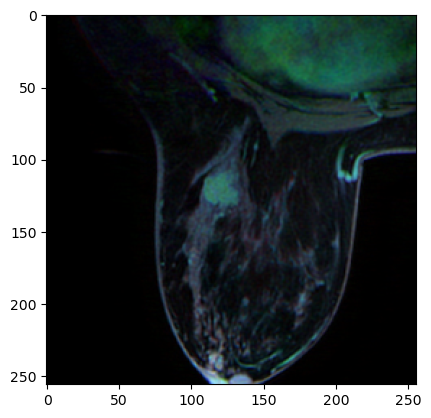

showing 11


<Figure size 640x480 with 0 Axes>

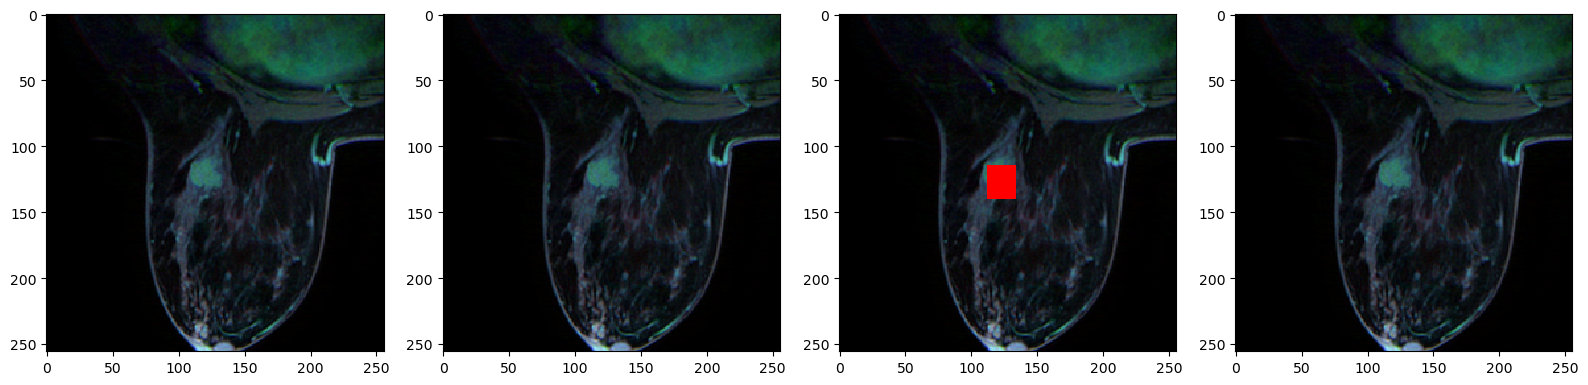

Breast_MRI_583
578 Breast_MRI_583 first last 2 43
70 186 93 163
bbox: 70 93 ---  186 163


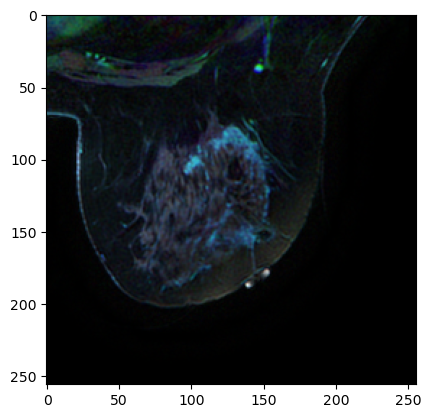

showing 22


<Figure size 640x480 with 0 Axes>

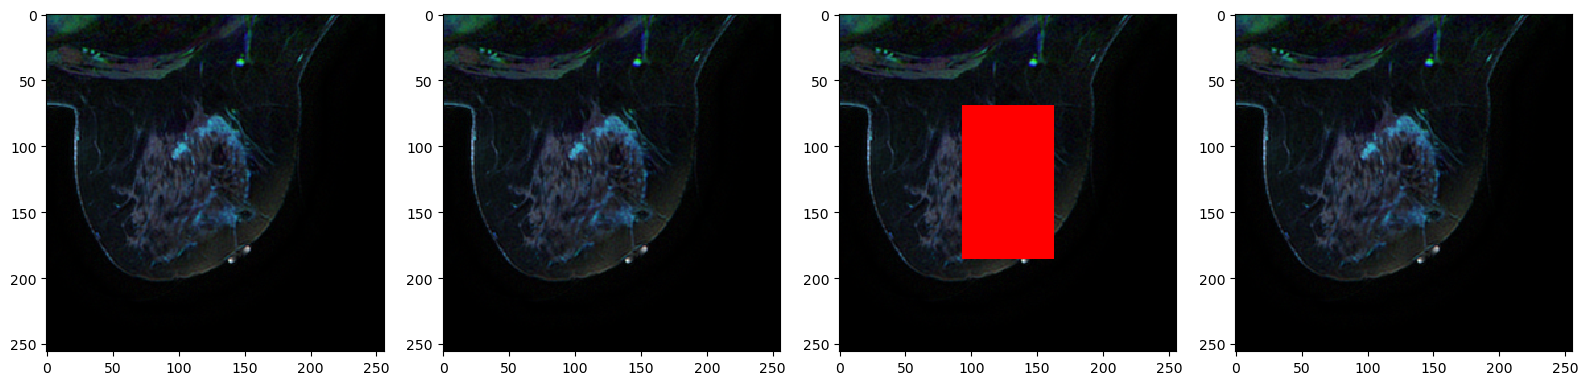

Breast_MRI_874
869 Breast_MRI_874 first last 2 97
46 211 77 185
bbox: 46 77 ---  211 185


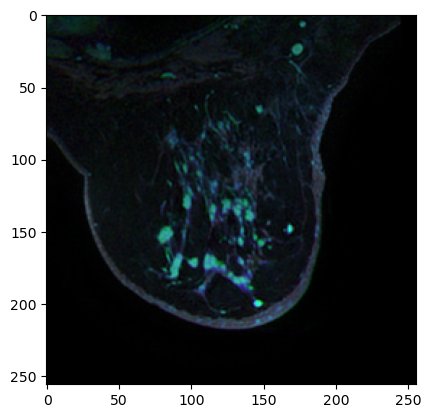

showing 49


<Figure size 640x480 with 0 Axes>

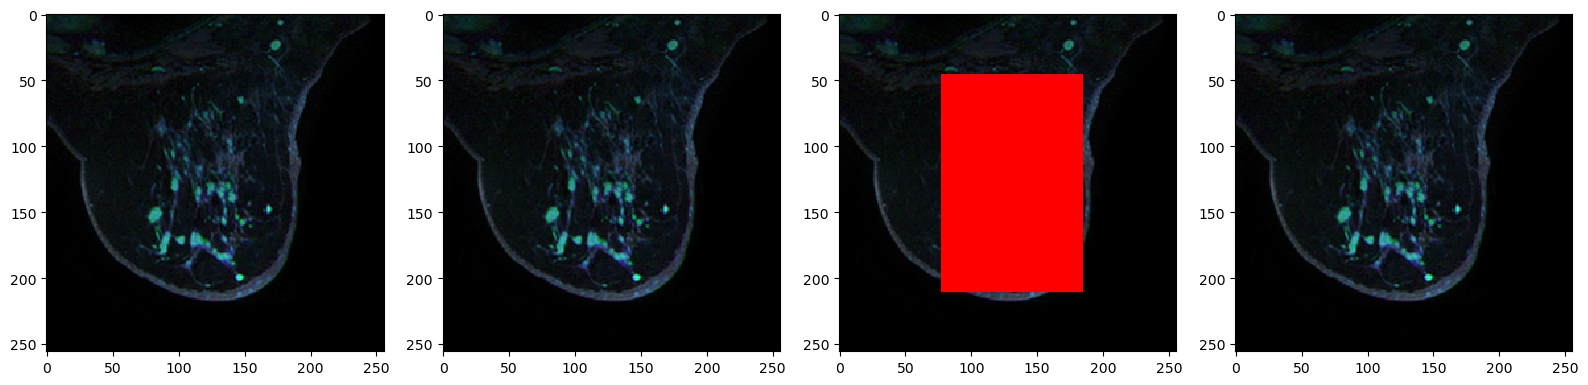

Breast_MRI_887
882 Breast_MRI_887 first last 2 35
78 179 104 174
bbox: 78 104 ---  179 174


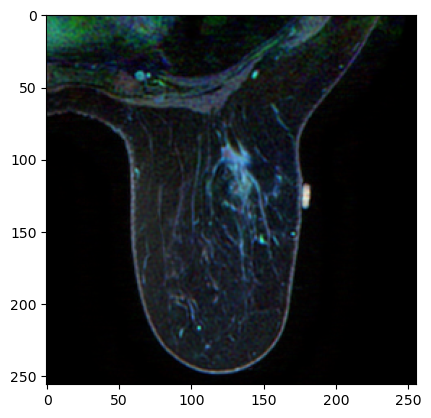

showing 18


<Figure size 640x480 with 0 Axes>

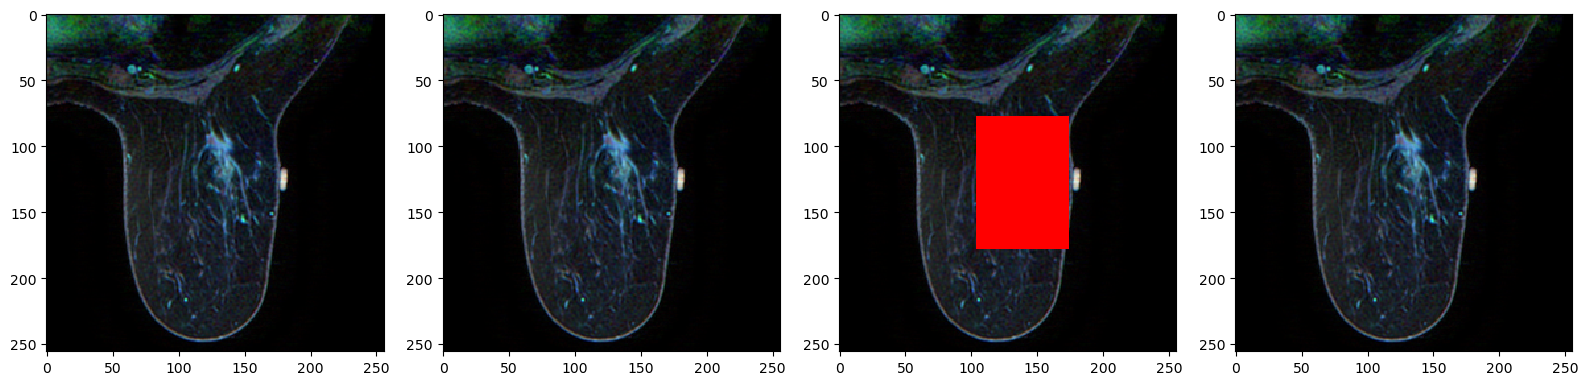

Breast_MRI_471
467 Breast_MRI_471 first last 2 11
118 138 119 135
bbox: 118 119 ---  138 135


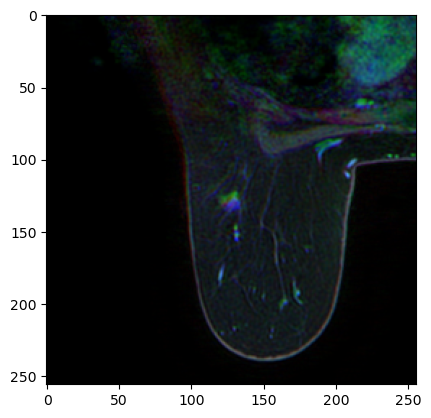

showing 6


<Figure size 640x480 with 0 Axes>

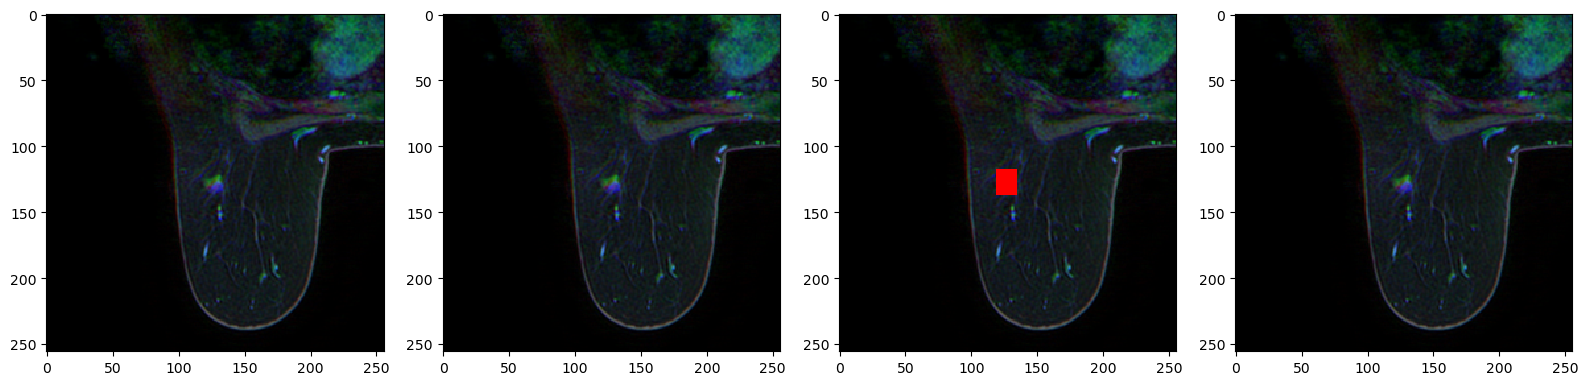

In [472]:
for i,row in df_min[df_min.dataset=='duke'].sample(5).iterrows():

        r=row
        pid = r['pid']
        #if r['n_xy']<=256: continue
            
        
        #if pid not in pp: continue
        print(pid)    
        f =  max(int(row['mask_start']),0)
        l = min(int(row['mask_end'])+1, int(row['n_z']))
        print(i,pid,'first last', f,l)


        preds=[]
        prdm=[]
        prdmed=[]
        
        y_min = int(row['scol'])
        y_max = int(row['ecol'])
        x_min = int(row['sraw'])
        x_max = int(row['eraw'])
        print(x_min,x_max,y_min,y_max)
        

        print('bbox:',x_min, y_min,'--- ', x_max, y_max)

        a0=ds.get_nifti_acquisition(pid, idx=0)
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)

        
        for k in range(f,l,1):
            if deb and k == (f + l) // 2:
                    #imname = get_jpg_im(pid, k, abc=0)
                    #im = Image.open(imname)
                    im=ds.minmax(np.stack([a0[k],a1[k],a2[k]], axis=2))
                    w,h=im.shape[:2]
                    plt.imshow(im)
                    plt.show()

                    #if 1: # w>256:
                    # crop around tumor
                    cropped = im.copy() #crop_around_bbox(im, x_min, y_min, x_max, y_max)

                    print('showing',k)
                    # convert to numpy for manipulation
                    im_np = np.array(im)
                    h, w = im_np.shape[:2]

                    # binary mask
                    imb = np.zeros((h, w))
                    imb[x_min:x_max,y_min:y_max] = 1

                    # red overlay on bbox area
                    imbb = im_np.copy()
                    imbb[x_min:x_max,y_min:y_max,  0] = 1  # red channel
                    imbb[x_min:x_max,y_min:y_max, 1:] = 0   # zero green/blue

                    
                    if deb:
                        ds.show_n_images([im_np, im, imbb, cropped], axis_off=False)
                    im = cropped
                    break
            
        

In [468]:
for k in range(f,l,1):
            print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                982 non-null    object 
 1   Arm                982 non-null    object 
 2   HR                 982 non-null    int64  
 3   HER2               982 non-null    int64  
 4   MP                 982 non-null    int64  
 5   pCR                982 non-null    int64  
 6   age                979 non-null    float64
 7   Race               979 non-null    object 
 8   menopausal_status  895 non-null    object 
 9   e_hispanic_latino  981 non-null    float64
 10  Arm_split          982 non-null    object 
 11  ABT 888            982 non-null    int64  
 12  AMG 386            982 non-null    int64  
 13  Carboplatin        982 non-null    int64  
 14  Ganetespib         982 non-null    int64  
 15  Ganitumab          982 non-null    int64  
 16  MK-2206            982 non

In [374]:
deb=1

ACRIN-6698-378885
69 ACRIN-6698-378885 first last 55 81
135 239 266 318
bbox: 135 266 ---  239 318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<Figure size 640x480 with 0 Axes>

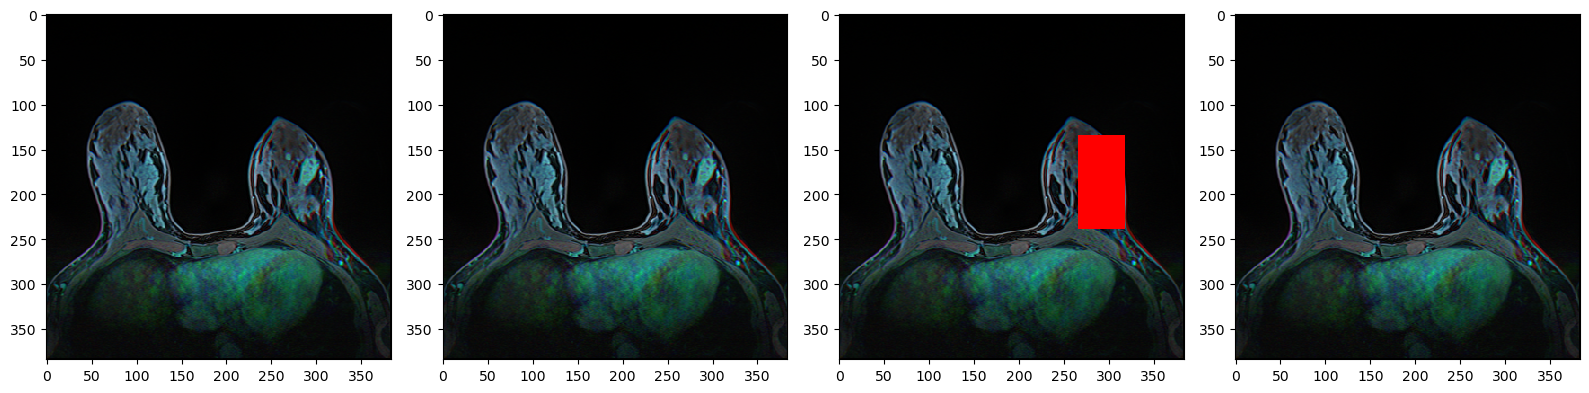

ISPY2-197942
490 ISPY2-197942 first last 27 61
106 180 44 107
bbox: 106 44 ---  180 107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<Figure size 640x480 with 0 Axes>

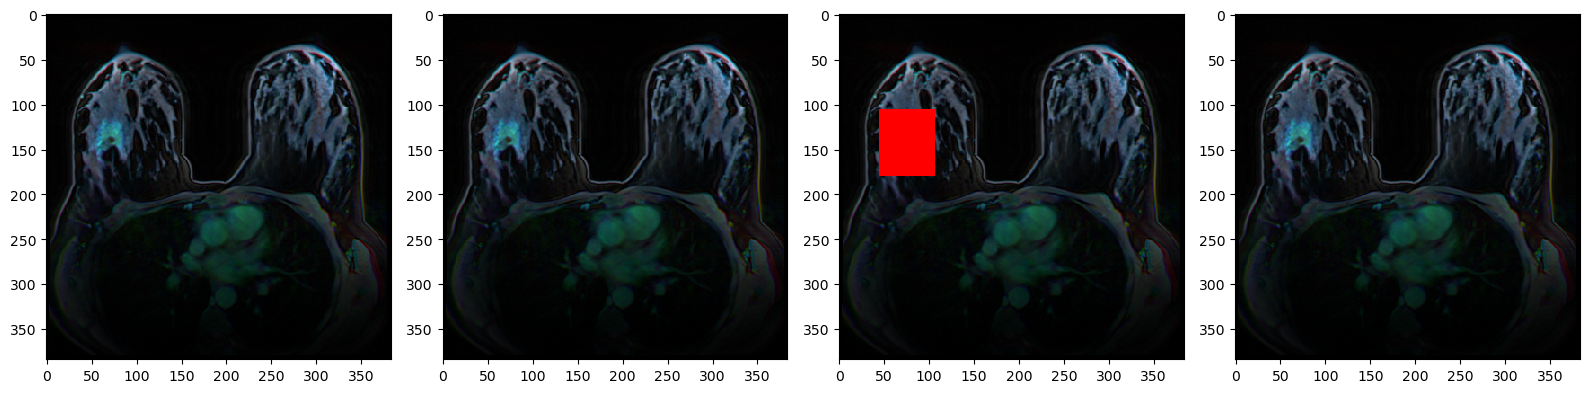

ISPY2-112606
974 ISPY2-112606 first last 60 118
141 197 288 335
bbox: 141 288 ---  197 335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<Figure size 640x480 with 0 Axes>

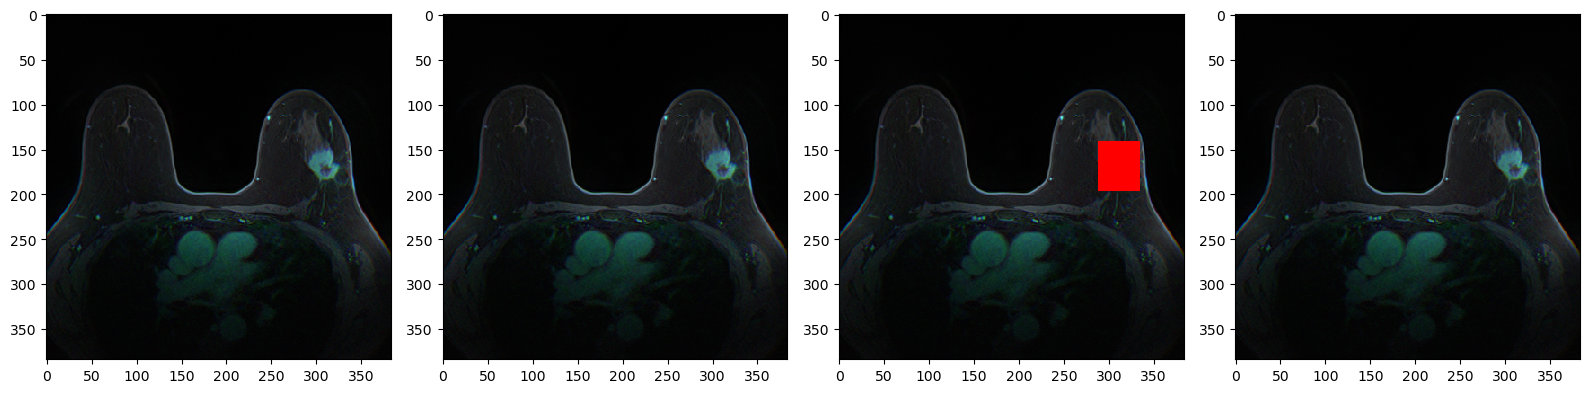

In [379]:
for i,row in df.iterrows():

        r=row
        pid = r['pid']
        #if r['n_xy']<=256: continue
            
        
        if pid not in pp: continue
        print(pid)    
        f =  max(int(row['mask_start']),0)
        l = min(int(row['mask_end'])+1, int(row['n_z']))
        print(i,pid,'first last', f,l)


        preds=[]
        prdm=[]
        prdmed=[]
        
        y_min = int(row['scol'])
        y_max = int(row['ecol'])
        x_min = int(row['sraw'])
        x_max = int(row['eraw'])
        print(x_min,x_max,y_min,y_max)
        '''if pid=='ACRIN-6698-378885':
            x_min = int(row['scol'])-(380-256)
            x_max = int(row['ecol'])-(380-256)
            y_min = int(row['sraw'])
            y_max = int(row['eraw'])'''

        print('bbox:',x_min, y_min,'--- ', x_max, y_max)

        a0=ds.get_nifti_acquisition(pid, idx=0)
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)

        fo=1
        for k in range(f,l,1):

            #imname = get_jpg_im(pid, k, abc=0)
            #im = Image.open(imname)
            im=ds.minmax(np.stack([a0[k],a1[k],a2[k]], axis=2))
            w,h=im.shape[:2]

            if w>256:
                # crop around tumor
                cropped = im.copy() #crop_around_bbox(im, x_min, y_min, x_max, y_max)
                if deb and k == (f + l) // 2:
                    # convert to numpy for manipulation
                    im_np = np.array(im)
                    h, w = im_np.shape[:2]

                    # binary mask
                    imb = np.zeros((h, w))
                    imb[x_min:x_max,y_min:y_max] = 1

                    # red overlay on bbox area
                    imbb = im_np.copy()
                    imbb[x_min:x_max,y_min:y_max,  0] = 255  # red channel
                    imbb[x_min:x_max,y_min:y_max, 1:] = 0   # zero green/blue

                    
                    if deb:
                        ds.show_n_images([im_np, im, imbb, cropped], axis_off=False)
                    im = cropped

In [368]:
pp=['ISPY2-515284', 'ACRIN-6698-378885']

In [ ]:
ISPY2-515284
44 ISPY2-515284 first last 36 79
175 222 31 83
bbox: 175 31 ---  222 83

ACRIN-6698-378885
69 ACRIN-6698-378885 first last 55 81
135 239 266 318
bbox: 142 135 ---  194 239



In [330]:
df_crop[df_crop.n_xy<256]

Empty DataFrame
Columns: [pid, HR, HER2, pCR, age, race_white, race_black, menopause, HER2pos, HRposHER2neg, TripleNeg, dataset, HR_HER2_STATUS, n_xy, n_z, n_times, pre, post_early, post_late, slice_thick, xy_spacing, mask_start, mask_end, mask_count, sraw, eraw, scol, ecol, test, crop_mask_start, crop_mask_end, crop_sraw, crop_eraw, crop_scol, crop_ecol]
Index: []

[0 rows x 35 columns]

In [331]:
df_crop[df_crop.pid=='ISPY2-570685'].T

108
pid              ISPY2-570685
HR                          1
HER2                        1
pCR                         0
age                      70.0
race_white                0.0
race_black                1.0
menopause                 1.0
HER2pos                     1
HRposHER2neg                0
TripleNeg                   0
dataset                  spy2
HR_HER2_STATUS        HER2pos
n_xy                    256.0
n_z                      18.0
n_times                   7.0
pre                       0.0
post_early                2.0
post_late                 6.0
slice_thick               2.2
xy_spacing             0.7031
mask_start                2.0
mask_end                 15.0
mask_count             1158.0
sraw                     52.0
eraw                    130.0
scol                     63.0
ecol                    117.0
test                      0.0
crop_mask_start          23.0
crop_mask_end            40.0
crop_sraw                 0.0
crop_eraw               255.0
crop_scol                 0.0
crop_ecol               255.0

In [288]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df.iterrows():

            
        pid =  row['pid']
        r=row    
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        if pid not in pp: continue
            
        
        
        i0=int(r['pre'])

        if row['n_times']==4:
            i1=1
            i2=2
            i3=3
            i4=3
        else:
            if int(r['post_early'])==1:
                i1=1
                i2=2
            elif r['post_early']==2:
                i1=1
                i2=2
            i4= int(r['post_late']  )
            x=(i2+i4)//2 
    
            if x!=i2 and x!=i4:
               i3=x
            else:
               print('+++++++++++', pid,i0,i1,i2,i3,i4,r['n_times'] )
               break

        print(i0,i1,i2,i3,i4,r['n_times'])
        df_crop.at[i, 'i0']=i0
        df_crop.at[i, 'i1']=i1
        df_crop.at[i, 'i2']=i2
        df_crop.at[i, 'i3']=i3
        df_crop.at[i, 'i4']=i4
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])
        
        a=ds.get_nifti_acquisitions(pid)
        assert(len(a)==int(r['n_times']))
        
        
        
        if a is not None:
            if row['n_z'] is not None:
                z=int(row['n_z'])
                assert(a[0].shape[0]==z)
            else:
                df_crop.at[i,'org_n_z']=a[0].shape[0]
                print('===correct n_z of ',pid,' to ',a0.shape[0])
        else:
            print('a is none')
            continue
            
        w=int(row['n_xy'])
        
        
        assert(a[0].shape[1]==w)
        assert(a[0].shape[2]==w)
        
        print(i, '---',pid,a[0].shape)
        
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a[0].shape, voi, slice_padding=1, output_size=256)
        print('crop_coords', crop_coords)
        print('new ',voi)

        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]

        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
    
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 

        if r['n_xy']>256:
            c=[]
            for jj in [i0,i1,i2,i3,i4]:
                x=crop_with_same_coordinates(a[jj], crop_coords)
                c.append(x)
            c=np.array(c)
            print('result ',pid,c.shape)
            
        else:
            
            c=[]
            crop_coords=np.array(crop_coords)
            crop_coords[2]=0
            crop_coords[3]=255
            crop_coords[4]=0
            crop_coords[5]=255
            for jj in [i0,i1,i2,i3,i4]:
                   vv=[]
                   for h in range(a[jj].shape[0]):
                       img=a[jj][h]
                       if a[jj][h].shape[0]<256:
                           img = cv2.resize(a[jj][h], (256, 256), interpolation=cv2.INTER_AREA) 
                        
                       vv.append(img)
                   vv=np.array(vv)
                   c.append(vv)
            c=np.array(c)
            print('result ',pid,c.shape)
                
        fn = pid+'_spy2_aqc_crop5.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),c)
        print('saving:',os.path.join(fpath, fn))

        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = c[0].shape[0]
        for kk in range(5):
            x=c[kk].max()
            y=len(set(c[kk].flatten()))
            df_crop.at[i, 'mx_'+str(kk)]=x
            df_crop.at[i, 'nuq_'+str(kk)]=y
        df_crop.to_csv('C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\df_spy2_crop5.csv', index = False)  

0 ISPY2-756412 3.0 46.0
1 ISPY2-111881 68.0 105.0
2 ISPY2-451816 17.0 64.0
3 ISPY2-243836 9.0 27.0
4 ISPY2-402265 47.0 116.0
5 ISPY2-611662 15.0 41.0
6 ISPY2-139137 43.0 126.0
7 ISPY2-685753 32.0 49.0
8 ISPY2-627981 82.0 128.0
9 ISPY2-108939 49.0 75.0
10 ISPY2-629210 6.0 61.0
11 ISPY2-809037 36.0 55.0
12 ACRIN-6698-107700 23.0 46.0
13 ISPY2-373672 53.0 123.0
14 ISPY2-615873 42.0 100.0
15 ISPY2-607047 27.0 105.0
16 ISPY2-155171 11.0 120.0
17 ISPY2-815421 16.0 51.0
18 ISPY2-609897 35.0 50.0
19 ISPY2-605713 20.0 74.0
20 ISPY2-246134 53.0 99.0
21 ACRIN-6698-373346 30.0 60.0
22 ISPY2-349225 14.0 74.0
23 ISPY2-208265 61.0 131.0
24 ISPY2-395076 27.0 58.0
25 ISPY2-637752 55.0 119.0
26 ISPY2-331192 42.0 105.0
27 ISPY2-327133 12.0 134.0
28 ISPY2-541165 14.0 39.0
29 ISPY2-802778 12.0 26.0
30 ISPY2-794428 23.0 56.0
31 ISPY2-625800 3.0 56.0
32 ISPY2-422450 62.0 104.0
33 ISPY2-613188 15.0 29.0
34 ISPY2-159284 1.0 57.0
35 ACRIN-6698-641977 52.0 72.0
36 ACRIN-6698-326433 71.0 102.0
37 ISPY2-539876 36.

last acquisition 4
22 --- Breast_MRI_023 (192, 448, 448)
crop_coords (91, 117, 6, 261, 191, 446)
new  [(93, 115), (114, 155), (340, 369)]
result  Breast_MRI_023 (4, 27, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_023_duke_aqc_crop5.nii.gz
23 Breast_MRI_024 89.0 94.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_024_duke_aqc_0.nii.gz
last acquisition 4
23 --- Breast_MRI_024 (180, 512, 512)
crop_coords (87, 96, 255, 510, 74, 329)
new  [(89, 94), (391, 398), (198, 206)]
result  Breast_MRI_024 (4, 10, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_024_duke_aqc_crop5.nii.gz
24 Breast_MRI_025 29.0 46.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_025_duke_aqc_0.nii.gz
last acquisition 4
24 --- Breast_MRI_025 (156, 512, 512)
crop_coords (27, 48, 109, 364, 0, 255)
new  [(29, 46), (223, 252), (69, 94)]
result  Breast_MRI_025 (4, 22, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_025_

last acquisition 4
44 --- Breast_MRI_045 (188, 512, 512)
crop_coords (48, 84, 192, 447, 31, 286)
new  [(50, 82), (288, 352), (128, 190)]
result  Breast_MRI_045 (4, 37, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_045_duke_aqc_crop5.nii.gz
45 Breast_MRI_046 102.0 190.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_046_duke_aqc_0.nii.gz
last acquisition 4
45 --- Breast_MRI_046 (256, 448, 448)
crop_coords (100, 192, 24, 279, 0, 255)
new  [(102, 190), (99, 205), (77, 162)]
result  Breast_MRI_046 (4, 93, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_046_duke_aqc_crop5.nii.gz
46 Breast_MRI_047 61.0 94.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_047_duke_aqc_0.nii.gz
last acquisition 4
46 --- Breast_MRI_047 (160, 512, 512)
crop_coords (59, 96, 239, 494, 11, 266)
new  [(61, 94), (336, 398), (116, 163)]
result  Breast_MRI_047 (4, 38, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_

last acquisition 5
66 --- Breast_MRI_067 (160, 448, 448)
crop_coords (53, 71, 38, 293, 191, 446)
new  [(55, 69), (152, 181), (365, 387)]
result  Breast_MRI_067 (5, 19, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_067_duke_aqc_crop5.nii.gz
67 Breast_MRI_068 72.0 117.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_068_duke_aqc_0.nii.gz
last acquisition 5
67 --- Breast_MRI_068 (186, 512, 512)
crop_coords (70, 119, 218, 473, 0, 255)
new  [(72, 117), (288, 404), (79, 138)]
result  Breast_MRI_068 (5, 50, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_068_duke_aqc_crop5.nii.gz
68 Breast_MRI_069 114.0 130.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_069_duke_aqc_0.nii.gz
last acquisition 5
68 --- Breast_MRI_069 (196, 512, 512)
crop_coords (112, 132, 194, 449, 217, 472)
new  [(114, 130), (309, 335), (327, 364)]
result  Breast_MRI_069 (5, 21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breas

last acquisition 4
88 --- Breast_MRI_089 (176, 512, 512)
crop_coords (128, 162, 161, 416, 255, 510)
new  [(130, 160), (231, 348), (391, 447)]
result  Breast_MRI_089 (4, 35, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_089_duke_aqc_crop5.nii.gz
89 Breast_MRI_090 46.0 164.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_090_duke_aqc_0.nii.gz
last acquisition 4
89 --- Breast_MRI_090 (196, 512, 512)
crop_coords (44, 166, 204, 459, 240, 495)
new  [(46, 164), (274, 391), (306, 430)]
result  Breast_MRI_090 (4, 123, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_090_duke_aqc_crop5.nii.gz
90 Breast_MRI_091 73.0 118.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_091_duke_aqc_0.nii.gz
last acquisition 5
90 --- Breast_MRI_091 (160, 448, 448)
crop_coords (71, 120, 66, 321, 191, 446)
new  [(73, 118), (156, 233), (289, 374)]
result  Breast_MRI_091 (5, 50, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\

last acquisition 4
110 --- Breast_MRI_111 (144, 512, 512)
crop_coords (39, 53, 132, 387, 0, 255)
new  [(41, 51), (254, 267), (115, 127)]
result  Breast_MRI_111 (4, 15, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_111_duke_aqc_crop5.nii.gz
111 Breast_MRI_112 98.0 111.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_112_duke_aqc_0.nii.gz
last acquisition 5
111 --- Breast_MRI_112 (160, 320, 320)
crop_coords (96, 113, 0, 255, 63, 318)
new  [(98, 111), (92, 127), (180, 204)]
result  Breast_MRI_112 (5, 18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_112_duke_aqc_crop5.nii.gz
112 Breast_MRI_113 30.0 35.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_113_duke_aqc_0.nii.gz
last acquisition 5
112 --- Breast_MRI_113 (166, 512, 512)
crop_coords (28, 37, 201, 456, 236, 491)
new  [(30, 35), (322, 337), (357, 371)]
result  Breast_MRI_113 (5, 10, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_M

last acquisition 5
132 --- Breast_MRI_133 (142, 512, 512)
crop_coords (79, 95, 241, 496, 247, 502)
new  [(81, 93), (356, 383), (363, 388)]
result  Breast_MRI_133 (5, 17, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_133_duke_aqc_crop5.nii.gz
133 Breast_MRI_134 22.0 47.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_134_duke_aqc_0.nii.gz
last acquisition 5
133 --- Breast_MRI_134 (142, 512, 512)
crop_coords (20, 49, 191, 446, 15, 270)
new  [(22, 47), (304, 335), (130, 156)]
result  Breast_MRI_134 (5, 30, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_134_duke_aqc_crop5.nii.gz
134 Breast_MRI_135 53.0 80.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_135_duke_aqc_0.nii.gz
last acquisition 5
134 --- Breast_MRI_135 (176, 512, 512)
crop_coords (51, 82, 166, 421, 33, 288)
new  [(53, 80), (275, 313), (140, 183)]
result  Breast_MRI_135 (5, 32, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_

last acquisition 5
154 --- Breast_MRI_155 (192, 512, 512)
crop_coords (70, 95, 225, 480, 245, 500)
new  [(72, 93), (327, 380), (355, 392)]
result  Breast_MRI_155 (5, 26, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_155_duke_aqc_crop5.nii.gz
155 Breast_MRI_156 18.0 62.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_156_duke_aqc_0.nii.gz
last acquisition 4
155 --- Breast_MRI_156 (160, 448, 448)
crop_coords (16, 64, 63, 318, 0, 255)
new  [(18, 62), (175, 207), (91, 149)]
result  Breast_MRI_156 (4, 49, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_156_duke_aqc_crop5.nii.gz
156 Breast_MRI_157 101.0 141.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_157_duke_aqc_0.nii.gz
last acquisition 4
156 --- Breast_MRI_157 (176, 448, 448)
crop_coords (99, 143, 92, 347, 20, 275)
new  [(101, 141), (195, 245), (124, 173)]
result  Breast_MRI_157 (4, 45, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast

last acquisition 4
176 --- Breast_MRI_177 (192, 448, 448)
crop_coords (83, 102, 5, 260, 191, 446)
new  [(85, 100), (119, 148), (311, 332)]
result  Breast_MRI_177 (4, 20, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_177_duke_aqc_crop5.nii.gz
177 Breast_MRI_178 74.0 105.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_178_duke_aqc_0.nii.gz
last acquisition 4
177 --- Breast_MRI_178 (200, 512, 512)
crop_coords (72, 107, 195, 450, 217, 472)
new  [(74, 105), (287, 360), (316, 375)]
result  Breast_MRI_178 (4, 36, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_178_duke_aqc_crop5.nii.gz
178 Breast_MRI_179 99.0 123.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_179_duke_aqc_0.nii.gz
last acquisition 5
178 --- Breast_MRI_179 (196, 512, 512)
crop_coords (97, 125, 138, 393, 255, 510)
new  [(99, 123), (221, 312), (360, 406)]
result  Breast_MRI_179 (5, 29, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5

last acquisition 4
198 --- Breast_MRI_199 (176, 512, 512)
crop_coords (69, 92, 172, 427, 204, 459)
new  [(71, 90), (285, 316), (314, 350)]
result  Breast_MRI_199 (4, 24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_199_duke_aqc_crop5.nii.gz
199 Breast_MRI_200 44.0 87.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_200_duke_aqc_0.nii.gz
last acquisition 4
199 --- Breast_MRI_200 (144, 320, 320)
crop_coords (42, 89, 0, 255, 0, 255)
new  [(44, 87), (86, 150), (73, 126)]
result  Breast_MRI_200 (4, 48, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_200_duke_aqc_crop5.nii.gz
200 Breast_MRI_201 96.0 115.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_201_duke_aqc_0.nii.gz
last acquisition 4
200 --- Breast_MRI_201 (176, 448, 448)
crop_coords (94, 117, 23, 278, 0, 255)
new  [(96, 115), (136, 166), (72, 103)]
result  Breast_MRI_201 (4, 24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_2

last acquisition 4
220 --- Breast_MRI_221 (240, 448, 448)
crop_coords (84, 127, 64, 319, 0, 255)
new  [(86, 125), (162, 222), (90, 130)]
result  Breast_MRI_221 (4, 44, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_221_duke_aqc_crop5.nii.gz
221 Breast_MRI_222 101.0 147.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_222_duke_aqc_0.nii.gz
last acquisition 5
221 --- Breast_MRI_222 (192, 512, 512)
crop_coords (99, 149, 118, 373, 8, 263)
new  [(101, 147), (213, 280), (106, 166)]
result  Breast_MRI_222 (5, 51, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_222_duke_aqc_crop5.nii.gz
222 Breast_MRI_223 95.0 114.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_223_duke_aqc_0.nii.gz
last acquisition 4
222 --- Breast_MRI_223 (192, 448, 448)
crop_coords (93, 116, 0, 255, 191, 446)
new  [(95, 114), (116, 138), (319, 344)]
result  Breast_MRI_223 (4, 24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Bre

last acquisition 5
242 --- Breast_MRI_243 (192, 512, 512)
crop_coords (110, 127, 192, 447, 0, 255)
new  [(112, 125), (305, 336), (117, 139)]
result  Breast_MRI_243 (5, 18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_243_duke_aqc_crop5.nii.gz
243 Breast_MRI_244 45.0 73.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_244_duke_aqc_0.nii.gz
last acquisition 5
243 --- Breast_MRI_244 (156, 512, 512)
crop_coords (43, 75, 140, 395, 255, 510)
new  [(45, 73), (252, 284), (394, 429)]
result  Breast_MRI_244 (5, 33, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_244_duke_aqc_crop5.nii.gz
244 Breast_MRI_245 73.0 100.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_245_duke_aqc_0.nii.gz
last acquisition 5
244 --- Breast_MRI_245 (154, 512, 512)
crop_coords (71, 102, 255, 510, 255, 510)
new  [(73, 100), (367, 405), (420, 462)]
result  Breast_MRI_245 (5, 32, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\

saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_265_duke_aqc_crop5.nii.gz
265 Breast_MRI_266 93.0 126.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_266_duke_aqc_0.nii.gz
last acquisition 5
265 --- Breast_MRI_266 (160, 448, 448)
crop_coords (91, 128, 106, 361, 0, 255)
new  [(93, 126), (175, 293), (70, 154)]
result  Breast_MRI_266 (5, 38, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_266_duke_aqc_crop5.nii.gz
266 Breast_MRI_267 87.0 104.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_267_duke_aqc_0.nii.gz
last acquisition 4
266 --- Breast_MRI_267 (160, 512, 512)
crop_coords (85, 106, 219, 474, 0, 255)
new  [(87, 104), (322, 372), (86, 123)]
result  Breast_MRI_267 (4, 22, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_267_duke_aqc_crop5.nii.gz
267 Breast_MRI_268 21.0 58.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_268_duke_aqc_0.nii.gz
last acquisition 4
267 --- Breast_MRI_268 (160

last acquisition 4
287 --- Breast_MRI_288 (208, 448, 448)
crop_coords (69, 84, 86, 341, 0, 255)
new  [(71, 82), (204, 224), (89, 108)]
result  Breast_MRI_288 (4, 16, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_288_duke_aqc_crop5.nii.gz
288 Breast_MRI_289 36.0 47.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_289_duke_aqc_0.nii.gz
last acquisition 4
288 --- Breast_MRI_289 (138, 512, 512)
crop_coords (34, 49, 186, 441, 217, 472)
new  [(36, 47), (297, 331), (327, 364)]
result  Breast_MRI_289 (4, 16, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_289_duke_aqc_crop5.nii.gz
289 Breast_MRI_290 95.0 111.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_290_duke_aqc_0.nii.gz
last acquisition 4
289 --- Breast_MRI_290 (224, 448, 448)
crop_coords (93, 113, 0, 255, 179, 434)
new  [(95, 111), (115, 142), (297, 318)]
result  Breast_MRI_290 (4, 21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_M

last acquisition 5
309 --- Breast_MRI_310 (170, 512, 512)
crop_coords (25, 49, 255, 510, 0, 255)
new  [(27, 47), (375, 414), (93, 125)]
result  Breast_MRI_310 (5, 25, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_310_duke_aqc_crop5.nii.gz
310 Breast_MRI_311 111.0 124.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_311_duke_aqc_0.nii.gz
last acquisition 4
310 --- Breast_MRI_311 (174, 512, 512)
crop_coords (109, 126, 203, 458, 0, 255)
new  [(111, 124), (320, 343), (102, 128)]
result  Breast_MRI_311 (4, 18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_311_duke_aqc_crop5.nii.gz
311 Breast_MRI_312 91.0 107.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_312_duke_aqc_0.nii.gz
last acquisition 4
311 --- Breast_MRI_312 (160, 512, 512)
crop_coords (89, 109, 151, 406, 255, 510)
new  [(91, 107), (269, 290), (375, 397)]
result  Breast_MRI_312 (4, 21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\B

last acquisition 5
331 --- Breast_MRI_332 (192, 512, 512)
crop_coords (71, 97, 189, 444, 218, 473)
new  [(73, 95), (299, 335), (327, 366)]
result  Breast_MRI_332 (5, 27, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_332_duke_aqc_crop5.nii.gz
332 Breast_MRI_333 92.0 106.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_333_duke_aqc_0.nii.gz
last acquisition 5
332 --- Breast_MRI_333 (156, 512, 512)
crop_coords (90, 108, 169, 424, 221, 476)
new  [(92, 106), (283, 312), (331, 368)]
result  Breast_MRI_333 (5, 19, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_333_duke_aqc_crop5.nii.gz
333 Breast_MRI_334 30.0 42.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_334_duke_aqc_0.nii.gz
last acquisition 5
333 --- Breast_MRI_334 (166, 512, 512)
crop_coords (28, 44, 148, 403, 7, 262)
new  [(30, 42), (266, 287), (123, 147)]
result  Breast_MRI_334 (5, 17, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Brea

last acquisition 4
353 --- Breast_MRI_354 (196, 512, 512)
crop_coords (87, 115, 208, 463, 8, 263)
new  [(89, 113), (323, 349), (117, 156)]
result  Breast_MRI_354 (4, 29, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_354_duke_aqc_crop5.nii.gz
354 Breast_MRI_355 86.0 97.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_355_duke_aqc_0.nii.gz
last acquisition 4
354 --- Breast_MRI_355 (144, 512, 512)
crop_coords (84, 99, 249, 504, 17, 272)
new  [(86, 97), (357, 397), (131, 159)]
result  Breast_MRI_355 (4, 16, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_355_duke_aqc_crop5.nii.gz
355 Breast_MRI_356 63.0 127.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_356_duke_aqc_0.nii.gz
last acquisition 5
355 --- Breast_MRI_356 (160, 448, 448)
crop_coords (61, 129, 106, 361, 191, 446)
new  [(63, 127), (196, 273), (325, 388)]
result  Breast_MRI_356 (5, 69, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Bre

last acquisition 5
375 --- Breast_MRI_376 (128, 448, 448)
crop_coords (40, 57, 75, 330, 191, 446)
new  [(42, 55), (190, 216), (354, 382)]
result  Breast_MRI_376 (5, 18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_376_duke_aqc_crop5.nii.gz
376 Breast_MRI_377 72.0 91.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_377_duke_aqc_0.nii.gz
last acquisition 4
376 --- Breast_MRI_377 (176, 512, 512)
crop_coords (70, 93, 194, 449, 32, 287)
new  [(72, 91), (307, 338), (142, 178)]
result  Breast_MRI_377 (4, 24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_377_duke_aqc_crop5.nii.gz
377 Breast_MRI_378 43.0 82.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_378_duke_aqc_0.nii.gz
last acquisition 5
377 --- Breast_MRI_378 (156, 512, 512)
crop_coords (41, 84, 162, 417, 1, 256)
new  [(43, 82), (262, 318), (106, 152)]
result  Breast_MRI_378 (5, 44, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MR

last acquisition 4
397 --- Breast_MRI_398 (144, 448, 448)
crop_coords (89, 109, 73, 328, 0, 255)
new  [(91, 107), (189, 214), (58, 87)]
result  Breast_MRI_398 (4, 21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_398_duke_aqc_crop5.nii.gz
398 Breast_MRI_399 68.0 86.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_399_duke_aqc_0.nii.gz
last acquisition 5
398 --- Breast_MRI_399 (152, 512, 512)
crop_coords (66, 88, 196, 451, 16, 271)
new  [(68, 86), (306, 342), (131, 158)]
result  Breast_MRI_399 (5, 23, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_399_duke_aqc_crop5.nii.gz
399 Breast_MRI_400 33.0 88.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_400_duke_aqc_0.nii.gz
last acquisition 5
399 --- Breast_MRI_400 (158, 512, 512)
crop_coords (31, 90, 179, 434, 73, 328)
new  [(33, 88), (271, 344), (164, 239)]
result  Breast_MRI_400 (5, 60, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI

last acquisition 4
419 --- Breast_MRI_420 (160, 320, 320)
crop_coords (59, 144, 0, 255, 0, 255)
new  [(61, 142), (50, 127), (71, 142)]
result  Breast_MRI_420 (4, 86, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_420_duke_aqc_crop5.nii.gz
420 Breast_MRI_421 61.0 91.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_421_duke_aqc_0.nii.gz
last acquisition 4
420 --- Breast_MRI_421 (174, 512, 512)
crop_coords (59, 93, 197, 452, 255, 510)
new  [(61, 91), (280, 370), (357, 482)]
result  Breast_MRI_421 (4, 35, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_421_duke_aqc_crop5.nii.gz
421 Breast_MRI_422 126.0 139.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_422_duke_aqc_0.nii.gz
last acquisition 5
421 --- Breast_MRI_422 (192, 512, 512)
crop_coords (124, 141, 214, 469, 53, 308)
new  [(126, 139), (328, 357), (168, 195)]
result  Breast_MRI_422 (5, 18, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Brea

last acquisition 5
441 --- Breast_MRI_442 (154, 512, 512)
crop_coords (47, 67, 159, 414, 44, 299)
new  [(49, 65), (263, 311), (152, 193)]
result  Breast_MRI_442 (5, 21, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_442_duke_aqc_crop5.nii.gz
442 Breast_MRI_443 36.0 55.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_443_duke_aqc_0.nii.gz
last acquisition 4
442 --- Breast_MRI_443 (176, 512, 512)
crop_coords (34, 57, 154, 409, 21, 276)
new  [(36, 55), (263, 302), (130, 168)]
result  Breast_MRI_443 (4, 24, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_443_duke_aqc_crop5.nii.gz
443 Breast_MRI_444 71.0 101.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_444_duke_aqc_0.nii.gz
last acquisition 4
443 --- Breast_MRI_444 (176, 512, 512)
crop_coords (69, 103, 210, 465, 249, 504)
new  [(71, 101), (307, 370), (346, 408)]
result  Breast_MRI_444 (4, 35, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Brea

last acquisition 5
463 --- Breast_MRI_464 (160, 448, 448)
crop_coords (93, 130, 97, 352, 0, 255)
new  [(95, 128), (195, 255), (70, 125)]
result  Breast_MRI_464 (5, 38, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_464_duke_aqc_crop5.nii.gz
464 Breast_MRI_465 82.0 99.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_465_duke_aqc_0.nii.gz
last acquisition 4
464 --- Breast_MRI_465 (180, 512, 512)
crop_coords (80, 101, 123, 378, 0, 255)
new  [(82, 99), (236, 266), (97, 135)]
result  Breast_MRI_465 (4, 22, 256, 256)
saving: C:\Users\naomi\Downloads\breast_mri\duke\min_dce_5\Breast_MRI_465_duke_aqc_crop5.nii.gz
465 Breast_MRI_466 98.0 127.0
loading G:\My Drive\breast_mri\DUKE\dce\Breast_MRI_466_duke_aqc_0.nii.gz


In [ ]:
Epoch 1, Batch 0, Loss: 0.6903
ISPY1_1212 6
ISPY1_1104 6
Epoch 1, Batch 50, Loss: 0.6365
ISPY1_1104 6
ISPY1_1104 6
ISPY1_1184 6
ISPY1_1228 6
ISPY1_1228 6
Epoch 1, Batch 100, Loss: 0.6575
ISPY1_1184 6
ISPY1_1104 6
ISPY1_1212 6
ISPY1_1212 6
ISPY1_1215 6
ISPY1_1228 6
ISPY1_1124 6
ISPY1_1215 6
ISPY1_1184 6
Epoch 1, Batch 150, Loss: 0.6929
ISPY1_1104 6
ISPY1_1104 6
ISPY1_1124 6
ISPY1_1104 6
ISPY1_1184 6
Epoch 1, Batch 200, Loss: 0.7377
ISPY1_1215 6

In [174]:
    # Iterate through DataFrame rows
    for i, row in df.iterrows():
            
        pid =  row['pid']
        print('==========', pid)
        r=row  
        fn = pid+'_spy2_aqc_crop5.nii.gz'
        if not os.path.isfile(os.path.join(fpath, fn)):
            print('no file:',pid, os.path.join(fpath, fn))

========== ISPY2-756412
========== ISPY2-111881
========== ISPY2-451816
========== ISPY2-243836
========== ISPY2-402265
========== ISPY2-611662
========== ISPY2-139137
========== ISPY2-685753
========== ISPY2-627981
========== ISPY2-108939
========== ISPY2-629210
========== ISPY2-809037
========== ACRIN-6698-107700
========== ISPY2-373672
========== ISPY2-615873
========== ISPY2-607047
========== ISPY2-155171
========== ISPY2-815421
========== ISPY2-609897
========== ISPY2-605713
========== ISPY2-246134
========== ACRIN-6698-373346
========== ISPY2-349225
========== ISPY2-208265
========== ISPY2-395076
========== ISPY2-637752
========== ISPY2-331192
========== ISPY2-327133
========== ISPY2-541165
========== ISPY2-802778
========== ISPY2-794428
========== ISPY2-625800
========== ISPY2-422450
========== ISPY2-613188
========== ISPY2-159284
========== ACRIN-6698-641977
========== ACRIN-6698-326433
========== ISPY2-539876
========== ISPY2-109623
========== ISPY2-153327
========== ISPY2-622

In [104]:
import cv2

In [175]:
df_crop.to_csv('C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\df_spy2_crop5.csv', index = False)  

<Axes: ylabel='Frequency'>

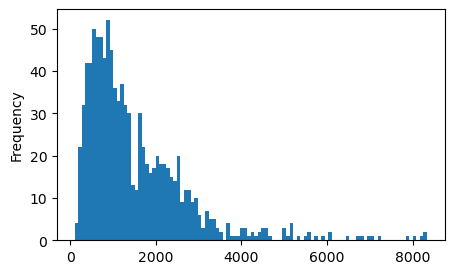

In [176]:
df_crop.mx_0.plot(kind='hist',bins=100,figsize=(5,3))

In [110]:
for i,row in df_crop.iterrows():
    pid=row['pid']
    r=row
    if r['n_xy']>=256:
            continue
    fn = pid+'_spy2_aqc_crop5.nii.gz'
    if not os.path.isfile(os.path.join(fpath, fn)):
        continue
    a = ds.read_niftii(os.path.join(fpath, fn))
    if a is None:
        continue
    print('=======',i,pid,'loading:',os.path.join(fpath, fn), a.shape)
    if a.shape[0]==4:
        b=[a[0],a[1],a[2],a[2],a[3]]
        b=np.array(b)
        a=b
        ds.save_niftii(os.path.join(fpath, fn),b)
        print('saving:',os.path.join(fpath, fn))
        print(b.shape)
        
    if a.shape[0]==3:
        b=[a[0],a[1],a[1],a[2],a[2]]
        b=np.array(b)
        a=b
        ds.save_niftii(os.path.join(fpath, fn),b)
        print('saving:',os.path.join(fpath, fn))
        print(b.shape)
        
    for kk in range(5):
        x=a[kk].max()
        y=len(set(a[kk].flatten()))
        df_crop.at[i, 'mx_'+str(kk)]=x
        df_crop.at[i, 'nuq_'+str(kk)]=y

In [111]:
df_crop.to_csv('C:\\Users\\naomi\\Downloads\\breast_mri\\SPY2\\df_spy2_crop5.csv', index = False)  

In [115]:
df_crop.to_csv('C:\\Users\\naomi\\Downloads\\breast_mri\\df_spy2_crop5.csv', index = False)  

In [ ]:
i

In [64]:
df[df.pid=='ISPY2-756412'][df.columns[-20:]]

TripleNeg dataset HR_HER2_STATUS   n_xy   n_z  n_times  pre  post_early  \
0          0    spy2   HRposHER2neg  256.0  76.0      7.0  0.0         2.0   

   post_late  slice_thick  xy_spacing  mask_start  mask_end  mask_count  \
0        5.0          2.4      0.5469         3.0      46.0     20228.0   

   is_mask  sraw   eraw  scol   ecol  test  
0      1.0  15.0  178.0  46.0  127.0   0.0

In [112]:
len(a),r

(7,
 pid                            ISPY2-960963
 Arm      Paclitaxel + MK-2206 + Trastuzumab
 HR                                        1
 HER2                                      1
 MP                                        0
                         ...                
 nuq_2                                   NaN
 mx_3                                    NaN
 nuq_3                                   NaN
 mx_4                                    NaN
 nuq_4                                   NaN
 Name: 981, Length: 78, dtype: object)

In [366]:
[i0,i1,i2,i3,i4]

[0, 2, 6, 3, 5]

In [367]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df.iterrows():
        
        pid =  row['pid']
       
        if pid not in ppp +pp : continue
            
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a0=ds.get_nifti_acquisition(pid, idx=0)
        
        if a0 is not None:
            if row['n_z'] is not None:
                z=int(row['n_z'])
                assert(a0.shape[0]==z)
            else:
                df_crop.at[i,'org_n_z']=a0.shape[0]
                print('correct n_z of ',pid,' to ',a0.shape[0])
        else:
            continue
            
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        assert(int(row['post_late'])==int(row['n_times']-1))
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=2, output_size=256)
        print(crop_coords)
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)
        
        ca0 = crop_with_same_coordinates(a0, crop_coords)
        ca1 = crop_with_same_coordinates(a1, crop_coords)
        ca2 = crop_with_same_coordinates(a2, crop_coords)
        c = [ca1,ca1,ca2]
        
        fn = pid+'_duke_aqc_0.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca0)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_1.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca1)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_'+str(int(i2))+'.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca2)
        print('saving:',os.path.join(fpath, fn))
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = ca0.shape[0]
        
        

NameError: name 'ppp' is not defined

In [ ]:
ds.show_pid('Breast_MRI_801',[0,1,2])

In [ ]:
ca0.shape

In [ ]:
df_crop.info()

In [ ]:
df_crop.to_csv('BrestDCEDL_duke_cropped.csv', index = False)
df_crop.shape

922 paitents, 6 had missing data, final 986